In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    #plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [3]:
run_all = True  # set to False to run only the first epoch
#cluster = 'PAL5'
#cluster = 'PAL13'
cluster = 'IC4499'
base_dir = 'data/'+cluster+'/'
#channel = '3p6um'
channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
#sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]
    
if cluster == 'IC4499':
    default_list = list(range(98))
    ch1_notlist = [25, 32, 37, 40, 42, 43, 51, 58, 67, 72, 77, 87, 94]  # stars NOT in each channel
    ch2_notlist = [21, 25, 32, 37, 40, 42, 51, 58, 67, 69, 72, 77, 87]  # (way too long the other way lol)
    ch1_list = [i for i in default_list if i not in ch1_notlist]
    ch2_list = [j for j in default_list if j not in ch2_notlist]

if channel == '3p6um':
    zmag       = 18.80           # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02           # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233         # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  apcorr * 0.02  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  apcorr * 0.02
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

Current star: RRL1
Star's pixel coordinates: (269.27574718974904, 272.6638949845443)


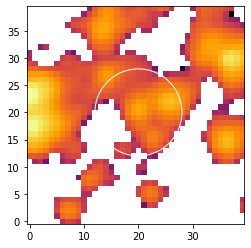

Number of PSF stars: 5


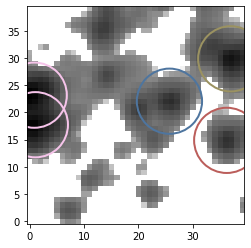

Time taken to fit PSF model: 0.06812180000000012s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
  36.25055 14.849817 3516.7222   1 ...  285.5263 267.51371 225.20891 -82.216143
 1.0463679 17.725472 35245.284   2 ... 250.32212 270.38937 225.24147 -82.212244
0.83974802 23.162428 34579.454   4 ...  250.1155 275.82632 225.23766 -82.211498
 25.713583 22.049288 5863.4088   3 ... 274.98933 274.71318 225.21399  -82.21413
 36.989568 29.849393 12256.992   5 ... 286.26532 282.51329 225.19713 -82.214215



Current star: RRL2
Star's pixel coordinates: (415.4158001587801, 183.80143425453736)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


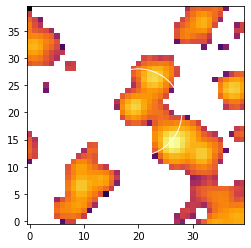

Number of PSF stars: 5


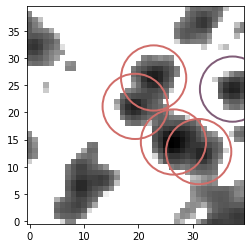

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0763265999999998s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
31.091956 12.780353 6129.7181   1 ... 426.50776 176.58179 225.13677 -82.242348
26.450472 14.546096 6904.3115   2 ... 421.86627 178.34753 225.14006 -82.241649
19.409205 21.098171 2956.0081   3 ...   414.825 184.89961 225.14219 -82.240072
22.805328 26.324778 3214.9506   5 ... 418.22113 190.12621 225.13497 -82.239713
37.316489 24.277569 1559.7534   4 ... 432.73229   188.079 225.12212 -82.241432



Current star: RRL3
Star's pixel coordinates: (606.7275837472373, 295.5581500090886)


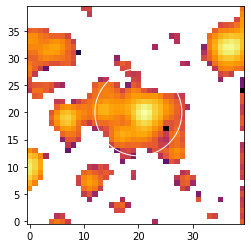

Number of PSF stars: 3


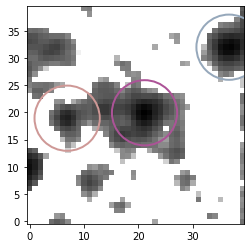

Time taken to fit PSF model: 0.11610029999999938s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.8932984 18.923736 668.52727   1 ... 593.62088 294.48189 224.88431 -82.243179
21.133907 19.921693 2314.2704   2 ... 607.86149 295.47984 224.86943 -82.244456
36.673297 31.986234 1709.4515   3 ... 623.40088 307.54438 224.84514 -82.244377



Current star: RRL4
Star's pixel coordinates: (416.1836082401056, 406.4392677029107)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


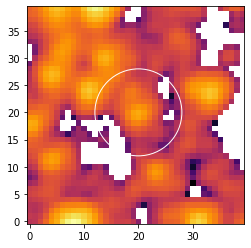

Number of PSF stars: 6


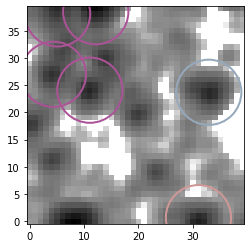

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.09137259999999969s
   x_0       y_0       flux_0   id ...   x_true    y_true      RA       dec    
--------- ---------- --------- --- ... --------- --------- --------- ----------
31.051398 0.62691739 3572.2558   1 ... 427.23501 387.06619  224.9812 -82.214274
 11.07549  24.078706 6155.8939   2 ...  407.2591 410.51797 224.98374 -82.209151
4.3585812  27.003112 5312.7529   4 ... 400.54219 413.44238 224.98823 -82.208093
5.1341857   38.11223 5783.4362   5 ... 401.31779  424.5515 224.97933 -82.206683
12.158526  38.515903 7896.2168   6 ... 408.34213 424.95517  224.9721 -82.207326
32.940138  23.690355 4860.4526   3 ... 429.12375 410.12962 224.96243 -82.211374
13.945968  29.972707 3381.1633   1 ... 410.12958 416.41197 224.97659 -82.208647



Current star: RRL5
Star's pixel coordinates: (478.2457806893284, 324.6495021361123)


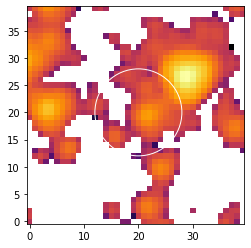

Number of PSF stars: 3


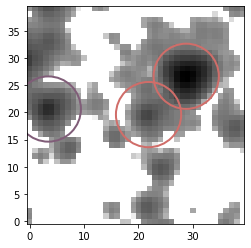

Time taken to fit PSF model: 0.04441510000000015s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.868731 19.588993 3016.0559   1 ... 480.11451  324.2385 224.97499 -82.227935
28.798425 26.634951 41288.129   3 ... 487.04421 331.28445 224.96296  -82.22768
3.4282088 20.612802 5643.4284   2 ... 461.67399  325.2623 224.99249 -82.225967



Current star: RRL6
Star's pixel coordinates: (353.99956143536497, 403.6452858596207)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


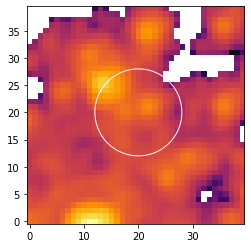

Number of PSF stars: 3


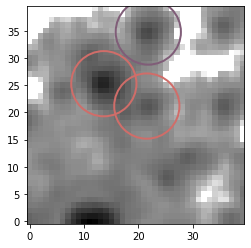

Time taken to fit PSF model: 0.053176000000000556s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.552536 21.157875  4619.218   1 ...  355.5521 404.80316 225.03895 -82.204777
13.642209 25.271844 18770.415   2 ... 347.64177 408.91713 225.04374  -82.20344
21.823256 34.785337 3718.3286   3 ... 355.82282 418.43062  225.0287 -82.202981



Current star: RRL7
Star's pixel coordinates: (159.1340723481958, 617.4171353014702)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


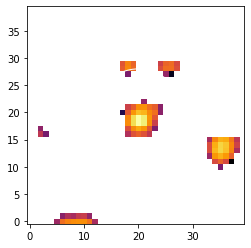

Number of PSF stars: 3


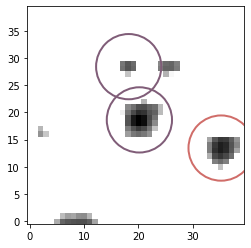

Time taken to fit PSF model: 0.06654170000000015s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.216761 13.432295 1539.2678   1 ... 174.35083 610.84943 225.06642 -82.159198
20.184287 18.615406  2430.742   2 ... 159.31836 616.03254 225.07737 -82.157009
18.219528 28.408981 490.72822   3 ...  157.3536 625.82612 225.07215 -82.155504
25.495328 28.303207 452.66884   1 ...  164.6294 625.72034  225.0651 -82.156242



Current star: RRL8
Star's pixel coordinates: (169.94329105573536, 408.5746286949959)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


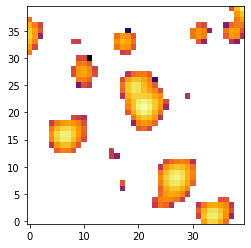

Number of PSF stars: 4


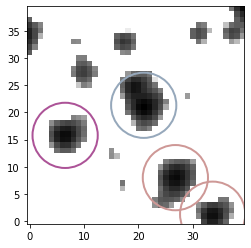

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0679817000000007s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 33.66249 1.2620206 1081.0224   1 ... 183.60578 389.83665 225.21914 -82.189643
 26.80573 7.9892042 2097.7774   2 ... 176.74902 396.56383 225.22093  -82.18806
 6.523621 15.767568 1621.3481   3 ... 156.46691  404.3422 225.23513 -82.184997
20.978914 21.301809 3010.0755   4 ... 170.92221 409.87644 225.21687 -82.185702
19.280125 24.914951 864.83537   1 ... 169.22342 413.48958 225.21589  -82.18505



Current star: RRL9
Star's pixel coordinates: (184.69905049419538, 435.2179715349312)


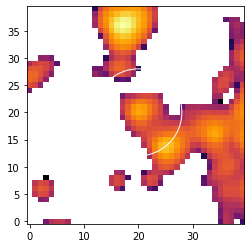

Number of PSF stars: 4


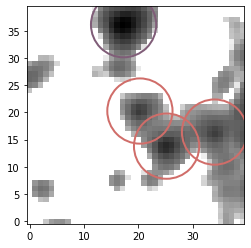

Time taken to fit PSF model: 0.053062399999999954s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
25.187222 13.783632 5766.7239   1 ... 189.88627  429.0016 225.18422 -82.185042
34.008376 16.374615   5274.16   2 ... 198.70743 431.59259 225.17366 -82.185576
20.280491 20.243875 3356.6969   3 ... 184.97954 435.46185  225.1843  -82.18369
17.276012 36.123662 20009.477   4 ... 181.97506 451.34163  225.1756  -82.18127



Current star: RRL10
Star's pixel coordinates: (305.058048336237, 440.56455390718247)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


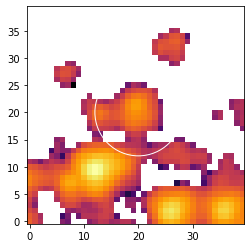

Number of PSF stars: 3


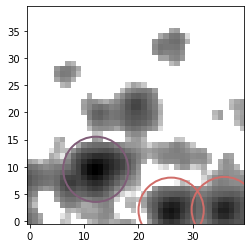

Time taken to fit PSF model: 0.04047270000000047s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
26.022736 1.9959918 9661.3108   1 ... 311.08078 422.56055 225.06976 -82.197979
35.794638 2.1235147 6905.6595   2 ... 320.85269 422.68807 225.06004 -82.198934
12.158356 9.5217606 23642.746   3 ...  297.2164 430.08631  225.0779 -82.195593



Current star: RRL11
Star's pixel coordinates: (278.2836611011982, 227.98314362721047)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


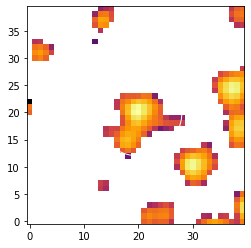

Number of PSF stars: 3


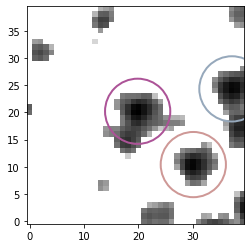

Time taken to fit PSF model: 0.06450839999999936s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.103991 10.392879 2077.4697   1 ... 288.38765 218.37602 225.24234 -82.222986
19.865563 20.194264 3016.1451   2 ... 278.14922 228.17741  225.2452 -82.220655
37.204723 24.321747 2203.3577   3 ... 295.48838 232.30489 225.22506 -82.221836
17.890567 14.901316 839.35636   1 ... 276.17423 222.88446 225.25105 -82.221164



Current star: RRL12
Star's pixel coordinates: (169.9463278097029, 337.57071298030576)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


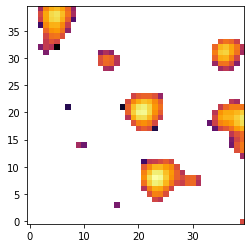

Number of PSF stars: 5


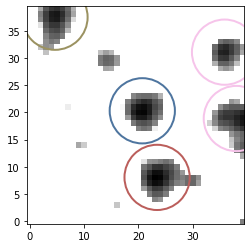

Time taken to fit PSF model: 0.06227270000000118s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
23.441261 8.0363472 2381.6684   1 ... 173.38759 325.60706 225.27643 -82.197189
38.017513 18.868333 1463.4292   2 ... 187.96384 336.43905 225.25414 -82.197202
35.849708 31.074589 983.50735   4 ... 185.79604  348.6453 225.24728 -82.195357
 20.71812  20.28806 2101.6139   3 ... 170.66445 337.85877 225.27008 -82.195283
4.6593648 37.502392 1480.2943   5 ... 154.60569 355.07311 225.27318 -82.191382



Current star: RRL13
Star's pixel coordinates: (337.7026048765051, 290.0922923814303)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


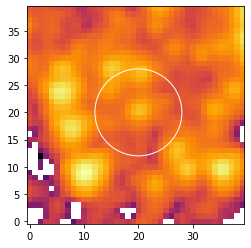

Number of PSF stars: 4


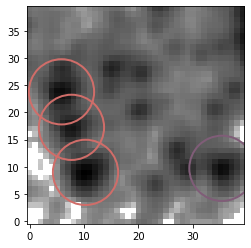

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0619064999999992s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.276867 8.9588548  13336.23   1 ... 327.97947 279.05115 225.15856 -82.218839
7.6900177 17.244669 9224.0212   3 ... 325.39262 287.33696   225.155 -82.217474
5.8577903 23.780134 11513.451   4 ...  323.5604 293.87243   225.152 -82.216419
35.367396 9.7044964   8065.16   2 ...    353.07 279.79679 225.13325  -82.22124



Current star: RRL14
Star's pixel coordinates: (366.85724421913886, 307.6730555307199)


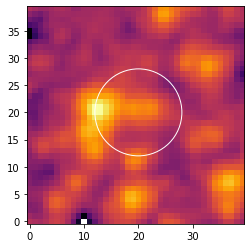

Number of PSF stars: 4


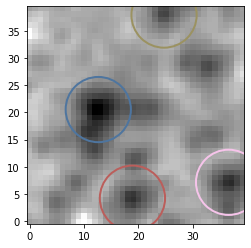

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.09968109999999974s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
18.907698 4.2097053 6932.5147   1 ... 365.76494 291.88276 225.11182  -82.22089
36.597547 7.1303028 8289.0559   2 ... 383.45479 294.80336  225.0922 -82.222262
12.619723 20.515465 30373.871   3 ... 359.47697 308.18852 225.10603 -82.218085
24.719015 37.898699 3134.8197   4 ... 371.57626 325.57175 225.08131 -82.216966
11.195104 15.801378 8018.9096   1 ... 358.05235 303.47443  225.1109 -82.218573



Current star: RRL15
Star's pixel coordinates: (400.2480094535217, 350.18160459389014)


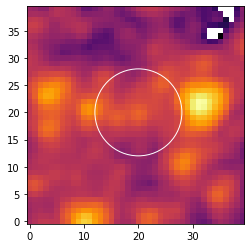

Number of PSF stars: 5


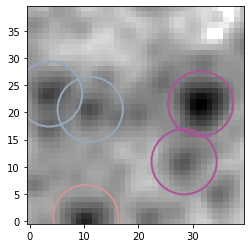

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0644436000000006s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.325156 0.6704896 17736.796   1 ... 390.57317 330.85209 225.05867 -82.218151
 28.41397 10.921885 7475.2032   2 ... 408.66198 341.10349 225.03327 -82.218579
31.422964 21.591849 99268.144   4 ... 411.67097 351.77345 225.02246  -82.21745
11.138367 20.541068 11837.394   3 ... 391.38638 350.72267 225.04327 -82.215574
3.6601084 23.388241  16764.75   5 ... 383.90812 353.56985 225.04856  -82.21445



Current star: RRL16
Star's pixel coordinates: (424.7607661558434, 489.74732899237813)


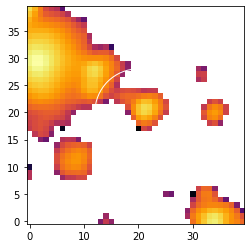

Number of PSF stars: 3


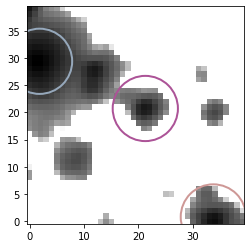

Time taken to fit PSF model: 0.07933900000000094s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
33.787675  0.759746 2884.7599   1 ... 438.54844 470.50707 224.90894 -82.204222
21.272912 20.712856 2392.2229   2 ... 426.03368 490.46019 224.90672 -82.200308
1.8192321   29.3934 11764.699   3 ...    406.58 499.14073 224.91958 -82.197217
11.674724 27.342621 4982.5013   1 ... 416.43549 497.08995 224.91135 -82.198469



Current star: RRL17
Star's pixel coordinates: (395.8376481113387, 403.3777361227561)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


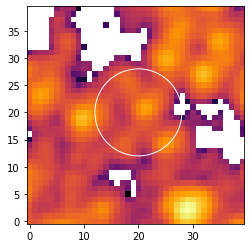

Number of PSF stars: 6


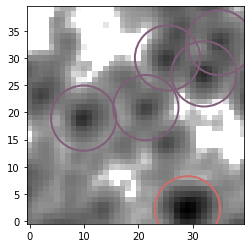

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.08246480000000034s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.046552 2.2606128 21259.455   1 ...  404.8842 385.63835 225.00432 -82.212245
 9.919589 18.938524 4810.3524   2 ... 385.75724 402.31626 225.01098 -82.208113
 21.37872 20.870331  3111.325   3 ... 397.21637 404.24807 224.99825 -82.208993
 32.07549 27.078706 6050.1419   4 ... 407.91314 410.45644 224.98314 -82.209224
25.358581 30.003112  5196.686   5 ... 401.19623 413.38085 224.98763 -82.208166
 34.90992 32.831434 5410.8735   6 ... 410.74757 416.20917 224.97613 -82.208736



Current star: RRL18
Star's pixel coordinates: (489.55596917216167, 381.9867653130465)


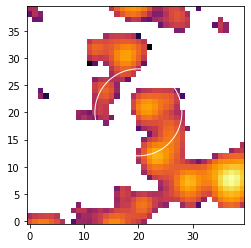

Number of PSF stars: 5


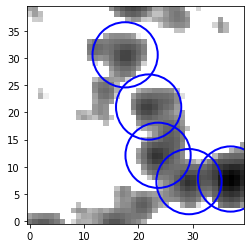

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0920033999999994s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.306964 7.2570504 5524.5375   1 ... 498.86293 369.24382 224.92342 -82.223769
36.950723 7.7385007  16288.43   2 ... 506.50669 369.72527  224.9155 -82.224462
23.619558 12.103942 3749.2526   3 ... 493.17553 374.09071  224.9255 -82.222556
21.882895 20.978751 2483.3586   4 ... 491.43886 382.96552 224.92071 -82.221195
17.560013 30.583435  2411.396   5 ... 487.11598  392.5702 224.91795 -82.219479



Current star: RRL19
Star's pixel coordinates: (624.9152174721671, 473.5524582808641)


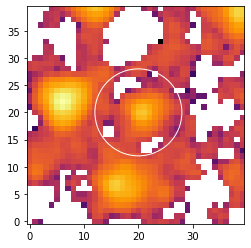

Number of PSF stars: 5


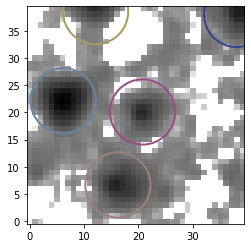

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07038609999999856s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
16.239635 6.6359214 3510.1176   1 ... 621.15485 460.18838 224.73569 -82.223673
20.773086 20.072647 1968.9654   2 ...  625.6883 473.62511 224.72139 -82.222317
6.1813001 22.119077 11421.127   3 ... 611.09652 475.67154 224.73437 -82.220601
12.127161  38.53635 911.96539   4 ... 617.04238 492.08881  224.7165 -82.218983
38.071148 38.020895 2029.5519   5 ... 642.98637 491.57335 224.69113 -82.221612



Current star: RRL20
Star's pixel coordinates: (267.4226597516115, 595.9430294257124)


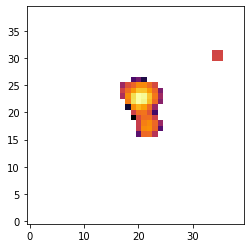

Number of PSF stars: 4


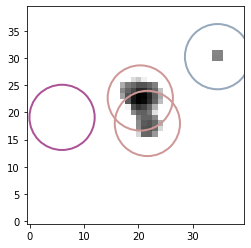

Time taken to fit PSF model: 0.1911752s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.654205  17.95764 2710.9808   1 ... 269.07686 593.90067 224.98582 -82.170882
20.347741 22.643087 3256.2579   3 ...  267.7704 598.58612 224.98369 -82.170125
5.9576996 19.080063 257.83977   2 ... 253.38036 595.02309 225.00042 -82.169173
 34.56031 30.248019 362.12897   4 ... 281.98297 606.19105 224.96418 -82.170518



Current star: RRL21
Star's pixel coordinates: (129.62025760092808, 478.31632180786846)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


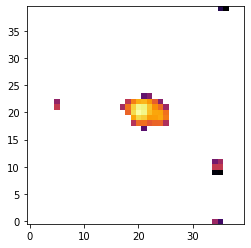

Number of PSF stars: 1


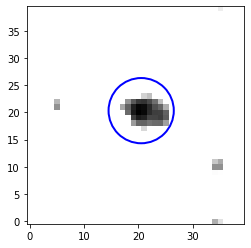

Time taken to fit PSF model: 0.04216180000000058s
   x_0       y_0      flux_0   id ...  x_true    y_true      RA       dec    
--------- --------- --------- --- ... -------- --------- --------- ----------
20.513042 20.315635 2302.4702   1 ... 130.1333 478.63196 225.20643 -82.172454



Current star: RRL23
Star's pixel coordinates: (288.7089913340642, 217.67570763290908)


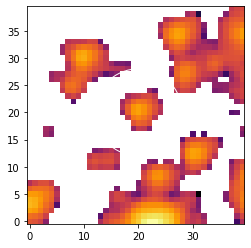

Number of PSF stars: 5


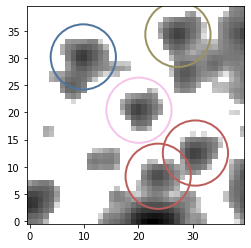

Time taken to fit PSF model: 0.06653719999999907s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
23.637281 8.2427224 2366.6505   1 ... 292.34627 205.91843 225.24764 -82.225043
30.490765 12.515443 2137.2178   2 ... 299.19976 210.19115 225.23772 -82.225158
20.103991 20.392879 1822.4998   3 ... 288.81298 218.06859 225.24215 -82.223069
 9.865563 30.194264 2761.1752   4 ... 278.57455 227.86997 225.24501 -82.220739
27.272296 34.336296 2435.4323   5 ... 295.98129   232.012 225.22479 -82.221925



Current star: RRL24
Star's pixel coordinates: (461.4970441172251, 344.3896586598582)


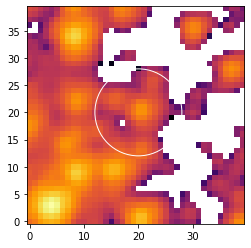

Number of PSF stars: 5


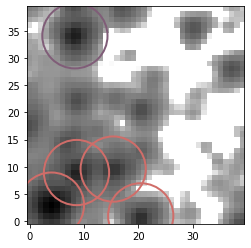

Time taken to fit PSF model: 0.06841819999999998s
   x_0       y_0       flux_0   id ...   x_true    y_true      RA       dec    
--------- ---------- --------- --- ... --------- --------- --------- ----------
20.430613 0.96055426 4536.5792   1 ... 461.92766 325.35021 224.99218  -82.22598
4.0034961  2.9369546 30690.167   2 ... 445.50054 327.32661 225.00697 -82.224084
 8.617468  8.9301648 17350.105   3 ... 450.11451 333.31982 224.99801  -82.22374
15.364163  9.5699622 9258.2021   4 ... 456.86121 333.95962 224.99087 -82.224325
8.3210221  34.082568 10777.992   5 ... 449.81807 358.47223 224.97984 -82.220344



Current star: RRL25
Star's pixel coordinates: (551.5926978375926, 456.4153452499181)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


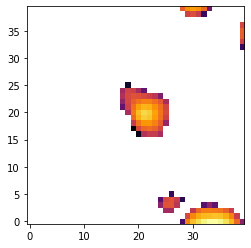

Number of PSF stars: 1


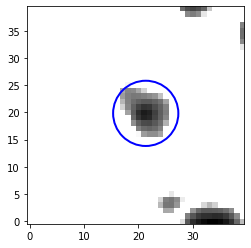

Time taken to fit PSF model: 0.03804759999999874s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
21.350576 19.816748 3100.5435   1 ... 552.94327 456.23209 224.80621 -82.217464



Current star: RRL27
Star's pixel coordinates: (252.89378402679029, 491.0760582680191)


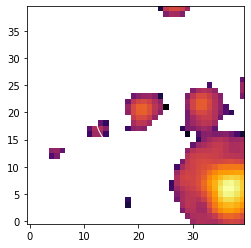

Number of PSF stars: 3


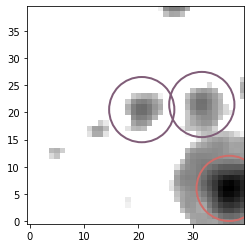

Time taken to fit PSF model: 0.045749900000000565s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.693646 6.0149273 83464.702   1 ... 269.58743 477.09099 225.07066 -82.186559
20.617477 20.503115 2241.3406   2 ... 253.51126 491.57917 225.07586 -82.183022
31.667467 21.442719  2610.336   3 ... 264.56125 492.51878 225.06431 -82.183996



Current star: RRL28
Star's pixel coordinates: (440.01268976990343, 303.9422655888487)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


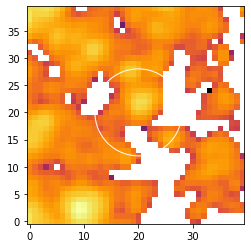

Number of PSF stars: 5


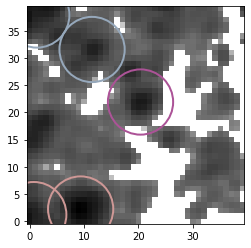

Time taken to fit PSF model: 0.06239619999999846s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
0.7520925 1.1900972  2058.491   1 ... 420.76478 285.13236 225.06245 -82.227268
9.3773031 2.2255294  8194.904   2 ... 429.38999 286.16779 225.05316 -82.227988
20.391917  21.90247 2178.7343   3 ... 440.40461 305.84474  225.0278 -82.226451
11.479406 31.565244 2258.6341   4 ...  431.4921 315.50751 225.02951 -82.224272
1.3164271 37.911463 2884.7706   5 ... 421.32912 321.85373 225.03489 -82.222413



Current star: RRL29
Star's pixel coordinates: (336.42903552565343, 297.45978181433713)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


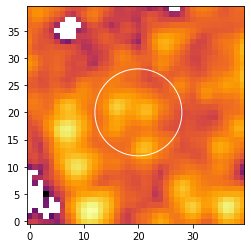

Number of PSF stars: 4


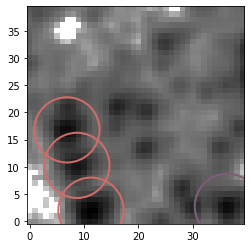

Time taken to fit PSF model: 0.052659600000001916s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.276414 2.0041824 12359.098   1 ... 327.70545 279.46396 225.15852 -82.218756
8.6900177 10.244669 9053.6242   3 ... 325.11905 287.70445   225.155 -82.217398
6.8577903 16.780134 11343.054   4 ... 323.28683 294.23992   225.152 -82.216342
36.367396 2.7044964 7472.4893   2 ... 352.79643 280.16428 225.13325 -82.221164



Current star: RRL30
Star's pixel coordinates: (296.8021209131504, 231.64647114645464)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


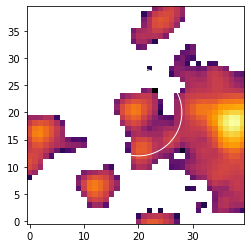

Number of PSF stars: 4


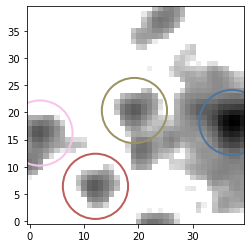

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06915689999999941s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
12.103991 6.3928793 1823.6938   1 ... 288.90611 218.03935 225.24208 -82.223082
1.8908911 16.190375 2488.6478   2 ... 278.69301 227.83685 225.24491 -82.220755
37.210505 18.138098 40449.413   3 ... 314.01263 229.78457 225.20865 -82.224023
19.272296 20.336296 2452.8209   4 ... 296.07442 231.98277 225.22472 -82.221938
31.275027  20.41699 3267.6436   1 ... 308.07715 232.06346 225.21282 -82.223126



Current star: RRL31
Star's pixel coordinates: (246.3816734805099, 454.012517887892)


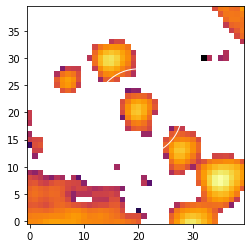

Number of PSF stars: 4


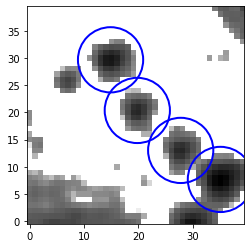

Time taken to fit PSF model: 0.06300989999999729s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.088548 7.6605589  7550.358   1 ... 261.47022 441.67308 225.10458 -82.190485
 27.78413 12.999933 2001.1673   2 ...  254.1658 447.01245 225.10785 -82.189044
19.801787 20.353387 1663.7644   3 ... 246.18346  454.3659 225.11031 -82.187266
14.881021 29.668424 2891.4724   4 ... 241.26269 463.68094 225.10832 -82.185531



Current star: RRL32
Star's pixel coordinates: (286.01503053559094, 267.0791386642338)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


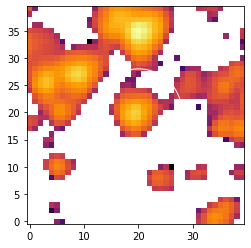

Number of PSF stars: 4


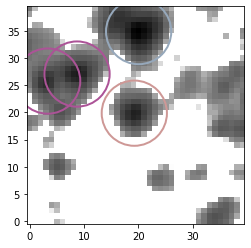

Time taken to fit PSF model: 0.05920070000000166s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 19.25055 19.849817 3717.9065   1 ... 285.26558 266.92896  225.2096 -82.216195
3.3092178 25.754232 5264.1773   2 ... 269.32425 272.83337 225.22095 -82.213816
8.7135826 27.049288 5924.1069   3 ... 274.72861 274.12843 225.21467 -82.214182
20.045744 34.858326 13436.748   4 ... 286.06077 281.93747 225.19776 -82.214271



Current star: RRL34
Star's pixel coordinates: (376.55938767296993, 103.35711198880452)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


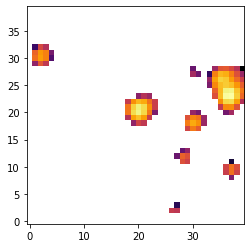

Number of PSF stars: 4


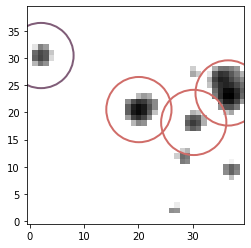

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.0742016999999997s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.182401 18.146159 1250.2766   1 ... 386.74179 101.50327 225.23164 -82.248403
20.095184 20.510622 1850.3266   2 ... 376.65457 103.86773 225.23986  -82.24708
36.502249 23.569334 3025.3394   3 ... 393.06164 106.92645 225.22137 -82.248311
2.0825423 30.454561  707.6354   4 ... 358.64193 113.81167 225.25031 -82.243954
37.122535 9.4428597 542.64814   1 ... 393.68192 92.799972 225.23122 -82.250258
35.083922 26.857386 1031.8227   2 ... 391.64331  110.2145 225.22034 -82.247731



Current star: RRL35
Star's pixel coordinates: (154.94846209079844, 217.08332140270946)


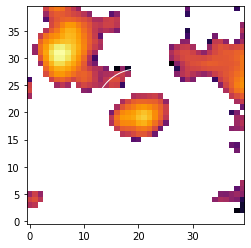

Number of PSF stars: 2


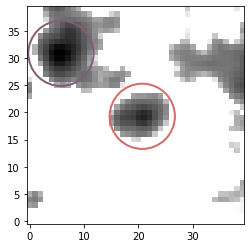

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06551669999999987s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.713972 19.276477 3138.9969   1 ... 155.66243  216.3598 225.37446 -82.209973
5.7535653 30.856831 10300.559   2 ... 140.70203 227.94015 225.38059 -82.206932
17.067181 18.861792 509.49803   1 ... 152.01564 215.94511 225.37835 -82.209663
7.4705152 35.188353 1387.1866   2 ... 142.41898 232.27167 225.37571 -82.206527



Current star: RRL36
Star's pixel coordinates: (415.1715451594607, 260.5341837538059)


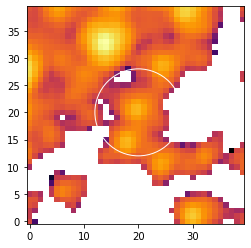

Number of PSF stars: 5


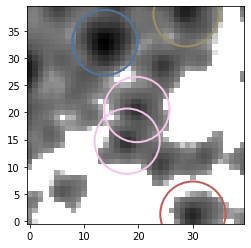

Time taken to fit PSF model: 0.06268969999999996s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.027559 1.2799412 2142.2726   1 ...  425.1991 241.81412 225.08995 -82.233501
17.930222 14.698181   2939.03   2 ... 413.10177 255.23236 225.09203 -82.230503
19.702977 20.520734 3101.0522   3 ... 414.87452 261.05492 225.08599 -82.229901
13.832795 32.849536 16905.913   4 ... 409.00434 273.38372 225.08272 -82.227668
28.772624 38.124292 4007.9478   5 ... 423.94417 278.65848 225.06407  -82.22845



Current star: RRL37
Star's pixel coordinates: (451.3038176788455, 509.37365001989616)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


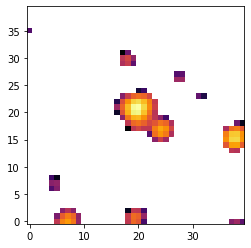

Number of PSF stars: 5


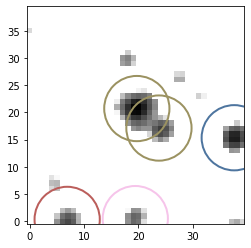

Time taken to fit PSF model: 0.06830549999999747s
   x_0       y_0       flux_0   id ...   x_true    y_true      RA       dec    
--------- ---------- --------- --- ... --------- --------- --------- ----------
6.8980895 0.31036436 755.07077   1 ... 438.20191 489.68401 224.89527 -82.201619
19.431635 0.45477321 540.56301   2 ... 450.73545 489.82842 224.88279 -82.202841
37.632126  15.330989 1131.9095   3 ... 468.93594 504.70464 224.85395  -82.20265
23.782161   17.11384 2351.0029   4 ... 455.08598 506.48749 224.86633 -82.201039
19.712314  20.700271 2975.1264   5 ... 451.01613 510.07392 224.86773 -82.200155



Current star: RRL39
Star's pixel coordinates: (163.99605382852974, 568.8763062466728)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


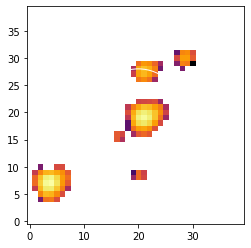

Number of PSF stars: 4


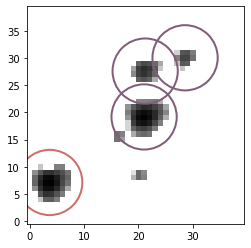

Time taken to fit PSF model: 0.05202159999999978s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
3.6943345 7.1057506 2509.4553   1 ... 147.69039 555.98206 225.13261 -82.163876
21.049951 19.158798 2600.4306   2 ...   165.046  568.0351 225.10679 -82.163995
21.247277 27.594131 1128.7138   3 ... 165.24333 576.47044 225.10044 -82.162887
28.589799 30.037364 725.17968   4 ... 172.58585 578.91367 225.09146 -82.163292



Current star: RRL40
Star's pixel coordinates: (246.16457252595, 215.98867784704058)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


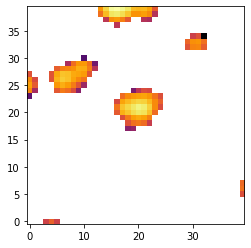

Number of PSF stars: 2


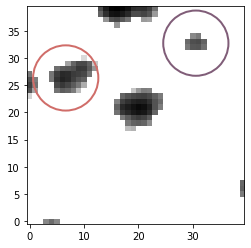

Time taken to fit PSF model: 0.0516652999999998s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.6310397  26.32991 1850.4248   1 ... 232.79561 222.31859  225.2942 -82.216902
30.569191 32.729552 649.48284   2 ... 256.73376 228.71823  225.2659 -82.218443
10.171691 28.321775 618.59167   1 ... 236.33626 224.31045 225.28924 -82.216991



Current star: RRL42
Star's pixel coordinates: (415.47273252101144, 496.7655085177343)


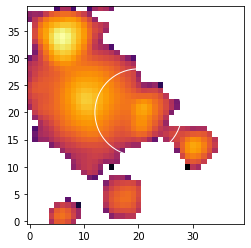

Number of PSF stars: 2


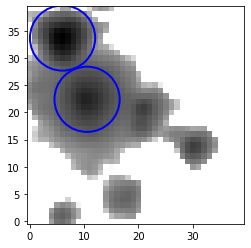

Time taken to fit PSF model: 0.14688260000000142s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
10.558737 22.404747 14393.408   1 ... 406.03147 499.17026  224.9201 -82.197158
6.0491247 33.675392 21949.119   2 ... 401.52186  510.4409 224.91632 -82.195201



Current star: RRL44
Star's pixel coordinates: (788.0450192271643, 144.97387342272174)


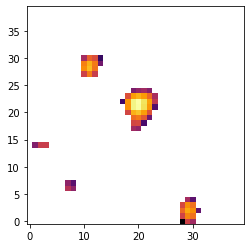

Number of PSF stars: 5


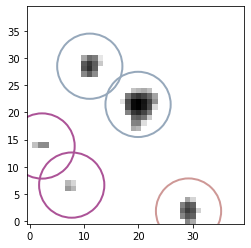

Time taken to fit PSF model: 0.052780899999998354s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 29.22341 1.8462508 825.01935   1 ... 797.26843 126.82012 224.80474  -82.28582
7.7349084 6.6200231 417.51345   2 ... 775.77993  131.5939 224.82269 -82.283054
2.2800458  13.81254 367.99745   3 ... 770.32507 138.78641 224.82284 -82.281549
19.939581 21.463234 2471.9738   4 ...  787.9846 146.43711 224.79957  -82.28227
11.058919 28.489477 949.20375   5 ... 779.10394 153.46335 224.80326 -82.280449



Current star: RRL45
Star's pixel coordinates: (418.0144709517903, 189.06754854066165)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


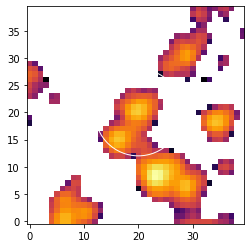

Number of PSF stars: 6


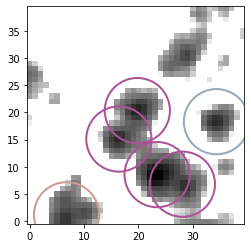

Time taken to fit PSF model: 0.06818789999999808s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
6.7873986  1.159205 2099.8021   1 ... 404.80187 170.22675 225.16294 -82.241033
28.091956 6.7803533 6069.1589   2 ... 426.10643  175.8479 225.13771 -82.242406
23.450472 8.5460961 6843.7523   3 ... 421.46494 177.61364   225.141 -82.241707
16.409205 15.098171 2895.4489   4 ... 414.42368 184.16572 225.14313  -82.24013
19.805328 20.324778 3154.3915   6 ...  417.8198 189.39233 225.13591 -82.239771
34.366832 18.288856 1679.1841   5 ...  432.3813  187.3564   225.123 -82.241494



Current star: RRL46
Star's pixel coordinates: (297.45280083830636, 290.4051071692927)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


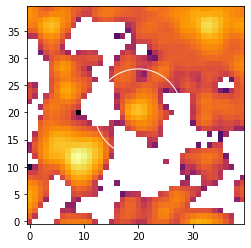

Number of PSF stars: 4


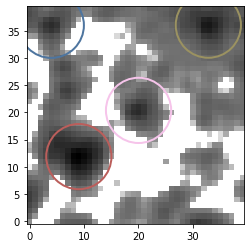

Time taken to fit PSF model: 0.05222099999999941s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 9.045744 11.858326 12911.244   1 ... 286.49854 282.26343 225.19708 -82.214272
20.029834 20.363055 1980.3378   2 ... 297.48264 290.76816 225.17999 -82.214232
3.9773349 36.017981 1820.9667   3 ... 281.43014 306.42309 225.18428 -82.210541
32.868529 36.041214 5584.9985   4 ... 310.32133 306.44632  225.1558 -82.213419



Current star: RRL47
Star's pixel coordinates: (438.9015103539085, 235.39884509689716)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


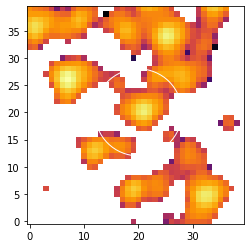

Number of PSF stars: 7


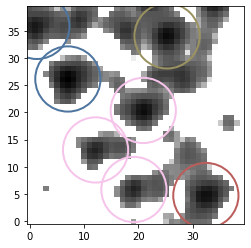

Time taken to fit PSF model: 0.07846749999999858s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
32.411364 4.7023234 2176.1508   1 ... 451.31287 220.10117 225.08011 -82.239003
19.180158 5.8082543 954.79902   2 ... 438.08167  221.2071  225.0924 -82.237538
12.120997  13.08754 1003.9315   3 ... 431.02251 228.48639 225.09401 -82.235862
20.897182 20.349807 2078.5004   4 ... 439.79869 235.74865 225.07998 -82.235765
7.0275491 26.140775 2853.8383   5 ... 425.92906 241.53962 225.08943  -82.23361
 1.327379 35.817075 1449.8154   7 ... 420.22889 251.21592 225.08794 -82.231749
25.278215 34.066806  2596.699   6 ... 444.17973 249.46565 225.06554 -82.234367



Current star: RRL48
Star's pixel coordinates: (286.4067479332806, 194.29294590709367)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


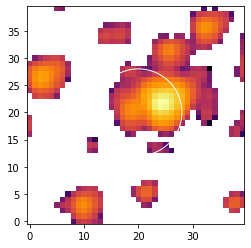

Number of PSF stars: 4


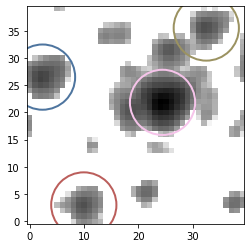

Time taken to fit PSF model: 0.06946350000000123s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.9584139 2.9660954 1938.9313   1 ... 276.36516 177.25904 225.28458 -82.227268
24.442284  21.83978 35484.108   2 ... 290.84903 196.13273 225.25634 -82.226199
 2.365868 26.484263 3542.4772   3 ... 268.77262 200.77721 225.27467 -82.223372
32.490765 35.515443 2318.0315   4 ... 298.89751 209.80839  225.2383 -82.225179
18.759114 20.529705 2922.6005   1 ... 285.16586 194.82265 225.26292 -82.225805



Current star: RRL49
Star's pixel coordinates: (280.2033556190063, 305.3944534286815)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


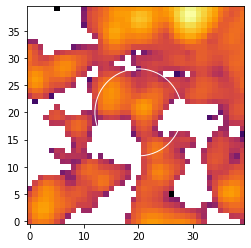

Number of PSF stars: 3


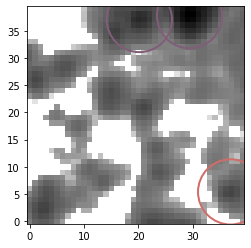

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0556631000000003s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.969207 5.3623064 1835.0435   1 ... 297.17256 290.75676 225.18031 -82.214203
20.176801 37.080556 9503.8134   2 ... 280.38016 322.47501  225.1735 -82.208293
 29.41234 37.792757  34886.65   3 ...  289.6157 323.18721 225.16388 -82.209119



Current star: RRL50
Star's pixel coordinates: (134.40885456040178, 539.1118399959176)


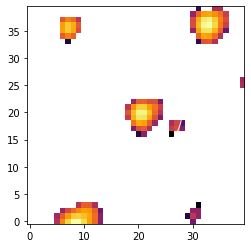

Number of PSF stars: 3


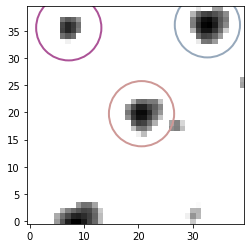

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.0588758000000027s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.579268 19.755463 1991.3649   1 ... 134.98812  538.8673 225.15757 -82.164896
7.1927942 35.555904 789.92253   2 ... 121.60165 554.66774 225.15913 -82.161451
32.694335 36.105751 2350.9176   3 ... 147.10319 555.21759 225.13374  -82.16392



Current star: RRL51
Star's pixel coordinates: (317.1287094931349, 88.3750490161504)


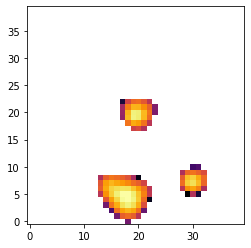

Number of PSF stars: 2


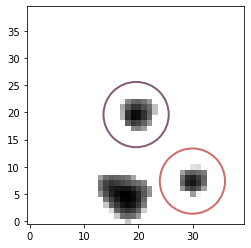

Time taken to fit PSF model: 0.04588510000000312s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.939838 7.3581454 1680.2066   1 ... 327.06855 75.733194 225.30972 -82.245874
19.582233 19.595648 2338.9794   2 ... 316.71094 87.970697 225.31088 -82.243207



Current star: RRL53
Star's pixel coordinates: (478.45240725914323, 352.1904649077255)


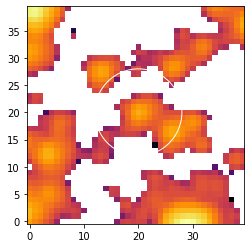

Number of PSF stars: 4


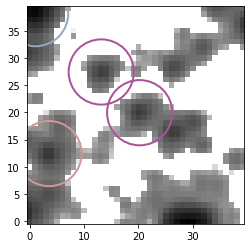

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.0767187000000007s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
 3.5566464 12.417435   3012.44   1 ... 462.00905  344.6079 224.97796 -82.223411
 20.236726 19.937536 2169.9296   2 ... 478.68913   352.128 224.95594  -82.22406
 13.170715 27.428806 1333.6354   3 ... 471.62312 359.61927 224.95743 -82.222355
 1.0923288 38.166983 9800.8363   4 ... 459.54474 370.35745 224.96151 -82.219719
 26.471549 16.473425  2421.646   1 ... 484.92396 348.66389 224.95231 -82.225142
0.88255303 30.992008  515.9117   2 ... 459.33496 363.18247 224.96698 -82.220658



Current star: RRL54
Star's pixel coordinates: (419.6085113153611, 395.2838049537124)


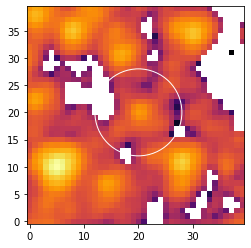

Number of PSF stars: 5


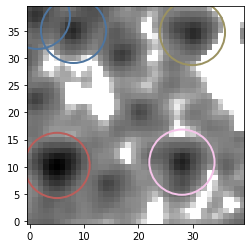

Time taken to fit PSF model: 0.05555280000000096s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
5.0459376 10.237586 23037.194   1 ... 404.65445 385.52139 225.00463 -82.212238
28.009377  10.83807 6309.2999   2 ... 427.61789 386.12188 224.98151 -82.214438
  8.07549 35.078706 5659.0447   3 ...   407.684 410.36251 224.98344 -82.209214
1.4166295 37.664663 3393.0023   5 ... 401.02514 412.94847 224.98812 -82.208207
29.940138 34.690355 4879.0446   4 ... 429.54865 409.97416 224.96212 -82.211437



Current star: RRL55
Star's pixel coordinates: (340.054107325932, 437.92728806945854)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


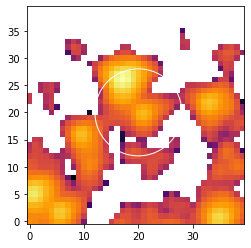

Number of PSF stars: 7


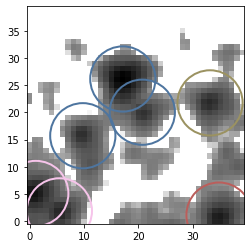

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.07271850000000057s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
34.832066 1.0988804 3686.4255   1 ... 354.88617 419.02617 225.02918 -82.202809
5.4636002 1.8782992 6373.4068   2 ... 325.51771 419.80559 225.05756 -82.199784
1.1248296 5.0791735 6986.8436   3 ... 321.17894 423.00646 225.05949 -82.198924
 9.773394 15.697949 2619.0555   4 ...  329.8275 433.62524 225.04319 -82.198364
20.721984 20.025935 5011.7839   5 ... 340.77609 437.95322 225.02923 -82.198874
17.139371 26.137464 13244.806   7 ... 337.19348 444.06475 225.02828   -82.1977
33.180198 21.742646 2967.1315   6 ... 353.23431 439.66993 225.01569 -82.199883



Current star: RRL56
Star's pixel coordinates: (528.4378205657072, 313.5160269289047)


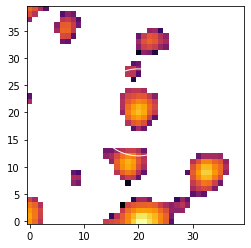

Number of PSF stars: 5


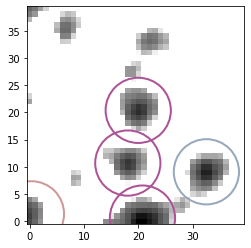

Time taken to fit PSF model: 0.059118899999997865s
   x_0        y_0       flux_0   id ...   x_true    y_true      RA       dec    
---------- ---------- --------- --- ... --------- --------- --------- ----------
0.32181703  1.3326261 756.87001   1 ... 508.75964 294.84865 224.96821 -82.234713
 20.749399 0.54763493 4030.8073   2 ... 529.18722 294.06366 224.94854 -82.236846
 18.054813  10.674256 1786.7645   4 ... 526.49263 304.19028 224.94378 -82.235223
 19.971661  20.369175 2214.9994   5 ... 528.40948  313.8852 224.93476 -82.234114
 32.509898   9.067779 2495.0634   3 ... 540.94772 302.58381 224.93062 -82.236872



Current star: RRL57
Star's pixel coordinates: (324.25069908874224, 229.9097193021136)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


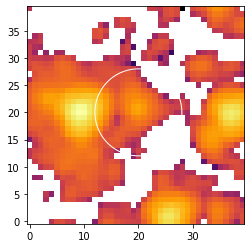

Number of PSF stars: 3


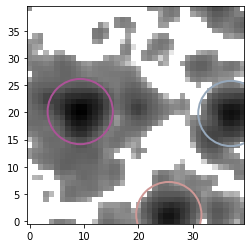

Time taken to fit PSF model: 0.04718639999999752s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
25.597858 1.1959325 12711.468   1 ... 329.84856 211.10565 225.20681 -82.228096
 9.301909 20.148155 45062.423   2 ... 313.55261 230.05787  225.2089  -82.22394
37.012363 19.793156 19046.359   3 ... 341.26306 229.70288 225.18182 -82.226753



Current star: RRL58
Star's pixel coordinates: (330.7074010336705, 432.6404210091759)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


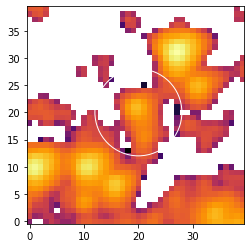

Number of PSF stars: 5


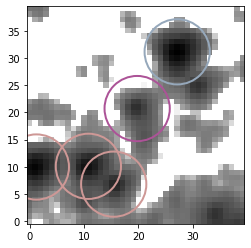

Time taken to fit PSF model: 0.07903420000000239s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
15.462068 6.7971149 6824.1923   1 ... 326.16947 419.43754 225.05719 -82.199898
 1.232775 9.9472873 8802.3193   2 ... 311.94018 422.58771  225.0689 -82.198061
10.802349 10.077391  8548.744   3 ... 321.50975 422.71781 225.05938 -82.198995
19.773394 20.697949 2523.3375   4 ...  330.4808 433.33837 225.04275 -82.198467
27.139371 31.137464 13149.088   5 ... 337.84677 443.77789 225.02785 -82.197803
30.931804 24.815422 1979.0158   1 ...  341.6392 437.45584 225.02874 -82.199026



Current star: RRL60
Star's pixel coordinates: (585.65611335463, 349.820491201665)


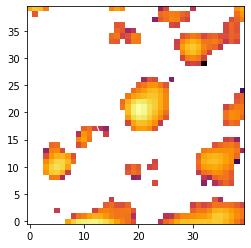

Number of PSF stars: 2


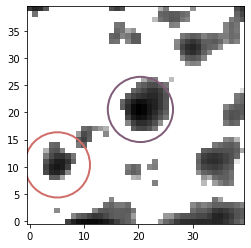

Time taken to fit PSF model: 0.04111230000000177s
   x_0       y_0      flux_0   id ...  x_true    y_true      RA       dec    
--------- --------- --------- --- ... -------- --------- --------- ----------
5.0953911 10.338292 -11.11916   1 ... 570.7515 340.15878 224.87349 -82.234791
20.371384 20.537253 1600.6738   2 ... 586.0275 350.35774 224.85086 -82.234937



Current star: RRL61
Star's pixel coordinates: (200.7828412540975, 347.1371734764915)


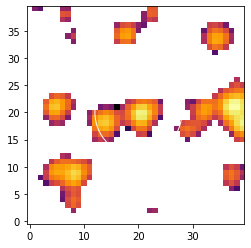

Number of PSF stars: 5


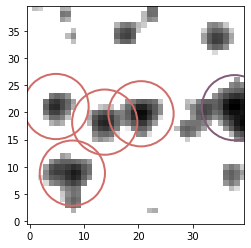

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06978119999999777s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
7.8531793 8.8222599 2378.7846   1 ... 188.63602 335.95943 225.25383 -82.197333
13.808864 18.200672 2009.2466   2 ... 194.59171 345.33784 225.24107 -82.196677
20.485133 19.738828 2589.6357   3 ... 201.26797   346.876 225.23338 -82.197139
4.8497078 21.074589 1293.6676   4 ... 185.63255 348.21176 225.24776 -82.195399
37.676149 20.857607  4116.548   5 ... 218.45899 347.99478 225.21566 -82.198706



Current star: RRL62
Star's pixel coordinates: (432.6522091994011, 186.88678838679715)


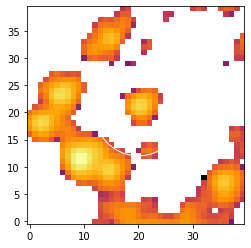

Number of PSF stars: 6


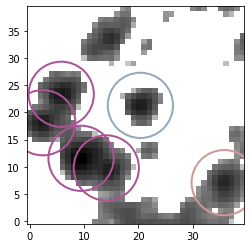

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.18099220000000216s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.786079 7.0697265 1750.1988   1 ... 448.43829 173.95651   225.117 -82.244884
14.091956 9.7803533 5931.0987   2 ... 426.74417 176.66714 225.13647  -82.24236
9.4504716 11.546096 6705.6921   3 ... 422.10268 178.43288 225.13976 -82.241661
2.4062239 18.091382 2758.1831   4 ... 415.05843 184.97817  225.1419 -82.240085
5.8053277 23.324778 3016.3313   6 ... 418.45754 190.21157 225.13468 -82.239725
20.366832 21.288856 1528.7351   5 ... 433.01904 188.17564 225.12177 -82.241448



Current star: RRL63
Star's pixel coordinates: (127.4048292497157, 342.9503273287336)


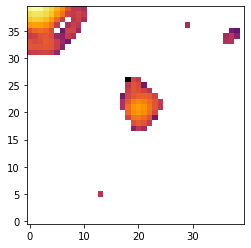

Number of PSF stars: 2


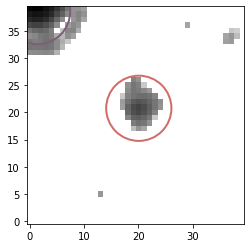

Time taken to fit PSF model: 0.042652900000000216s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.074931 20.748265 2598.4746   1 ... 127.47976 343.69859 225.30817 -82.190186
 1.455963 38.542742 16055.016   2 ... 108.86079 361.49307 225.31332 -82.185951



Current star: RRL64
Star's pixel coordinates: (525.5191836042283, 483.1598740160687)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


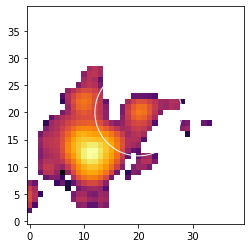

Number of PSF stars: 3


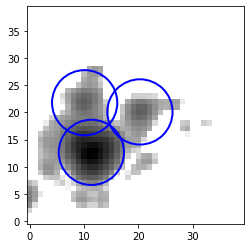

Time taken to fit PSF model: 0.04799990000000065s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.348442 12.643154 50734.985   1 ... 516.86763 475.80303 224.82764  -82.21127
 20.28468 20.079876 2773.8417   2 ... 525.80386 483.23975 224.81337 -82.211156
10.114889  21.77156 5168.1252   3 ... 515.63407 484.93143  224.8222 -82.209923



Current star: RRL65
Star's pixel coordinates: (308.9804300315917, 269.2671384503592)


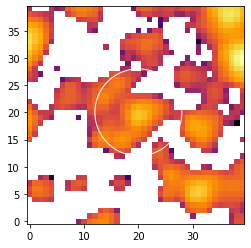

Number of PSF stars: 5


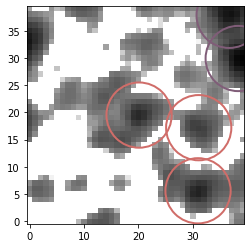

Time taken to fit PSF model: 0.053043699999999916s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
30.973157 5.5722564 3364.2915   1 ... 319.95359 254.83939 225.18431 -82.221271
31.097416 17.182447 1393.4164   2 ... 320.07785 266.44959 225.17563 -82.219733
20.127155 19.498098 2784.0192   3 ... 309.10758 268.76524 225.18474  -82.21833
38.361402 29.907721 7971.9788   4 ... 327.34183 279.17486 225.15909 -82.218759
36.695639 37.846628 5825.0475   5 ... 325.67607 287.11377 225.15489 -82.217532



Current star: RRL66
Star's pixel coordinates: (450.49931475526455, 345.9835647177208)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


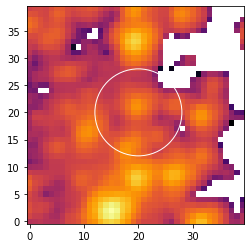

Number of PSF stars: 4


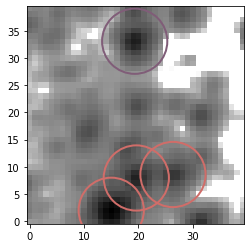

Time taken to fit PSF model: 0.054166900000002016s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
15.004185 1.9852402 28848.066   1 ...  445.5035  327.9688  225.0065 -82.223998
19.617468 7.9301648 16416.591   2 ... 450.11678 333.91373 224.99757 -82.223661
26.364163 8.5699622 8324.6882   3 ... 456.86348 334.55353 224.99043 -82.224245
19.321022 33.082568 10090.072   4 ... 449.82034 359.06613 224.97941 -82.220265



Current star: RRL67
Star's pixel coordinates: (459.75126180462246, 265.6602437517836)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


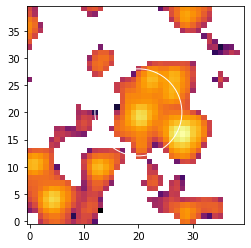

Number of PSF stars: 5


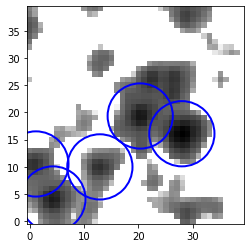

Time taken to fit PSF model: 0.08877870000000243s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
4.2782149 4.0668056 2422.3876   1 ... 444.02948 249.72705  225.0655 -82.234317
12.915876 9.9682448 1243.6212   2 ... 452.66714 255.62849  225.0526 -82.234387
1.1488043 10.506802  1404.979   3 ... 440.90007 256.16705 225.06385 -82.233144
27.997386  16.06721 6379.2927   4 ... 467.74865 261.72745 225.03319 -82.235071
20.337792 19.332073 4066.5712   5 ... 460.08905 264.99232 225.03837 -82.233873
22.789109  25.75762  2596.781   1 ... 462.54037 271.41786 225.03121 -82.233257



Current star: RRL69
Star's pixel coordinates: (292.62120328466284, 424.8655945635616)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


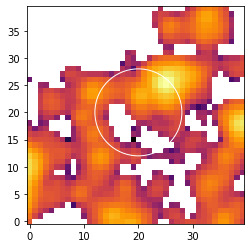

Number of PSF stars: 2


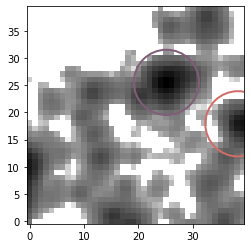

Time taken to fit PSF model: 0.04225399999999979s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
38.312227 17.896066 6020.4765   1 ... 310.93343 422.76166 225.06976 -82.197937
25.158356 25.521761 23007.262   2 ... 297.77956 430.38736 225.07712 -82.195609



Current star: RRL71
Star's pixel coordinates: (226.80987228841224, 353.082643931314)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


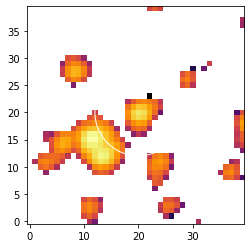

Number of PSF stars: 2


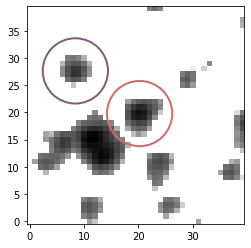

Time taken to fit PSF model: 0.042539500000000174s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.224094 19.780811 1876.1225   1 ... 227.03397 352.86345 225.20365 -82.198913
8.4019601 27.627214   842.244   2 ... 215.21183 360.70986  225.2095 -82.196685



Current star: RRL72
Star's pixel coordinates: (549.8297871492919, 670.6658762232405)


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


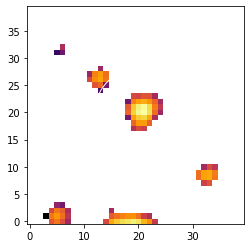

Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


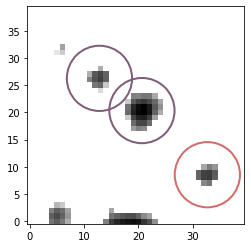

Time taken to fit PSF model: 0.04801769999999905s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
32.685624 8.5302847 786.54201   1 ... 562.51541 659.19616 224.64902 -82.191153
20.650409 20.328016 2182.7905   2 ...  550.4802 670.99389 224.65237 -82.188381
12.839025 26.256895 1006.4531   3 ... 542.66881 676.92277 224.65579 -82.186814



Current star: RRL74
Star's pixel coordinates: (329.0088873457214, 296.08190342319574)


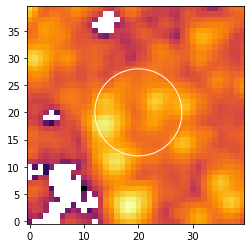

Number of PSF stars: 4


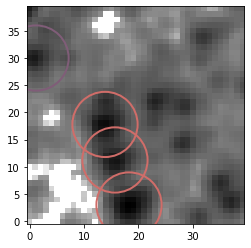

Time taken to fit PSF model: 0.0530932999999969s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
18.276867 2.9588548 13136.629   1 ... 327.28575 279.04076 225.15925 -82.218771
15.690018 11.244669 9340.9889   2 ... 324.69891 287.32657  225.1557 -82.217406
 13.85779 17.780134 11630.419   3 ... 322.86668 293.86204 225.15269 -82.216351
1.1717608 29.992289 4277.7288   4 ... 310.18065 306.07419 225.15621 -82.213455



Current star: RRL75
Star's pixel coordinates: (346.5544034303484, 344.5049261296964)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


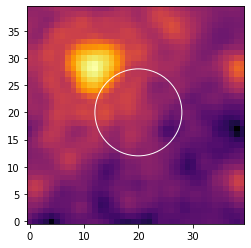

Number of PSF stars: 2


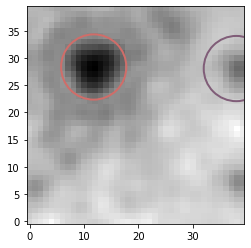

Time taken to fit PSF model: 0.04911459999999934s
   x_0      y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- -------- --------- --- ... --------- --------- --------- ----------
11.780307 28.34382 653680.27   1 ... 338.33471 352.84875 225.09406 -82.210011
38.019614 28.05872 12209.462   2 ... 364.57402 352.56365 225.06839 -82.212661



Current star: RRL76
Star's pixel coordinates: (326.8264290883757, 375.5299202676793)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


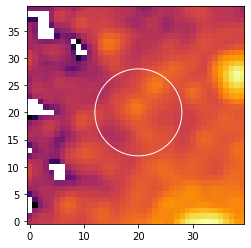

Number of PSF stars: 1


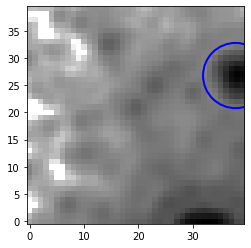

Time taken to fit PSF model: 0.03663129999999981s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
37.893936 26.775057 74532.182   1 ... 344.72036 382.30498 225.06614 -82.206709



Current star: RRL77
Star's pixel coordinates: (379.8219720181463, 435.07736777542783)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


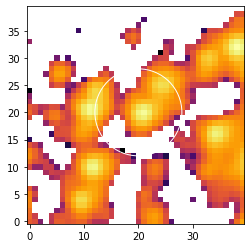

Number of PSF stars: 4


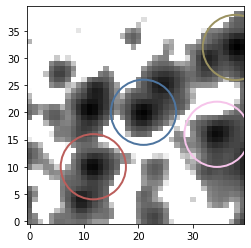

Time taken to fit PSF model: 0.0632552000000004s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
11.711495 9.9981123 3204.3282   1 ... 371.53347 425.07548 225.00833 -82.203654
34.455964 15.962418 3199.4281   2 ... 394.27794 431.03979 224.98153 -82.205115
 20.94234 20.017491 3792.4925   3 ... 380.76431 435.09486 224.99189  -82.20323
37.833389 31.936075 3448.8234   4 ... 397.65536 447.01344  224.9665 -82.203312
24.545372 25.169382 2186.0394   1 ... 384.36734 440.24675 224.98456 -82.202898



Current star: RRL79
Star's pixel coordinates: (264.9535214827199, 429.6078173859463)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


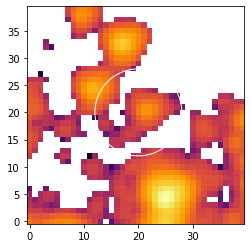

Number of PSF stars: 3


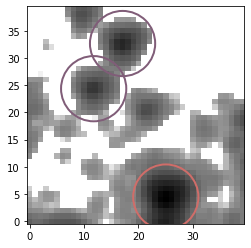

Time taken to fit PSF model: 0.044534800000000985s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
25.041837 4.4205407 47663.375   1 ... 269.99536 414.02836 225.11647 -82.195029
 11.77278 24.355394 3931.7626   2 ...  256.7263 433.96321  225.1149 -82.191043
17.088548 32.660559 6952.9152   3 ... 262.04207 442.26838 225.10358 -82.190463



Current star: RRL80
Star's pixel coordinates: (218.23108169825377, 348.12222558375447)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


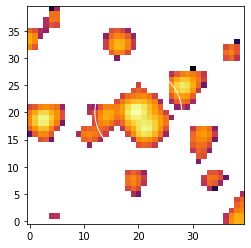

Number of PSF stars: 3


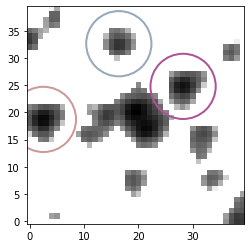

Time taken to fit PSF model: 0.06524890000000028s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
2.5270231 18.703119 2122.5625   1 ...  200.7581 346.82534 225.23392 -82.197095
28.224094 24.780811 1898.4045   2 ... 226.45518 352.90304 225.20419  -82.19885
 16.40196 32.627214 864.52596   3 ... 214.63304 360.74944 225.21004 -82.196622
38.037391 1.0340191  608.6628   1 ... 236.26847 329.15624 225.21201 -82.202999



Current star: RRL81
Star's pixel coordinates: (480.9897237984438, 414.21327004604177)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

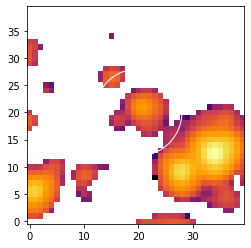

Number of PSF stars: 4


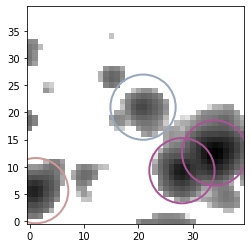

Time taken to fit PSF model: 0.05188049999999578s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
1.1131934 5.5957184 6459.1238   1 ... 462.10292 399.80899 224.93739 -82.216029
28.008515 9.2729875 18577.382   2 ... 488.99824 403.48626  224.9081 -82.218203
34.017028 12.539745 34158.572   3 ... 495.00675 406.75302 224.89976 -82.218361
20.858574 20.957099 2582.4004   4 ...  481.8483 415.17037 224.90662 -82.215929



Current star: RRL82
Star's pixel coordinates: (397.9579100244474, 322.516587732783)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


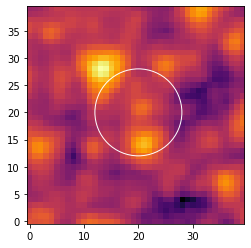

Number of PSF stars: 6


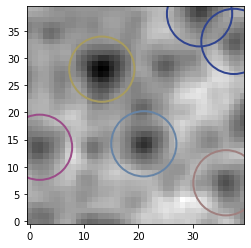

Time taken to fit PSF model: 0.06205750000000165s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
36.104361 7.0462322 2782.5063   1 ... 414.06227 309.56282 225.05111 -82.223334
1.8194002 13.580714 3152.2269   2 ... 379.77731  316.0973 225.08017 -82.219049
21.001318 14.217219 7586.0663   3 ... 398.95923 316.73381 225.06076 -82.220873
 13.27771 27.947136 28540.986   4 ... 391.23562 330.46372  225.0583 -82.218269
37.571125 33.052331 1936.1708   5 ... 415.52903 335.56892 225.03055 -82.220002
31.250986 38.129749  4025.126   6 ...  409.2089 340.64634 225.03307 -82.218694



Current star: RRL83
Star's pixel coordinates: (86.0409395572807, 434.22320731769486)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


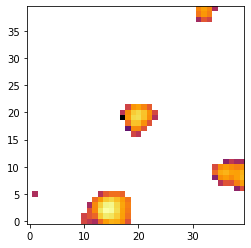

Number of PSF stars: 3


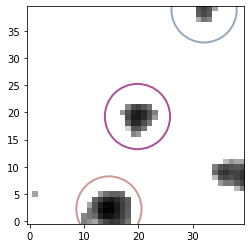

Time taken to fit PSF model: 0.1283128999999974s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
14.577464 2.2286025 3249.1376   1 ... 80.618404 416.45181 225.30057 -82.175799
19.827545 19.236575 1875.2079   2 ... 85.868484 433.45978 225.28294 -82.174057
32.082501 38.858605 480.23255   3 ...  98.12344 453.08181 225.25653 -82.172665



Current star: RRL84
Star's pixel coordinates: (363.7715311300342, 278.3498041001104)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


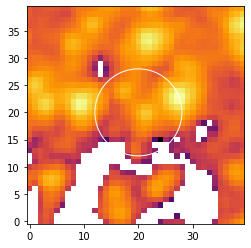

Number of PSF stars: 5


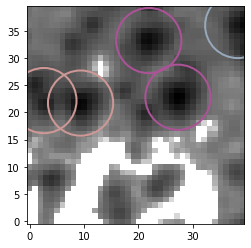

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.06685079999999743s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
2.6200897 22.166893 6660.5397   1 ... 346.39162  280.5167 225.13931 -82.220479
9.3673961 21.704496  8961.932   2 ... 353.13893  280.0543 225.13299 -82.221213
27.278751 22.774731 11232.958   3 ... 371.05028 281.12453 225.11452 -82.222854
21.907698 33.209705 8527.5728   4 ... 365.67923 291.55951 225.11214 -82.220925
38.279651 35.983308 4955.8327   5 ... 382.05118 294.33311 225.09394 -82.222185



Current star: RRL85
Star's pixel coordinates: (401.3689648313201, 442.3464530598656)


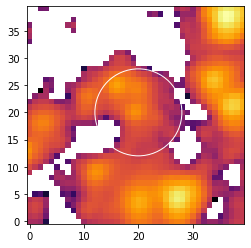

Number of PSF stars: 4


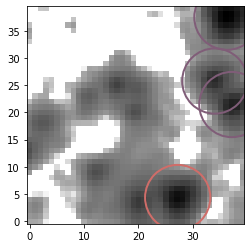

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.07951279999999628s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
 27.23191  4.332653 25133.567   1 ... 408.60087 426.67911 224.97058 -82.207121
37.195735 21.437873 14072.712   2 ...  418.5647 443.78433 224.94822  -82.20582
34.052744 25.762545 13572.146   3 ... 415.42171   448.109 224.94816 -82.204929
36.283167 37.497921 33983.697   4 ... 417.65213 459.84437 224.93737 -82.203578
20.138986 3.5729393 7983.5088   1 ... 401.50795 425.91939 224.97814 -82.206518



Current star: RRL86
Star's pixel coordinates: (369.880117383231, 403.82033128590393)


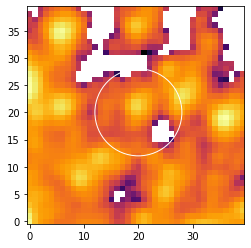

Number of PSF stars: 4


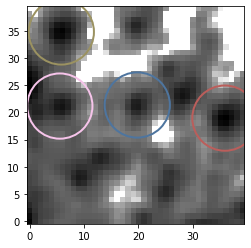

Time taken to fit PSF model: 0.07071089999999458s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
35.919589 18.938524 4175.2981   1 ... 385.79971 402.75886 225.01061 -82.208058
5.5525357 21.157875 4717.7135   2 ... 355.43265 404.97821 225.03894 -82.204742
19.797442 21.356227 1760.1895   3 ... 369.67756 405.17656 225.02475 -82.206132
5.8232559 34.785337 3811.1545   4 ... 355.70337 418.60567 225.02869 -82.202946



Current star: RRL87
Star's pixel coordinates: (529.7890522839114, 272.61492932848626)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


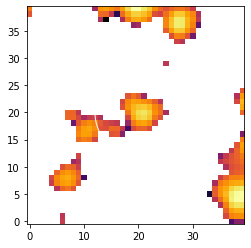

Number of PSF stars: 4


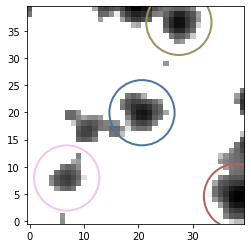

Time taken to fit PSF model: 0.06000250000000307s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
38.044368 4.5534367 2806.3455   1 ... 547.83342 257.16837 224.95717 -82.243637
6.8136354 7.9254519  873.3055   2 ... 516.60269 260.54038 224.98566 -82.240085
20.662214 19.937016 1901.7299   3 ... 530.45127 272.55195  224.9631 -82.239852
27.451225  36.55325 1892.9527   4 ... 537.24028 289.16818 224.94415 -82.238301



Current star: RRL89
Star's pixel coordinates: (287.7875678410861, 396.5315812515347)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


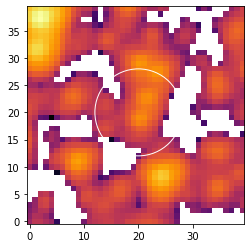

Number of PSF stars: 3


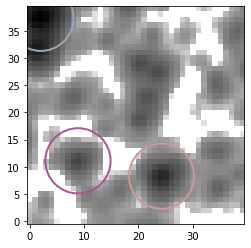

Time taken to fit PSF model: 0.05912909999999982s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
24.259435 8.2542232 9597.7459   1 ...   292.047  384.7858 225.11622 -82.201133
8.8858183 11.089226 2645.1461   2 ... 276.67339 387.62081 225.12927 -82.199222
2.0664247 37.301176 42830.787   3 ... 269.85399 413.83276 225.11675 -82.195041
1.6027413 31.544163 11203.948   1 ... 269.39031 408.07574 225.12143 -82.195764



Current star: RRL90
Star's pixel coordinates: (219.42010934105872, 512.9033986651843)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

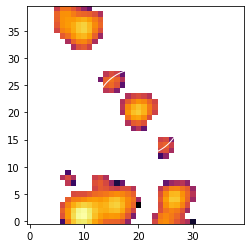

Number of PSF stars: 5


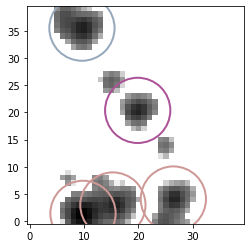

Time taken to fit PSF model: 0.06896270000000015s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.8103363 1.4211254  7713.465   1 ... 209.23045 494.32452 225.11735 -82.178246
15.308651 2.9542516 6896.6975   2 ... 214.72876 495.85765 225.11083 -82.178589
26.429913 4.0588704 2931.4195   3 ... 225.85002 496.96227  225.0991 -82.179549
19.873367 20.364358 2629.6479   4 ... 219.29348 513.26776 225.09361 -82.176716
9.6168358 35.492122 3994.2661   5 ... 209.03695 528.39552 225.09261 -82.173673



Current star: RRL91
Star's pixel coordinates: (210.49612398917634, 252.36001559909747)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


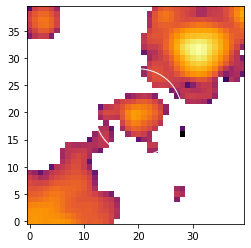

Number of PSF stars: 2


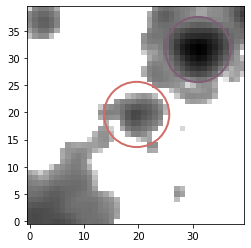

Time taken to fit PSF model: 0.0529042000000004s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
19.677264 19.614326 3441.9336   1 ... 210.17339 251.97434 225.29456 -82.210686
30.962982 31.563527 48109.189   2 ... 221.45911 263.92354 225.27464 -82.210221
2.0710102 1.4133672 5180.2913   1 ... 192.56713 233.77338 225.32531  -82.21135
38.503463 37.800797 1756.9357   2 ... 228.99959 270.16081 225.26262 -82.210143



Current star: RRL92
Star's pixel coordinates: (430.6085772272148, 579.8639863618685)


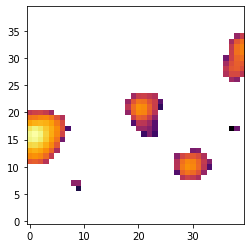

Number of PSF stars: 3


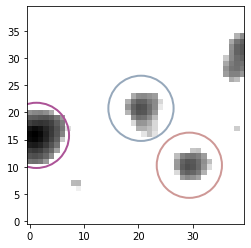

Time taken to fit PSF model: 0.051218600000005665s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
29.372918 10.271043 1927.7436   1 ... 439.98149 570.13503 224.83484  -82.19101
 1.243994 15.766138 15806.399   2 ... 411.85257 575.63012 224.85859 -82.187489
20.476871 20.743054 2073.5054   3 ... 431.08545 580.60704 224.83599 -82.188725



Current star: RRL93
Star's pixel coordinates: (460.1258599499282, 87.39634804363118)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


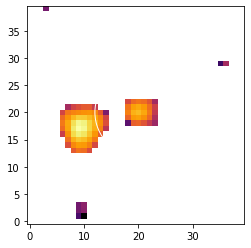

Number of PSF stars: 2


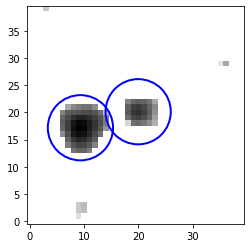

Time taken to fit PSF model: 0.037252099999996346s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
9.3374272  17.17103 7316.2707   1 ... 449.46329 84.567378 225.18208 -82.256925
19.958571 20.115849 2018.0572   2 ... 460.08443 87.512197 225.16937 -82.257592



Current star: RRL94
Star's pixel coordinates: (367.0575298402516, 469.18829852992957)


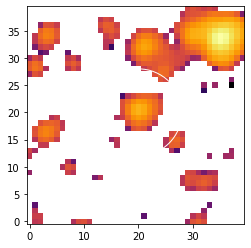

Number of PSF stars: 3


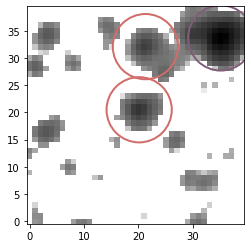

Time taken to fit PSF model: 0.055299499999996726s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.141031 20.476243 2151.0552   1 ... 367.19856 469.66454 224.97997 -82.197256
21.289989 32.091255  1856.142   2 ... 368.34752 481.27955 224.97034 -82.195815
35.152468 33.691309 20031.023   3 ...    382.21 482.87961  224.9555 -82.196977
30.214974 34.356671 2011.3908   1 ...  377.2725 483.54497 224.95989 -82.196398



Current star: RRL95
Star's pixel coordinates: (723.6849270995224, 242.67292762526318)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


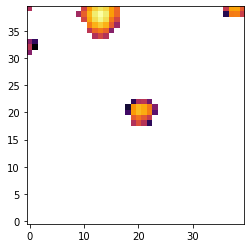

Number of PSF stars: 2


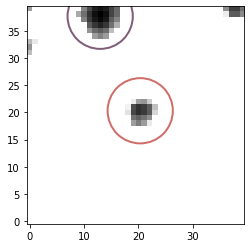

Time taken to fit PSF model: 0.054227400000002035s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
20.335557  20.29273 1336.5789   1 ... 724.02048 242.96566 224.79241 -82.262994
12.970039 37.677182 3224.9893   2 ... 716.65497 260.35011 224.78698 -82.259933
37.572432 38.405052 514.46079   1 ... 741.25736 261.07798 224.76193 -82.262267



Current star: RRL96
Star's pixel coordinates: (327.72055082720516, 347.0989918405718)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

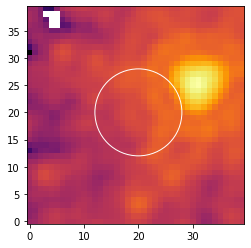

Number of PSF stars: 1


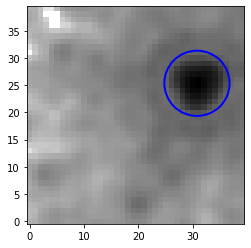

Time taken to fit PSF model: 0.03374619999999595s
   x_0      y_0     flux_0   id ...   x_true    y_true      RA       dec    
--------- -------- -------- --- ... --------- --------- --------- ----------
30.780307 25.34382 653271.6   1 ... 338.50086 352.44281 225.09419 -82.210082



Current star: RRL97
Star's pixel coordinates: (353.7250547428218, 220.5210218970188)


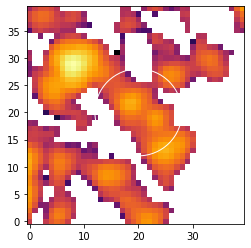

Number of PSF stars: 3


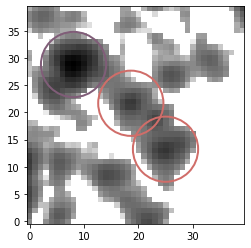

Time taken to fit PSF model: 0.06250380000000177s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA       dec    
--------- --------- --------- --- ... --------- --------- --------- ----------
24.989348 13.226583 4048.2765   1 ...  358.7144  213.7476 225.17636 -82.230624
18.606345 21.674123 3127.6952   2 ...  352.3314 222.19514 225.17643  -82.22886
8.0742679 28.802524 21534.975   3 ... 341.79932 229.32355 225.18157 -82.226857



Current star: RRL98
Star's pixel coordinates: (454.8908207089036, 614.9565323726745)


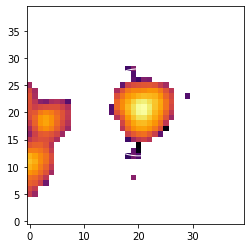

Number of PSF stars: 3


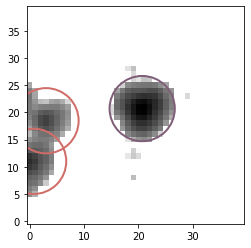

Time taken to fit PSF model: 0.051038500000004206s
   x_0        y_0      flux_0   id ...   x_true    y_true      RA       dec    
---------- --------- --------- --- ... --------- --------- --------- ----------
0.72563684 10.983611 6008.7573   1 ... 435.61646 605.94014 224.81308 -82.185776
 3.0058212 18.459518 5646.3345   2 ... 437.89664 613.41605 224.80539 -82.184999
 20.697608 20.696114 38314.369   3 ... 455.58843 615.65265 224.78631 -82.186448





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [4]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

tbl_CC.write('data/reference/CVSGC_'+cluster+'_reduced_readable.txt', format='csv', overwrite=True)

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

#xlim_hi = image_m.shape[1] - 30
#ylim_hi = image_m.shape[0] - 30
#xlim_lo = 30
#ylim_lo = 30
#print(xlim_hi, ylim_hi)

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print("Star's pixel coordinates: ({0}, {1})".format(pix_crd[0], pix_crd[1]))
        
        #if pix_crd[0] >= xlim_hi or pix_crd[0] <= xlim_lo or pix_crd[1] >= ylim_hi or pix_crd[1] <= ylim_lo:
        #    print('Star not in channel')
        #    not_ch_list.append(star)
            

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        #print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        
        try:
            pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        except TypeError:
            print('No sources detected')
            continue
            
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        #plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
#master_stars

In [5]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/IC4499/masterlist_RRL0_3p6um.txt
id_master    x_0        y_0      x_true    y_true      RA       dec    
--------- ---------- --------- --------- --------- --------- ----------
        0   36.42682 14.750808 966.87672 243.94323 225.20886 -82.216178
        1   1.204548 17.297522 931.65445 246.48994  225.2416 -82.212309
        2 0.96902109 22.916424 931.41892 252.10884 225.23767 -82.211537
        3  25.860344 21.987918 956.31024 251.18034 225.21389 -82.214156
        4  37.174182 29.689124 967.62408 258.88154 225.19707 -82.214263


### Main photometry cell:

In [ ]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    if star in starlist:

        print('Current star: RRL{}'.format(star+1))

        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        try:
            master_table = Table.read(master_file, format='ascii.csv')
        except FileNotFoundError:
            print('Star not in master list for this channel')
            continue

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
            
            print('Epoch: ', epoch)
            
            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:  
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])

            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.savefig('images/'+cluster+'/problem_stars/RRL'+str(star+1)+'_'+channel+'_e'+str(epoch)+'.png')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###

                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)

                if sources_PSF == None:
                    print('No sources found initially :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)

                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('No sources found after reducing detection threshold :(')          

                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')

                    epoch += 1
                    continue

                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                #plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                #plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_'+channel+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err', 'flux_unc'])

                mag_med = np.median(PSF_table['mag_err'])
                flux_med = np.median(PSF_table['flux_unc'])

                print('Median mag error:  {0}\nMedian flux error: {1}'.format(mag_med, flux_med))

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)

            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL{} not detected in this epoch :('.format(star+1))

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue

            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###

        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###

        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))

        for i in range(len(master_table_f)):

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv

        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)

        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()


        print('\n\n')

        #break

        ###   END OF IF IN STARLIST CHECK   ###


    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    

    #if star == 1:
    #    break


    ###   END OF STAR LOOP   ###

save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [10]:
file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

good_types = ['RR0', 'RR1', 'RR01', 'RR2']
remove_list = []
for i in range(len(tbl_CC)):
    if np.ma.is_masked(tbl_CC['period'][i]) == True:
        remove_list.append(i)
    elif tbl_CC['type'][i] not in good_types:
        remove_list.append(i)

tbl_CC.remove_rows(remove_list)
tbl_CC['id_new'] = np.arange(len(tbl_CC))

big_table_ch1 = Table()

for star in range(len(tbl_CC)):
    
    load_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
    if os.path.isfile(load_name) == True:
        pickle_in = open(load_name, 'rb')
        single_table = pickle.load(pickle_in)

        big_table_ch1 = vstack([big_table_ch1, single_table])
    
#big_table_ch1.show_in_notebook()
save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_ch1, pickle_out)
pickle_out.close()

In [20]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch1 = pickle.load(pickle_in)

big_table_ch1.show_in_notebook()

In [24]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
pickle_in = open(load_name, 'rb')
big_table_ch2 = pickle.load(pickle_in)

big_table_ch2.show_in_notebook()

### Run this to add Welch-Stetson variability index to huge_table:
I wouldn't run this if I were you

In [17]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq              I_var       
  str10       int32       float64  ...      float64             float64      
--------- -------------- --------- ... ------------------ -------------------
     RRL0              2  346.6729 ... 111.97863867238496   55.13041941431693
     RRL1              1 346.68512 ...  66.55609315558254 -10.376788119417483
     RRL2              1 346.67961 ...  190.2430713894951    14.7638680268631
     RRL3 -2.1474836e+09       nan ...                nan                 nan
     RRL4              0 346.65532 ... 20.148470438756682                 nan

### Plotting light curves:

RRc
Mags:  [9.988149244043907 9.708422725958487 9.87862637192268 9.894423924806066
 9.931587319705306 9.838191932891387 10.039798720817295 9.96132333801254
 10.069133152930315 9.821158352296315 9.879802025717645 9.875856890825654]
Errs:  [0.03729090942911797 0.034972719064750406 0.03890480962121854
 0.040900665974532444 0.04023568645385369 0.03554302086912955
 0.0421288370926176 0.03687012899813111 0.04492266897963562
 0.03686168817875667 0.03724912654002405 0.037285499358864896]
Phase:  [0.16137963350047357 0.31792205324745737 0.46516009941115044
 0.6227024946419988 0.7623809330107179 0.9193001560342964
 0.06554794716066681 0.23837835725862533 0.3691129492945038
 0.5273438468866516 0.6833140539820306 0.8498920097481459]


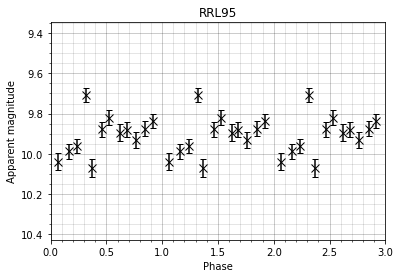

Chi squared:   72.73556508042937
IQR:           0.11771187916970227
von Neumann:   0.44936897757422223


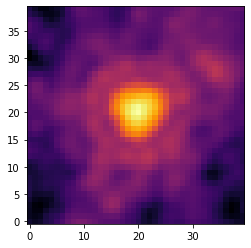

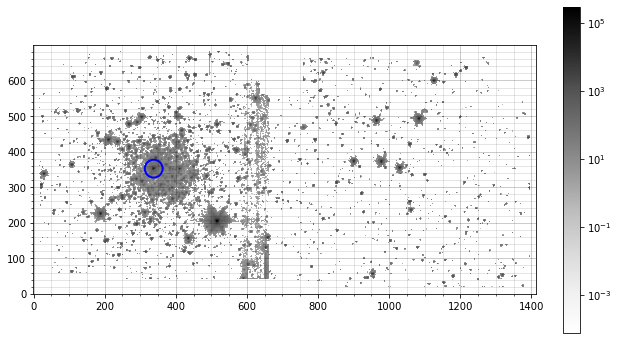

In [55]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 95
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period'][star_id]
        print('RRd')
    else:
        P = df_CC['period'][star_id]
        print('Something else')

    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###
    
    if cluster == 'PAL5':

        vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

        if os.path.isfile(vot_name) == True:

            votable = parse_single_table(vot_name)
            data_vot = votable.array

            temp = [i / P for i in data_vot['obs_time']]
            phase_vot = temp - np.floor(temp)

            mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
            phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

            plt.plot(phases_vot, mags_vot, 'kx')
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.title('Gaia curve for RRL'+str(star_id))
            #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
            plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

In [23]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthese_ch1 = []
checkthese_ch2 = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthese_ch1.append(t_CC['id_new'][i])
    if t_CC['mean_mag_ch2'][i] < 15.4:
        checkthese_ch2.append(t_CC['id_new'][i])

print(checkthese_ch1)
print(checkthese_ch2)
t_CC.show_in_notebook()

[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]
[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 68, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]


### Running GLOESS:

In [6]:
file_CC = 'data/reference/CVSGC_IC4499_readable.txt'
df_ic = pd.read_csv(file_CC, sep=',', header=0)

df_ic

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0      1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1      2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2      3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3      4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4      5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..   ...           ...           ...   ...     ...          ...        ...   
130  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
131  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
132  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
133  172  15h00m16.85s  -82d11m33.7s    R0  0.0558       19.300       0.30   
134  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

    colour   type  
0        V    RR0  
1        V    RR0  
2        V    RR0  
3        V    RR0  
4        V    RR0  
..     ...    ...  
130      V    RR2  
131      V    RR0  
132      V    RR2  
133      V  SXPHE  
134      V    RR1  

[135 rows x 9 columns]

RRab
Channel 1 mags:  [15.18725731 15.20584364 15.2243765  15.25732516 15.16272216 15.20512543
 15.18447421 15.2361551  15.26422389 15.16305999 15.20286252 15.13405936]
Channel 2 mags:  [15.10686771 15.09892358 15.12916537 15.18171141 15.14509713 15.08338314
 15.13654477 15.17354168 15.08997703 15.11078462 15.02322579 15.08552245] 

RRL1 ---- Period = 0.6099 days
------------------------------------------------------
12 12
<[3.6]> = 15.205    std dev = 0.019     amplitude = 0.058


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.114    std dev = 0.027     amplitude = 0.087
<[3.6] - [4.5]> = 0.092    std dev = 0.018     amplitude = 0.057


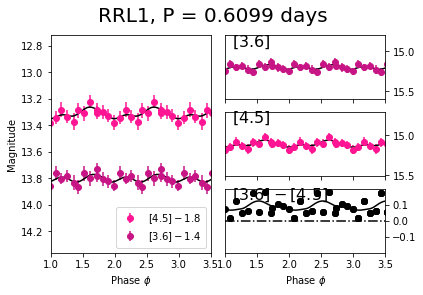

[0.004847262934903451]
new error ch1: 0.004847262934903451
new error ch2: 0.0072797135502399675



RRab
Channel 1 mags:  [15.88541167 16.05769977 16.07177089 16.09764974 16.18633865 16.2814333
 16.22701549 15.94814217 16.00825338 16.09921674 16.08682154 16.1001556 ]
Channel 2 mags:  [16.06883936 99.         15.99904832 16.26282197 16.15486921 16.08615357
 16.28201236 16.19239225 16.10889582 16.11827646 16.05145948 15.97921278] 

RRL2 ---- Period = 0.4936 days
------------------------------------------------------
12 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.102    std dev = 0.086     amplitude = 0.265


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.135    std dev = 0.062     amplitude = 0.202
Channels don't have the same number of measurements, so colour curve couldn't be plotted


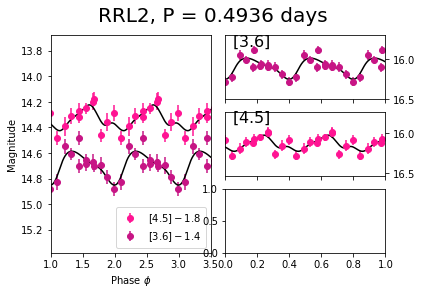

[0.004847262934903451, 0.02205767930696941]
new error ch1: 0.02205767930696941
new error ch2: 0.017552141856224394



RRab
Channel 1 mags:  [16.08996703 16.11011432 16.33861892 16.30359418 16.33947924 15.97145306
 15.9829214  15.99151626 16.08253132 99.         16.0945453  16.13183081]
Channel 2 mags:  [16.02047438 99.         16.08872279 16.16113679 16.1840448  15.97889293
 15.8823258  15.92557494 99.         15.99926547 16.14238768 16.18593872] 

RRL3 ---- Period = 0.4832 days
------------------------------------------------------
11 10


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.115    std dev = 0.104     amplitude = 0.325


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.037    std dev = 0.096     amplitude = 0.274
Channels don't have the same number of measurements, so colour curve couldn't be plotted


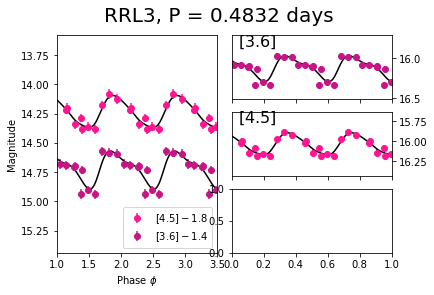

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044]
new error ch1: 0.028319874287772044
new error ch2: 0.02497713111702254



RRab
Channel 1 mags:  [15.03846826 15.12800334 15.11691327 15.0816746  15.05800803 15.14660989
 15.00249509 15.16576687 15.20177701 15.14991964 15.12656771 15.12895152]
Channel 2 mags:  [15.10611861 15.05707381 15.07729154 15.06790133 15.12777991 15.06084186
 15.08578485 15.04846005 15.14349808 15.06734915 15.11863831 15.03242969] 

RRL4 ---- Period = 0.6236 days
------------------------------------------------------
12 12
<[3.6]> = 15.114    std dev = 0.030     amplitude = 0.097


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.083    std dev = 0.012     amplitude = 0.039
<[3.6] - [4.5]> = 0.031    std dev = 0.025     amplitude = 0.085


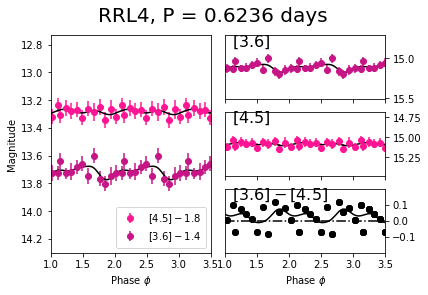

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894]
new error ch1: 0.00806652142730894
new error ch2: 0.00326443101621147



RRab
Channel 1 mags:  [16.13439069 16.10108242 16.14297008 15.96948918 15.99213546 15.82084467
 15.96744635 15.98479197 16.14344632 16.00087971 16.20537668 16.19934915]
Channel 2 mags:  [16.10363544 16.0814847  16.05916679 15.90034833 15.97785929 15.94649645
 15.85969522 16.03404726 16.00593559 16.07821259 16.1437814  16.04289137] 

RRL5 ---- Period = 0.5569 days
------------------------------------------------------
12 12
<[3.6]> = 16.030    std dev = 0.087     amplitude = 0.271


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.010    std dev = 0.061     amplitude = 0.182
<[3.6] - [4.5]> = 0.020    std dev = 0.042     amplitude = 0.144


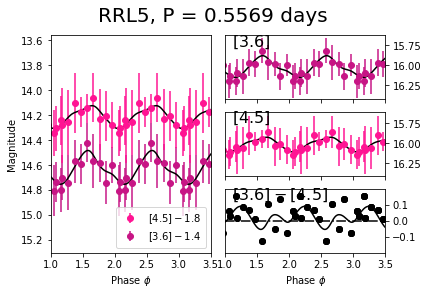

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176]
new error ch1: 0.022566225564902176
new error ch2: 0.015208129521128525



RRab
Channel 1 mags:  [15.6869195  15.73290343 15.83995838 15.85700838 99.         15.88497754
 99.         15.81127177 15.78112317 15.72530566 15.7432209  15.68831746]
Channel 2 mags:  [15.67899142 15.67088622 15.71670269 99.         15.77192128 99.
 99.         99.         15.66259092 15.73247247 15.72889944 15.75852342] 

RRL6 ---- Period = 0.5779 days
------------------------------------------------------
10 8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.801    std dev = 0.063     amplitude = 0.179
<[4.5]> = 15.717    std dev = 0.031     amplitude = 0.103


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Channels don't have the same number of measurements, so colour curve couldn't be plotted


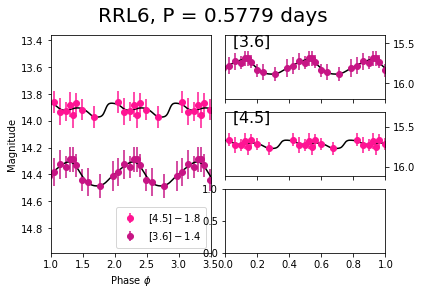

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523]
new error ch1: 0.016354688284023523
new error ch2: 0.010547159332867392



RRab
Channel 1 mags:  [15.95559097 15.67021373 16.01646958 15.93302003 15.9874559  15.64174126
 15.74567976 15.63849563 15.7897407  15.62167335 15.93015702 16.0707946 ]
Channel 2 mags:  [99.         99.         99.         99.         99.         99.
 15.7905455  15.7526059  99.         15.63992023 15.79764138 99.        ] 

RRL7 ---- Period = 0.6179 days
------------------------------------------------------
12 4


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.820    std dev = 0.092     amplitude = 0.256
<[4.5]> = 15.830    std dev = 0.107     amplitude = 0.354
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


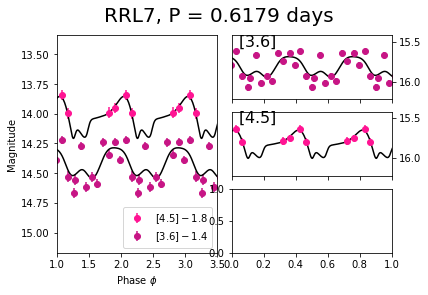

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446]
new error ch1: 0.021307906023734446
new error ch2: 0.05103889015521645



RRd
Channel 1 mags:  [15.82198823 15.90844379 15.89425384 16.00879137 99.         15.75326828
 15.97606081 16.97941237 15.89399337 15.8373441  16.56847136 15.96217553]
Channel 2 mags:  [15.78724102 15.91587326 15.87244284 15.93898533 15.88031125 15.73124514
 15.68397305 15.7341828  15.77993107 15.90538342 99.         15.78170217] 

RRL8 ---- Period = 0.3674 days
------------------------------------------------------
11 11


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.053    std dev = 0.163     amplitude = 0.480


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.816    std dev = 0.075     amplitude = 0.219
<[3.6] - [4.5]> = 0.237    std dev = 0.158     amplitude = 0.540


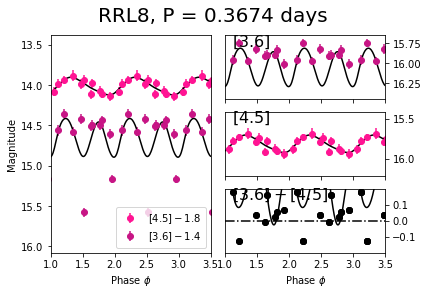

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088]
new error ch1: 0.04178438451200088
new error ch2: 0.019073310143958175



RRab
Channel 1 mags:  [15.90919773 15.83086191 15.86801284 15.71206129 15.74244345 15.65133956
 15.54932481 15.69675432 15.71818672 15.64519707 15.59478953 15.71694141]
Channel 2 mags:  [15.84789418 15.74419376 15.67793867 15.66355599 15.63420794 15.50785011
 15.55968517 15.53462327 15.64589698 15.61612879 15.70828673 15.62401232] 

RRL9 ---- Period = 0.7096 days
------------------------------------------------------
12 12
<[3.6]> = 15.718    std dev = 0.080     amplitude = 0.236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.654    std dev = 0.075     amplitude = 0.236
<[3.6] - [4.5]> = 0.064    std dev = 0.034     amplitude = 0.108


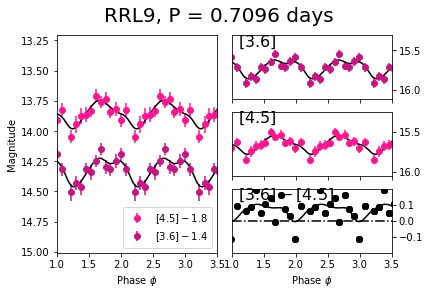

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741]
new error ch1: 0.0196692504600741
new error ch2: 0.019705055925177756



RRd
Channel 1 mags:  [13.37235711 13.34391963 13.41756779 13.34427907 13.40339712 13.33128333
 13.41160285 13.40443931 13.44366968 13.40884305 13.2863655  13.32669772]
Channel 2 mags:  [13.38644343 13.43637733 13.37529688 13.41448045 13.4189897  15.86435199
 16.08499681 13.35337889 13.34546096 15.80924934 15.69382664 15.80829736] 

RRL10 ---- Period = 0.3532 days
------------------------------------------------------
12 12
<[3.6]> = 13.374    std dev = 0.026     amplitude = 0.078


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.748    std dev = 0.414     amplitude = 1.429
<[3.6] - [4.5]> = -0.374    std dev = 0.429     amplitude = 1.469


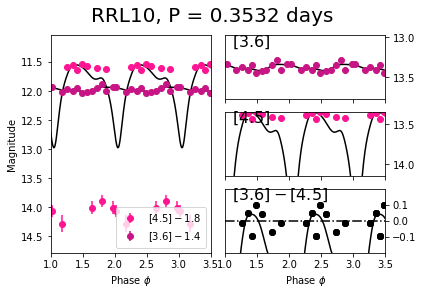

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743]
new error ch1: 0.006515890110432743
new error ch2: 0.11906936675403805



RRab
Channel 1 mags:  [15.75817388 15.72535474 15.73864063 15.80943113 15.85092704 15.89813438
 15.87847135 15.90463321 15.84941483 15.7598148  15.731949   15.68129407]
Channel 2 mags:  [15.69420247 15.60498307 15.72668309 15.64916908 15.77147605 15.85691876
 15.81121888 15.79176175 15.73427925 15.7175583  15.68787449 15.65678855] 

RRL11 ---- Period = 0.6315 days
------------------------------------------------------
12 12
<[3.6]> = 15.801    std dev = 0.064     amplitude = 0.175


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.728    std dev = 0.057     amplitude = 0.166
<[3.6] - [4.5]> = 0.073    std dev = 0.016     amplitude = 0.052


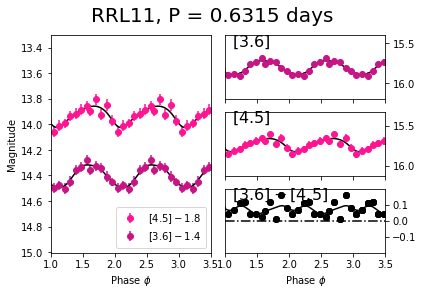

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329]
new error ch1: 0.014595259382162329
new error ch2: 0.01382719556600446



RRab
Channel 1 mags:  [15.97034625 15.95621248 15.98723901 15.91155494 15.93471648 15.94618696
 15.84159963 15.98726273 16.01211639 16.14925145 15.98975872 15.91862064]
Channel 2 mags:  [15.90879524 15.94323608 15.89020614 15.89099223 15.72446898 15.82921832
 15.86021582 15.91187948 16.00208338 15.9547324  16.00025816 15.97872521] 

RRL12 ---- Period = 0.5948 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.052     amplitude = 0.173


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.065     amplitude = 0.191
<[3.6] - [4.5]> = 0.065    std dev = 0.036     amplitude = 0.123


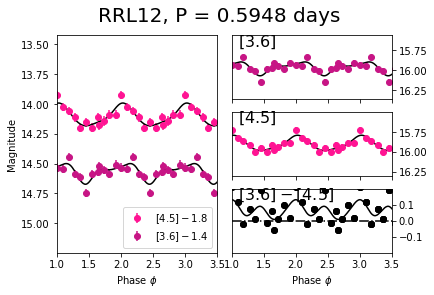

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757]
new error ch1: 0.014451822395278757
new error ch2: 0.01591443826410292



RRab
Channel 1 mags:  [14.88588356 14.73542426 14.81038698 14.84089065 14.72500696 14.87029811
 14.74955213 14.81274457 14.84388797 14.70087455 14.8260878  14.78612647]
Channel 2 mags:  [14.80937114 14.83080337 14.88079987 14.84129552 14.78706505 14.81465202
 14.82438925 14.80432065 14.84939735 14.79955276 14.78880802 14.82067788] 

RRL13 ---- Period = 0.5115 days
------------------------------------------------------
12 12
<[3.6]> = 14.797    std dev = 0.005     amplitude = 0.017


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.819    std dev = 0.011     amplitude = 0.037
<[3.6] - [4.5]> = -0.023    std dev = 0.010     amplitude = 0.038


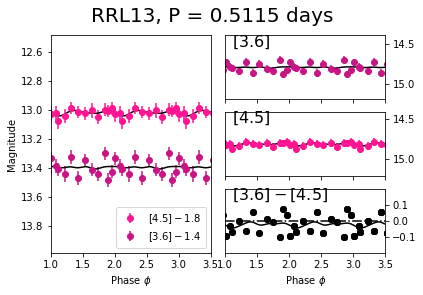

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033]
new error ch1: 0.0014061721388597033
new error ch2: 0.003100529507387891



RRab
Channel 1 mags:  [13.18019053 13.32804635 13.32939663 13.28481753 13.24368089 13.23450672
 13.27458426 13.20637142 13.18295186 13.12954929 13.16408429 13.20907368]
Channel 2 mags:  [13.27669576 13.17077554 13.24019799 13.22735973 13.19154172 13.26627739
 13.21328156 13.20338743 13.21825681 13.19970529 13.23512345 13.21851633] 

RRL14 ---- Period = 0.5001 days
------------------------------------------------------
12 12
<[3.6]> = 13.231    std dev = 0.038     amplitude = 0.118


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.221    std dev = 0.006     amplitude = 0.024
<[3.6] - [4.5]> = 0.009    std dev = 0.038     amplitude = 0.123


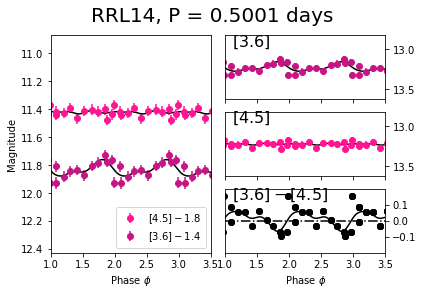

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748]
new error ch1: 0.009799137513023748
new error ch2: 0.001985101008191196



RRab
Channel 1 mags:  [14.55979446 14.47102331 14.47435393 14.48937219 14.5263371  14.42666465
 14.50823712 14.45377744 14.49210356 14.39113734 14.44604428 14.42668881]
Channel 2 mags:  [14.49325247 14.43641406 14.40626087 14.41229083 14.46275943 14.42252599
 14.40392736 14.43995    14.51188756 14.49629615 14.3212111  14.45840415] 

RRL15 ---- Period = 0.5968 days
------------------------------------------------------
12 12
<[3.6]> = 14.472    std dev = 0.018     amplitude = 0.060


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.439    std dev = 0.016     amplitude = 0.055
<[3.6] - [4.5]> = 0.033    std dev = 0.029     amplitude = 0.096


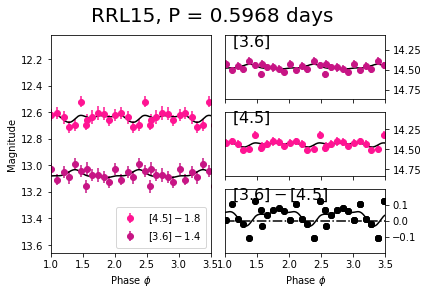

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761]
new error ch1: 0.005033996998902761
new error ch2: 0.004555657736409646



RRab
Channel 1 mags:  [15.77053705 15.7674642  15.93960602 15.93376283 15.8298617  15.95564944
 16.01310218 15.98082186 15.86551851 15.79486066 15.7203626  15.80394838]
Channel 2 mags:  [15.77987166 15.78652817 15.84657042 15.86402428 15.94194193 15.98751186
 16.02012993 15.97123529 15.90302303 15.86030602 15.83476132 15.77183569] 

RRL16 ---- Period = 0.5773 days
------------------------------------------------------
12 12
<[3.6]> = 15.877    std dev = 0.078     amplitude = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.891    std dev = 0.077     amplitude = 0.221
<[3.6] - [4.5]> = -0.014    std dev = 0.039     amplitude = 0.131


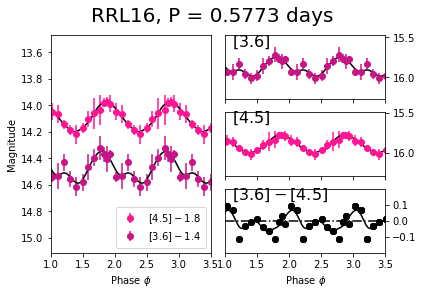

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957]
new error ch1: 0.02016614829715957
new error ch2: 0.01840078415101794



RRab
Channel 1 mags:  [99.         15.70130647 15.95722927 15.8817414  99.         99.
 15.76196144 15.77563737 99.         15.81073479 99.         99.        ]
Channel 2 mags:  [15.79233372 99.         99.         99.         99.         15.77113872
 99.         15.8063084  15.77134057 15.7652823  15.80567104 15.77465599] 

RRL17 ---- Period = 0.5005 days
------------------------------------------------------
6 7


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.812    std dev = 0.051     amplitude = 0.144
<[4.5]> = 15.781    std dev = 0.009     amplitude = 0.031

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


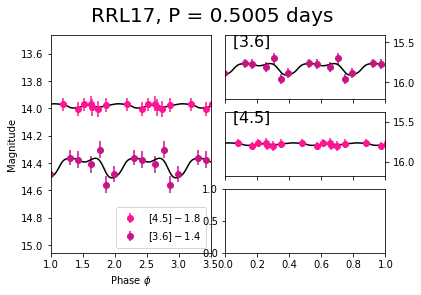

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085]
new error ch1: 0.016990364836735085
new error ch2: 0.003364086803873276



RRd
Channel 1 mags:  [16.07735712 16.11826434 16.13060525 16.02444404 16.00208707 16.00887491
 15.89116834 16.11006869 16.01978221 16.16745173 16.07040323 15.93443986]
Channel 2 mags:  [16.02632857 16.00067997 16.18326305 16.09985978 15.94018681 15.94886527
 15.92988911 15.95008401 16.05612984 16.08631557 15.97723875 15.98897822] 

RRL18 ---- Period = 0.3523 days
------------------------------------------------------
12 12
<[3.6]> = 16.034    std dev = 0.057     amplitude = 0.164


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.010    std dev = 0.053     amplitude = 0.158
<[3.6] - [4.5]> = 0.024    std dev = 0.031     amplitude = 0.104


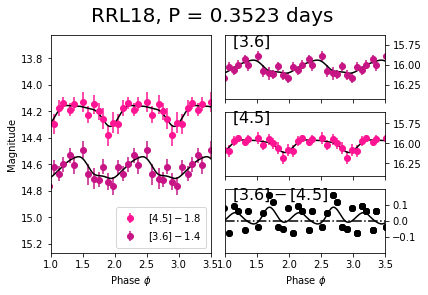

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019]
new error ch1: 0.013631998508266019
new error ch2: 0.013131574007811805



RRab
Channel 1 mags:  [16.28592702 16.11200813 15.99539348 15.99243616 15.89638505 16.02035399
 15.97722936 16.0586189  16.09434212 15.91782652 16.20195101 15.9586876 ]
Channel 2 mags:  [16.25743206 16.23255992 16.19655849 15.98278664 15.94133423 15.86636645
 15.87186192 16.0420035  15.94753548 15.96033159 16.24355203 16.20032595] 

RRL19 ---- Period = 0.5306 days
------------------------------------------------------
12 12
<[3.6]> = 16.028    std dev = 0.060     amplitude = 0.191


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.029    std dev = 0.120     amplitude = 0.358
<[3.6] - [4.5]> = -0.001    std dev = 0.096     amplitude = 0.285


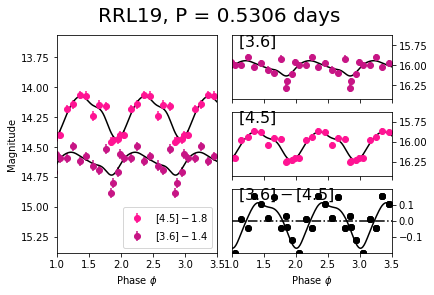

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143]
new error ch1: 0.015935665113477143
new error ch2: 0.02979787873573425



RRab
Channel 1 mags:  [15.76265842 15.84605193 15.68654859 15.76859427 15.65332493 15.87566882
 15.75941451 15.95880647 16.13019289 15.97649264 15.98498934 15.97177793]
Channel 2 mags:  [17.20397359 16.9963746  17.21233183 17.01461615 17.01134934 17.10038591
 16.98383462 17.11023256 16.90226702 17.0363812  16.96471578 17.19546   ] 

RRL20 ---- Period = 0.6482 days
------------------------------------------------------
12 12
<[3.6]> = 15.857    std dev = 0.116     amplitude = 0.333


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 17.055    std dev = 0.042     amplitude = 0.144
<[3.6] - [4.5]> = -1.198    std dev = 0.140     amplitude = 0.396


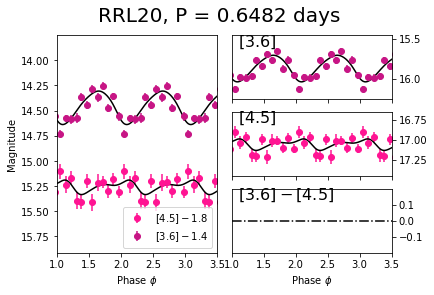

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311]
new error ch1: 0.02773086380982311
new error ch2: 0.01202060095063325



RRd
Channel 1 mags:  [16.02175483 16.15185426 16.23075773 16.31684879 16.14484101 16.13918879
 16.03642926 16.20688523 16.1260963  16.13222399 16.12050561 16.19629984]
Channel 2 mags:  [16.2256924  16.16353843 16.12564975 16.05284932 16.082998   16.05311107
 16.01030431 16.08816214 15.9611192  16.03224731 16.11163984 16.17860122] 

RRL21 ---- Period = 0.3533 days
------------------------------------------------------
12 12
<[3.6]> = 16.142    std dev = 0.046     amplitude = 0.148


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.085    std dev = 0.022     amplitude = 0.070
<[3.6] - [4.5]> = 0.057    std dev = 0.059     amplitude = 0.188


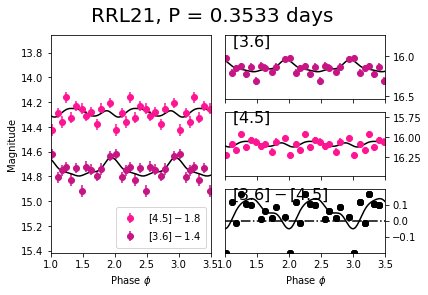

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366]
new error ch1: 0.012358852875342366
new error ch2: 0.005847356093989416



RRab
Channel 1 mags:  [16.45002514 16.46959824 16.5568807  16.50527014 16.46246809 16.53885453
 16.43709203 16.48629472 16.462642   16.36308576 16.54256596 16.65217959]
Channel 2 mags:  [] 

RRL22 ---- Period = 0.6747 days
------------------------------------------------------
12 0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.495    std dev = 0.033     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


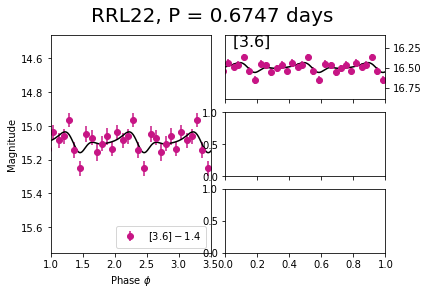

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352]
new error ch1: 0.010256040424446352
new error ch2: nan



RRab
Channel 1 mags:  [16.17617653 16.14464581 16.08683989 15.95471747 15.91349249 16.0009054
 15.92318156 16.0817096  16.10294641 16.04404961 16.14824257 16.10517928]
Channel 2 mags:  [16.06883456 16.16183955 15.92836989 15.78866142 15.91900852 15.89024843
 15.87562451 15.8894838  16.05359232 16.12969128 16.14605557 16.06212166] 

RRL23 ---- Period = 0.5077 days
------------------------------------------------------
12 12
<[3.6]> = 16.039    std dev = 0.072 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.969    std dev = 0.097     amplitude = 0.266
<[3.6] - [4.5]> = 0.069    std dev = 0.034     amplitude = 0.110


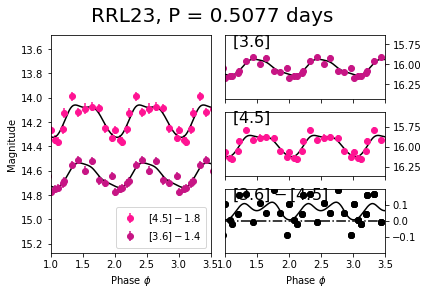

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719]
new error ch1: 0.01684938417110719
new error ch2: 0.022165795155387524



RRab
Channel 1 mags:  [14.8847494  14.9666936  14.97961563 14.97920038 14.90737873 14.83589214
 15.03393276 14.92089428 14.9733732  14.86985507 14.88393348 14.87844624]
Channel 2 mags:  [14.93303741 15.0516185  15.04715282 15.0127763  14.9231139  14.97989896
 15.04189793 14.99941915 14.9992765  14.9579707  14.87633788 14.87610443] 

RRL24 ---- Period = 0.5166 days
------------------------------------------------------
12 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.967    std dev = 0.030     amplitude = 0.093
<[3.6] - [4.5]> = -0.037    std dev = 0.019     amplitude = 0.055


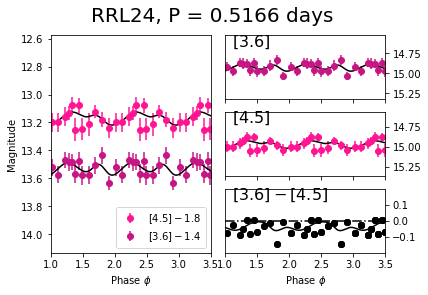

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941]
new error ch1: 0.007415836084004941
new error ch2: 0.007766485209049841



RRab
Channel 1 mags:  [99.         15.69962267 15.74928898 15.66606431 99.         15.63511391
 15.73881422 15.63284513 15.76485288 15.77880757 15.62817766 15.85986978]
Channel 2 mags:  [15.83536925 15.92512779 15.70846746 15.63030661 15.64733412 15.61779887
 15.62536458 15.69908229 15.67434028 15.74049154 15.75355783 15.83573223] 

RRL25 ---- Period = 0.6022 days
------------------------------------

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.714    std dev = 0.076     amplitude = 0.225
Channels don't have the same number of measurements, so colour curve couldn't be plotted


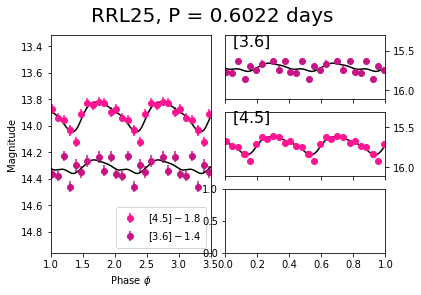

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076]
new error ch1: 0.009366173836899076
new error ch2: 0.018726279838450804



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.95387412 15.98772608 15.9083224  15.96346818 15.91580267 15.99468315
 16.18493836 16.25093491 16.24635668 15.89840978 15.95293189 16.00145894]
Channel 2 mags:  [15.94410141 16.01662856 15.99125039 15.98910978 15.95392355 15.96398587
 15.93084424 16.10884465 16.19582228 16.02511219 15.98065287 15.89302687] 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.002    std dev = 0.057     amplitude = 0.174
<[3.6] - [4.5]> = 0.034    std dev = 0.075     amplitude = 0.228


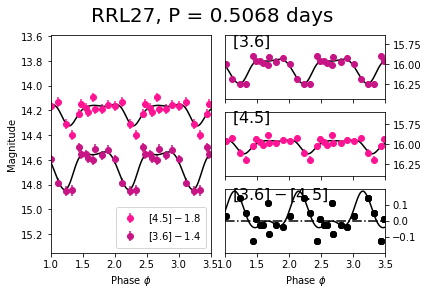

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902]
new error ch1: 0.02541749839552902
new error ch2: 0.014474421280207187



RRab
Channel 1 mags:  [15.80539588 15.91929083 15.94117517 15.90097661 15.84581074 15.92257027
 15.94668713 15.99402248 16.13890585 16.05448468 15.77856847 15.77623458]
Channel 2 mags:  [15.85470314 15.96238249 15.91514627 15.86514319 15.8829444  15.94214037
 16.00471124 16.01811458 16.17799514 16.04375263 15.85612752 15.81141378] 

RRL28 ---- Period = 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.947    std dev = 0.074     amplitude = 0.219
<[3.6] - [4.5]> = -0.018    std dev = 0.019     amplitude = 0.063


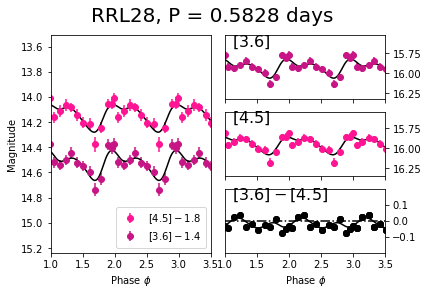

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207]
new error ch1: 0.019855329762522207
new error ch2: 0.018234192063667127



RRc
Channel 1 mags:  [14.39806078 14.4305327  14.41957899 14.36853694 14.45592866 14.41440762
 14.40360084 14.38278301 14.33073535 14.43899982 14.41227786 14.44705357]
Channel 2 mags:  [14.38093765 14.37596354 14.42598346 14.40323738 14.40904117 14.39950122
 14.38967799 14.44059398 14.46709075 14.45155907 14.44148721 14.4050031 ] 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.414    std dev = 0.017     amplitude = 0.049
<[3.6] - [4.5]> = -0.003    std dev = 0.024     amplitude = 0.072


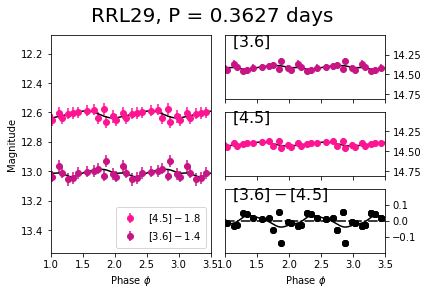

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825]
new error ch1: 0.004184395482730825
new error ch2: 0.00411597287421032



RRab
Channel 1 mags:  [15.97025726 15.95140177 16.04741672 16.15890477 15.92648448 15.86141791
 15.82823838 15.89946849 15.96382094 15.85076061 15.94037749 15.92628286]
Channel 2 mags:  [15.90692868 15.93870751 15.95557797 16.03397121 16.07360269 15.75089831
 15.82013524 15.94265569 15.93733676 99.         15.9

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.938    std dev = 0.066     amplitude = 0.218


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.930    std dev = 0.061     amplitude = 0.220
Channels don't have the same number of measurements, so colour curve couldn't be plotted


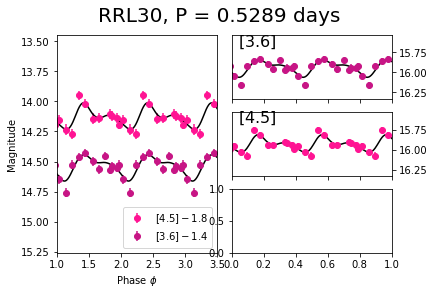

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218]
new error ch1: 0.01819808922893218
new error ch2: 0.019174929170803608



RRd
Channel 1 mags:  [16.07596155 16.06731295 16.04763071 16.11044678 16.13101227 16.19300924
 16.20405106 16.18921179 16.27798212 16.16508645 16.16503211 16.13787983]
Channel 2 mags:  [16.26170077 16.18809477 16.15384613 16.1848427  16.08297992 16.15241579
 16.27378385 16.30968495 16.24014

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.188    std dev = 0.053     amplitude = 0.154
<[3.6] - [4.5]> = -0.039    std dev = 0.050     amplitude = 0.152


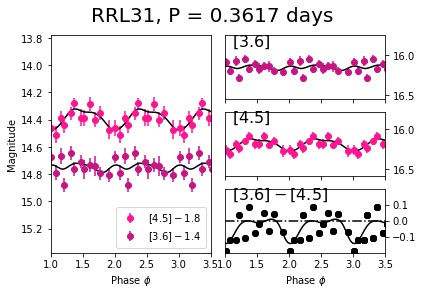

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285]
new error ch1: 0.005592642297243285
new error ch2: 0.012804471036175435



RRc
Channel 1 mags:  [15.16776336 15.39708943 15.37522943 15.27670246 15.28802723 15.14094462
 15.30317496 15.35586643 15.35406828 15.36869481 15.37833263 15.34242649]
Channel 2 mags:  [15.30969838 15.33203024 15.34041188 15.37788843 15.32300997 15.25919127
 15.221534

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.305    std dev = 0.027     amplitude = 0.083
<[3.6] - [4.5]> = 0.001    std dev = 0.034     amplitude = 0.107


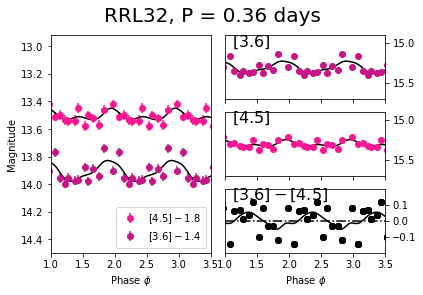

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623]
new error ch1: 0.01246905584316623
new error ch2: 0.006955133630885217



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.97988845 16.15073737 16.29583087 16.1781573  16.35742392 16.1205889
 16.02761412 15.94190527 15.91750876 16.1301271  15.94594196 16.06103249]
Channel 2 mags:  [16.06109544 16.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


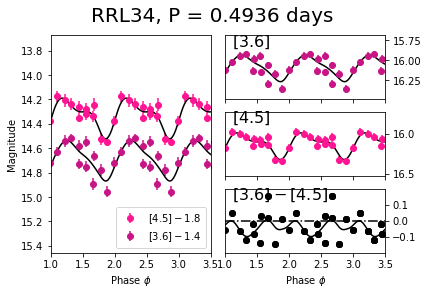

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106]
new error ch1: 0.02764399924573106
new error ch2: 0.027818886560578477



RRab
Channel 1 mags:  [15.66933892 15.57136231 99.         15.65802211 99.         15.72534349
 15.77764695 99.         15.61772908 15.62697717 15.48417989 15.5812578 ]
Channel 2 mags:  [15.61068108 15.52381405 15.63823519

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.644    std dev = 0.061     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.648    std dev = 0.066     amplitude = 0.182
Channels don't have the same number of measurements, so colour curve couldn't be plotted


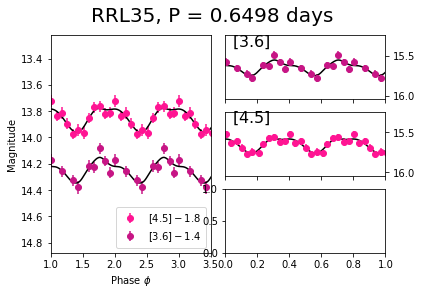

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126]
new error ch1: 0.01871798176793126
new error ch2: 0.015188076796218475



RRab
Channel 1 mags:  [15.97357136 15.90599355 15.90456586 15.98360981 15.90671505 16.06458135
 16.24966606 15.97413249 15.86283287 15.81472097 15.87740582 15.82906992]
Channel 2 mags:  [15.85702902 15

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.940    std dev = 0.081     amplitude = 0.275


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.903    std dev = 0.087     amplitude = 0.249
Channels don't have the same number of measurements, so colour curve couldn't be plotted


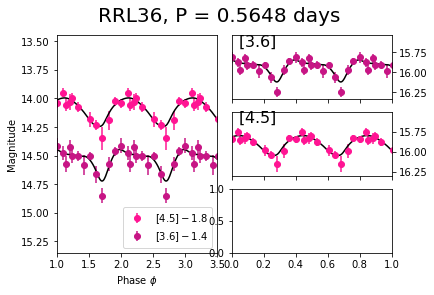

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747]
new error ch1: 0.022957344928941747
new error ch2: 0.02164675419614831



RRab
Channel 1 mags:  [15.83111498 15.85749669 15.98519357 16.00203594 15.97752274 16.05446752
 15.95251833 15.86777475 15.8006041  15.77401312 15.82193415 15.80843883]
Channel 2 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.822    std dev = 0.058     amplitude = 0.178
<[3.6] - [4.5]> = 0.078    std dev = 0.029     amplitude = 0.091


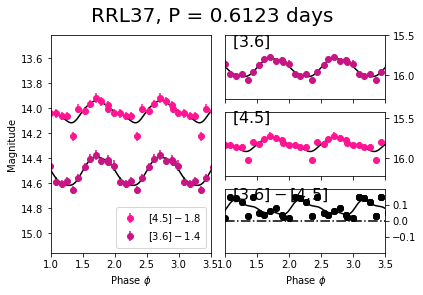

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416]
new error ch1: 0.018725618383013416
new error ch2: 0.014858072864653534



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [15.8317743  15.80978728 15.83315739 15.72685108 15.82916105 15.88124492
 15.91467411 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.862    std dev = 0.052     amplitude = 0.163
<[3.6] - [4.5]> = 0.009    std dev = 0.046     amplitude = 0.145


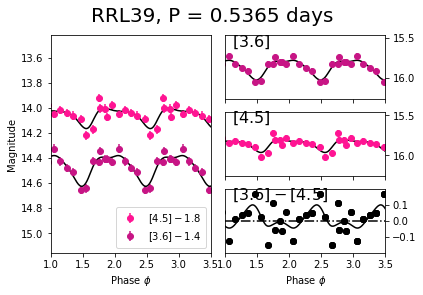

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545]
new error ch1: 0.020445225143792545
new error ch2: 0.013573617713134775



RRd
Channel 1 mags:  [17.24771252 17.33637531 99.         99.         99.         16.53051947
 16.38332599 17.51542768 99.       

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.831    std dev = 0.332     amplitude = 1.029
<[4.5]> = 17.405    std dev = 0.032     amplitude = 0.133
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


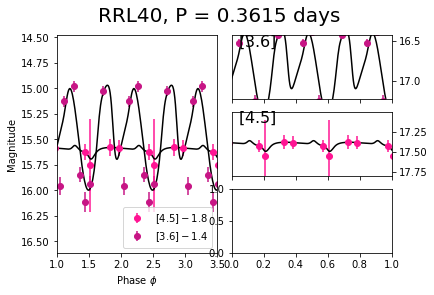

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791]
new error ch1: 0.11225689556413791
new error ch2: 0.01924938485423632



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  [14.70788894 14.81568745 14.76411963 14.6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.546    std dev = 0.023     amplitude = 0.071
<[3.6] - [4.5]> = 0.185    std dev = 0.042     amplitude = 0.123


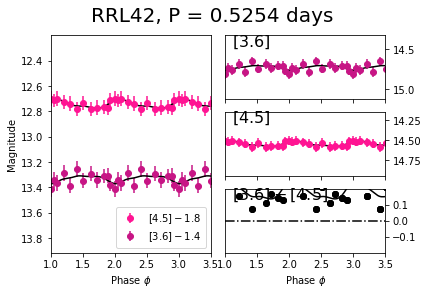

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945]
new error ch1: 0.0051184619149164945
new error ch2: 0.005880624940657331



RRab
Channel 1 mags:  []
Channel 2 mags:  [] 

RRab
Channel 1 mags:  []
Channel

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.940    std dev = 0.133     amplitude = 0.374
Channels don't have the same number of measurements, so colour curve couldn't be plotted


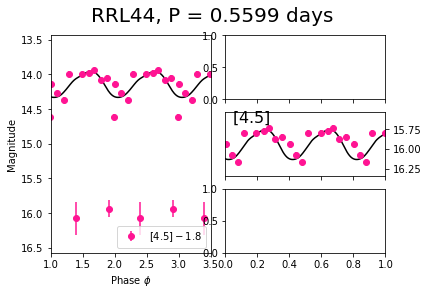

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan]
new error ch1: nan
new error ch2: 0.03118914559677736



RRab
Channel 1 mags:  [15.9288828  15.89522965 16.02898789 16.00918344 16.04507279 16.01

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.861    std dev = 0.046     amplitude = 0.140
<[3.6] - [4.5]> = 0.059    std dev = 0.053     amplitude = 0.170


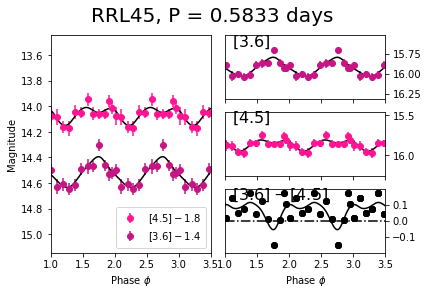

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092]
new error ch1: 0.01997602667697092
new error ch2: 0.011689666638514229



RRab
Channel 1 mags:  [15.90471382 15.88221571 16.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.998    std dev = 0.082     amplitude = 0.273
<[3.6] - [4.5]> = 0.020    std dev = 0.043     amplitude = 0.134


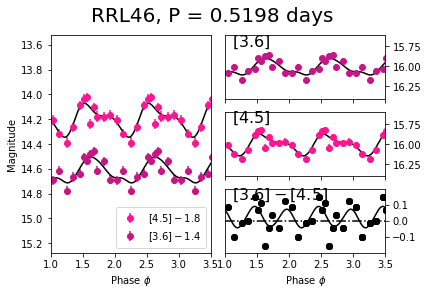

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745]
new error ch1: 0.017381312301694745
new error ch2: 0.022787544008592953



RRab
Channel 1 mags:  [16.0

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.048    std dev = 0.036     amplitude = 0.106


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.033    std dev = 0.056     amplitude = 0.163
Channels don't have the same number of measurements, so colour curve couldn't be plotted


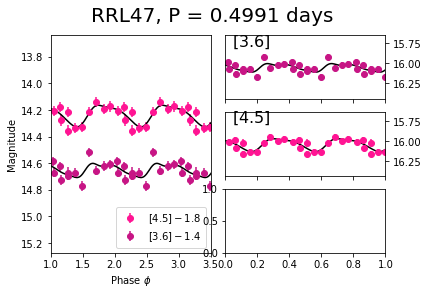

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268]
new error ch1: 0.008871178682373268
new error ch2: 0.014174223551094628



RRab


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.844    std dev = 0.095     amplitude = 0.338
<[4.5]> = 15.948    std dev = 0.101     amplitude = 0.297
Channels don't have the same number of measurements, so colour curve couldn't be plotted


C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:69: RuntimeWarning: invalid value encountered in sqrt
  sigma_c3=np.sqrt(ai33)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:67: RuntimeWarning: invalid value encountered in sqrt
  sigma_c1=np.sqrt(ai11)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:68: RuntimeWarning: invalid value encountered in sqrt
  sigma_c2=np.sqrt(ai22)
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:51: RuntimeWarning: invalid value encountered in double_scalars
  ai11=cofa11/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:52: RuntimeWarning: invalid value encountered in double_scalars
  ai12=cofa21/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:53: RuntimeWarning: invalid value encountered in double_scalars
  ai13=cofa31/det
C:\Users\Jake\MPhys-code\MPhys-RRL\final_scripts\gloess_fits.py:55: RuntimeWarning: invalid value encountered in double_scalars
  ai2

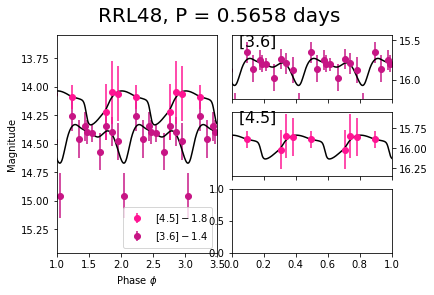

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023]
new error ch1: 0.03083994437805023
new error ch2: 0.0429363

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.012    std dev = 0.294     amplitude = 0.888
<[4.5]> = 14.629    std dev = 0.015     amplitude = 0.058

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


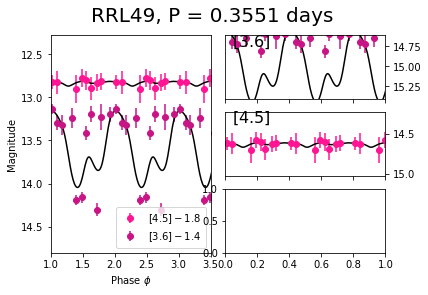

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833]
new error ch1: 0.07725181623327833
new

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.990    std dev = 0.043     amplitude = 0.134
<[3.6] - [4.5]> = 0.001    std dev = 0.041     amplitude = 0.149


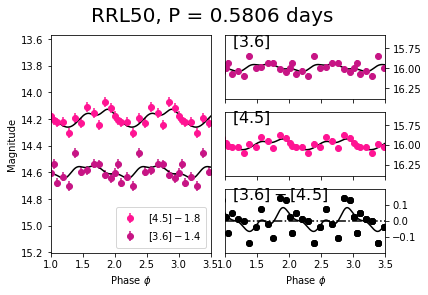

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556]
new error ch1: 0

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.859    std dev = 0.096     amplitude = 0.316
<[4.5]> = 15.817    std dev = 0.081     amplitude = 0.268

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


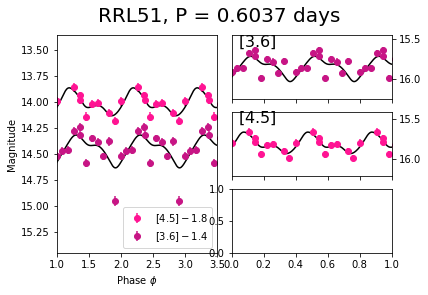

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.087    std dev = 0.039     amplitude = 0.105
<[3.6] - [4.5]> = 0.044    std dev = 0.048     amplitude = 0.148


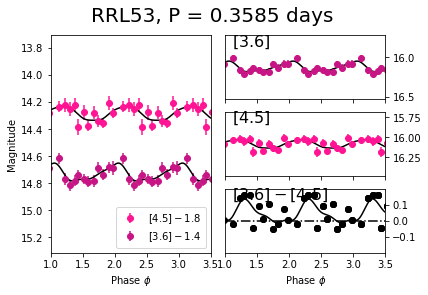

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


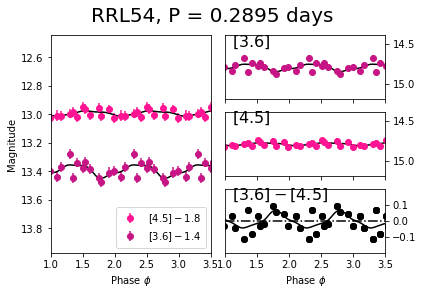

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.045    std dev = 0.045     amplitude = 0.137


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.977    std dev = 0.032     amplitude = 0.090
<[3.6] - [4.5]> = 0.068    std dev = 0.028     amplitude = 0.087


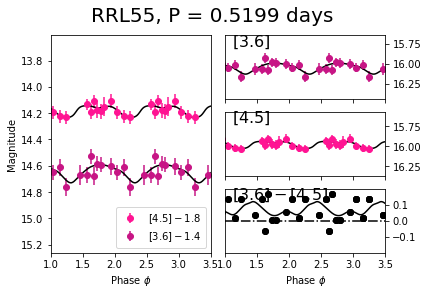

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.972    std dev = 0.047     amplitude = 0.145
<[3.6] - [4.5]> = 0.009    std dev = 0.040     amplitude = 0.135


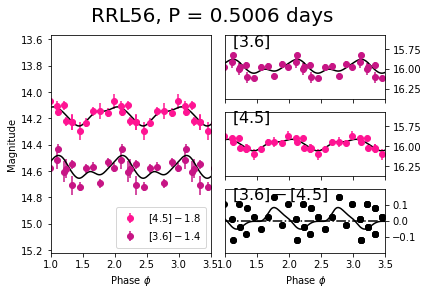

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 12.623    std dev = 0.032     amplitude = 0.106
<[3.6] - [4.5]> = -0.018    std dev = 0.031     amplitude = 0.115


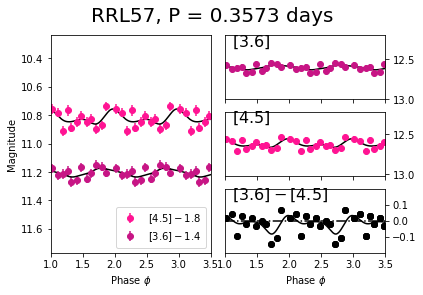

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.939    std dev = 0.065     amplitude = 0.197
<[4.5]> = 15.889    std dev = 0.044     amplitude = 0.125
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


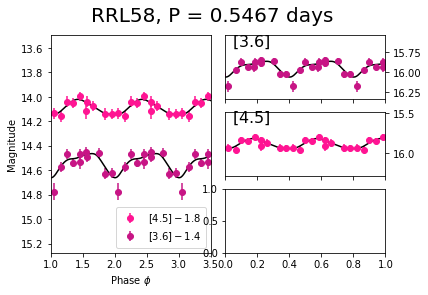

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.162    std dev = 0.087     amplitude = 0.245


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.138    std dev = 0.056     amplitude = 0.160
Channels don't have the same number of measurements, so colour curve couldn't be plotted


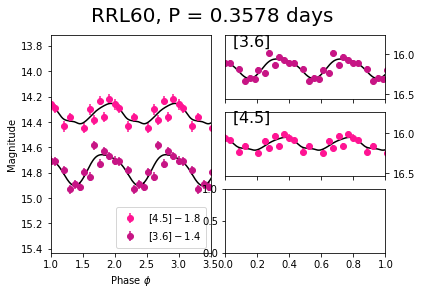

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.874    std dev = 0.054     amplitude = 0.179
<[4.5]> = 15.809    std dev = 0.109     amplitude = 0.328
Channels don't have the same number of measurements, so colour curve couldn't be plotted

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


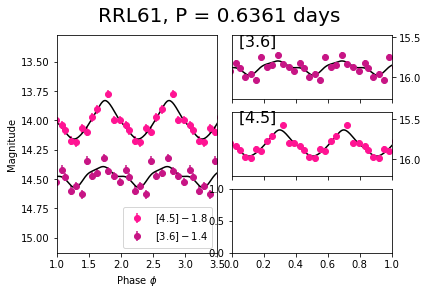

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



<[3.6] - [4.5]> = 0.003    std dev = 0.049     amplitude = 0.141


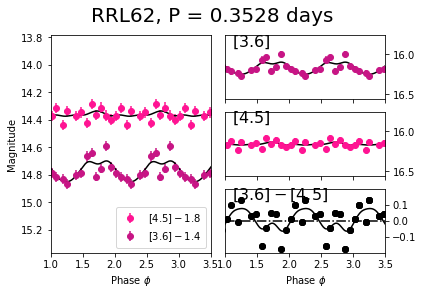

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.793    std dev = 0.095     amplitude = 0.276
<[3.6] - [4.5]> = 0.052    std dev = 0.072     amplitude = 0.226


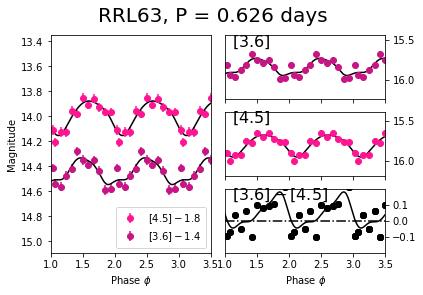

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.269    std dev = 0.052     amplitude = 0.161
<[3.6] - [4.5]> = 0.017    std dev = 0.121     amplitude = 0.355


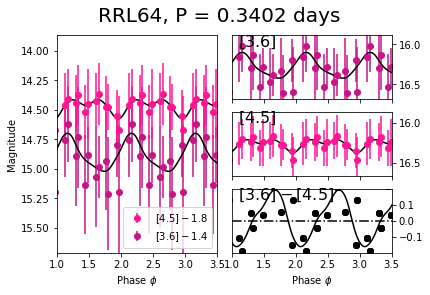

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.757    std dev = 0.066     amplitude = 0.196


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.733    std dev = 0.078     amplitude = 0.238
Channels don't have the same number of measurements, so colour curve couldn't be plotted


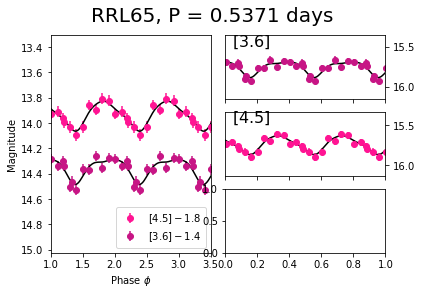

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.429    std dev = 0.010     amplitude = 0.034
<[3.6] - [4.5]> = 0.006    std dev = 0.031     amplitude = 0.104


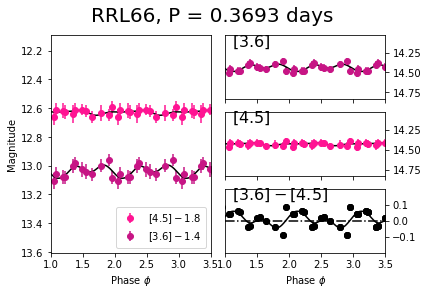

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.637    std dev = 0.049     amplitude = 0.146
<[3.6] - [4.5]> = 0.071    std dev = 0.042     amplitude = 0.140


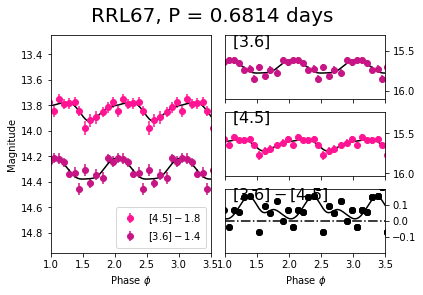

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.869    std dev = 0.084     amplitude = 0.259


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 13.480    std dev = 0.095     amplitude = 0.305
Channels don't have the same number of measurements, so colour curve couldn't be plotted


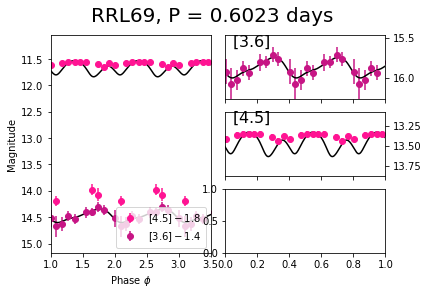

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 15.836    std dev = 0.068     amplitude = 0.187
Channels don't have the same number of measurements, so colour curve couldn't be plotted


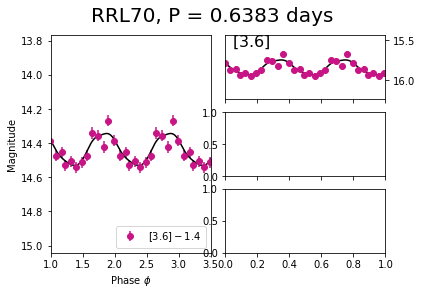

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.089    std dev = 0.039     amplitude = 0.114
<[3.6] - [4.5]> = 0.064    std dev = 0.028     amplitude = 0.090


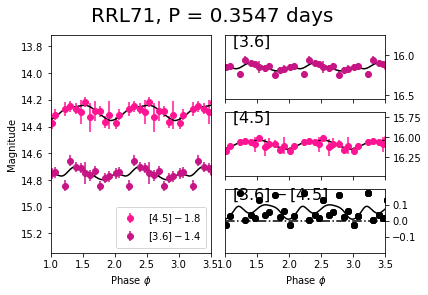

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.166    std dev = 0.092     amplitude = 0.308
<[4.5]> = 16.214    std dev = 0.065     amplitude = 0.204
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


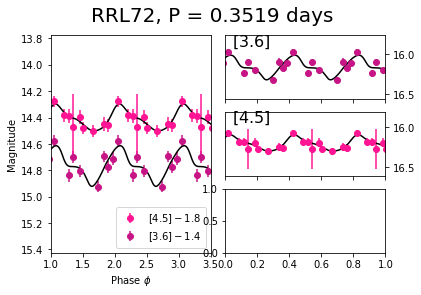

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.399    std dev = 0.014     amplitude = 0.039
<[3.6] - [4.5]> = 0.000    std dev = 0.024     amplitude = 0.077


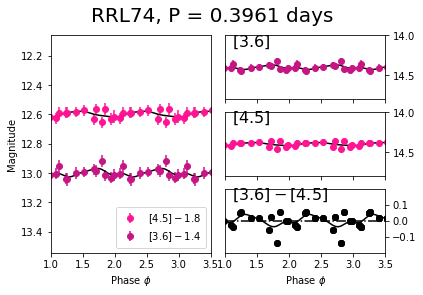

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 9.910    std dev = 0.051     amplitude = 0.167
<[3.6] - [4.5]> = 0.082    std dev = 0.082     amplitude = 0.253


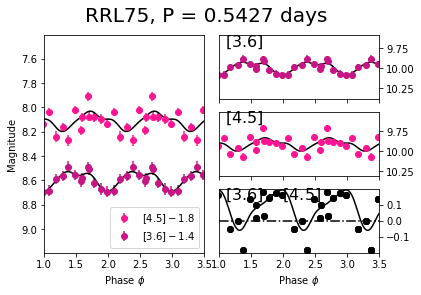

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 11.782    std dev = 0.017     amplitude = 0.062
<[3.6] - [4.5]> = 0.003    std dev = 0.023     amplitude = 0.076


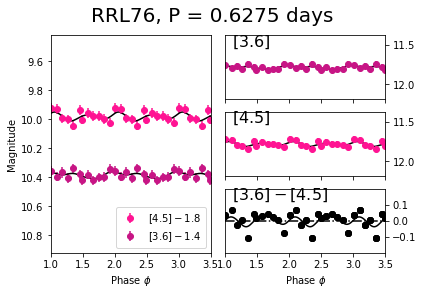

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


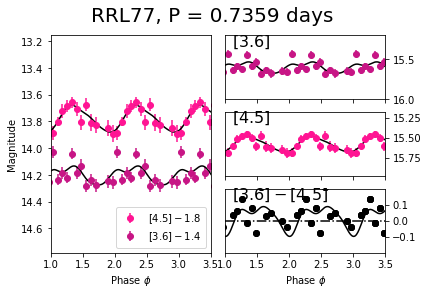

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.209    std dev = 0.026     amplitude = 0.076
<[3.6] - [4.5]> = 0.010    std dev = 0.034     amplitude = 0.099


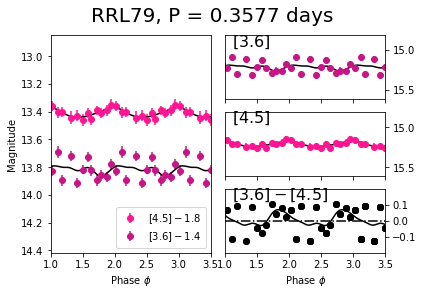

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.086    std dev = 0.026     amplitude = 0.083
<[3.6] - [4.5]> = 0.068    std dev = 0.037     amplitude = 0.117


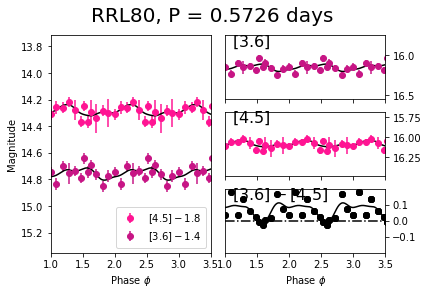

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[3.6]> = 16.032    std dev = 0.059     amplitude = 0.157
<[4.5]> = 15.972    std dev = 0.042     amplitude = 0.123
Channels don't have the same number of measurements, so colour curve couldn't be plotted


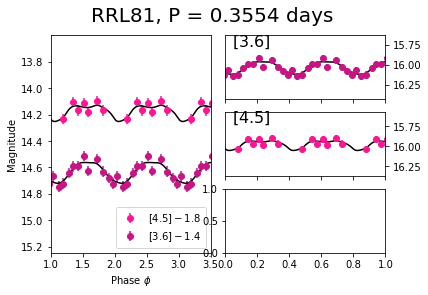

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.524    std dev = 0.018     amplitude = 0.065
<[3.6] - [4.5]> = 0.008    std dev = 0.022     amplitude = 0.078


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


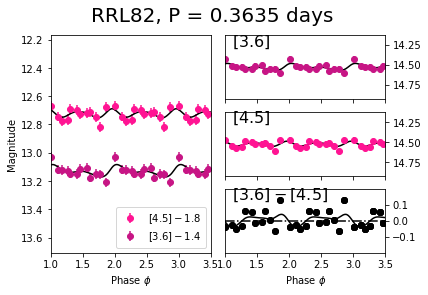

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.196    std dev = 0.020     amplitude = 0.065
<[4.5]> = 16.140    std dev = 0.100     amplitude = 0.339
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


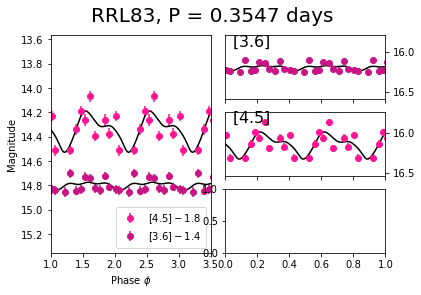

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.266    std dev = 0.011     amplitude = 0.033
<[3.6] - [4.5]> = -0.005    std dev = 0.031     amplitude = 0.084


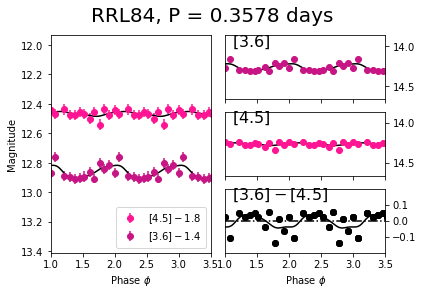

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.674    std dev = 0.017     amplitude = 0.056
<[3.6] - [4.5]> = 0.026    std dev = 0.054     amplitude = 0.175


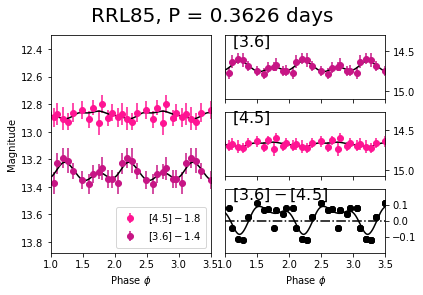

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 15.701    std dev = 0.030     amplitude = 0.111
<[4.5]> = 16.077    std dev = 0.042     amplitude = 0.136
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


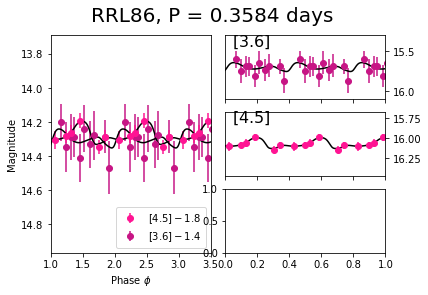

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.217    std dev = 0.052     amplitude = 0.151


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.210    std dev = 0.061     amplitude = 0.192
Channels don't have the same number of measurements, so colour curve couldn't be plotted


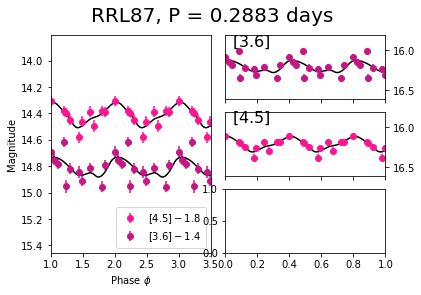

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 14.263    std dev = 0.017     amplitude = 0.058
<[3.6] - [4.5]> = -0.011    std dev = 0.031     amplitude = 0.090


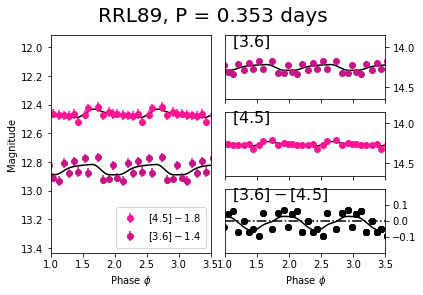

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.814    std dev = 0.060     amplitude = 0.178
<[3.6] - [4.5]> = 0.070    std dev = 0.043     amplitude = 0.141


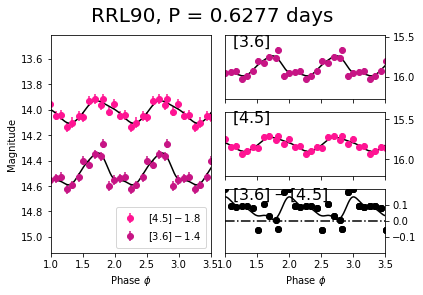

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.647    std dev = 0.052     amplitude = 0.146
<[3.6] - [4.5]> = 0.027    std dev = 0.015     amplitude = 0.062


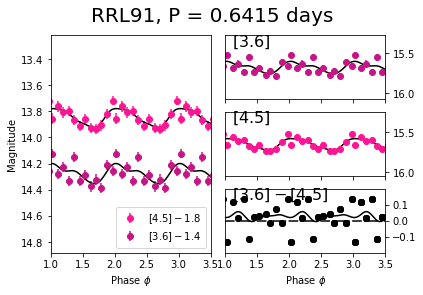

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.120    std dev = 0.066     amplitude = 0.195


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.159    std dev = 0.112     amplitude = 0.340
<[3.6] - [4.5]> = -0.039    std dev = 0.068     amplitude = 0.235


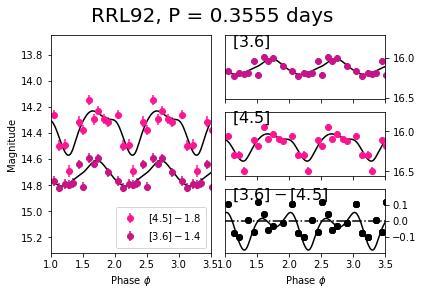

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.168    std dev = 0.132     amplitude = 0.414


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.192    std dev = 0.043     amplitude = 0.143
<[3.6] - [4.5]> = -0.024    std dev = 0.156     amplitude = 0.517


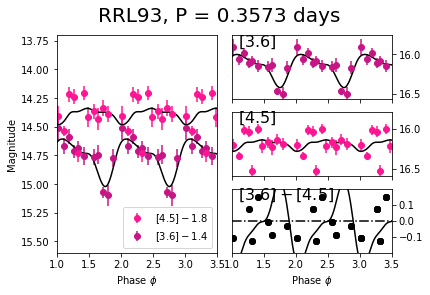

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.890    std dev = 0.072     amplitude = 0.205
<[3.6] - [4.5]> = 0.014    std dev = 0.045     amplitude = 0.140


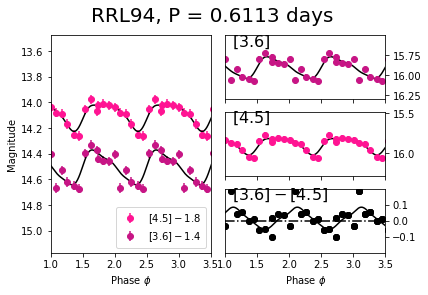

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.309    std dev = 0.033     amplitude = 0.107
Channels don't have the same number of measurements, so colour curve couldn't be plotted


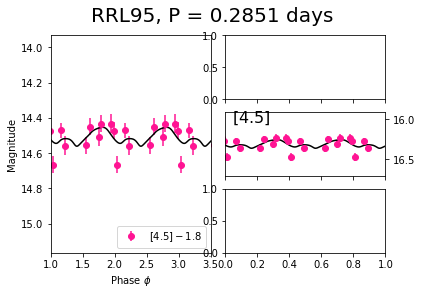

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 9.899    std dev = 0.044     amplitude = 0.149
<[3.6] - [4.5]> = 0.086    std dev = 0.068     amplitude = 0.224


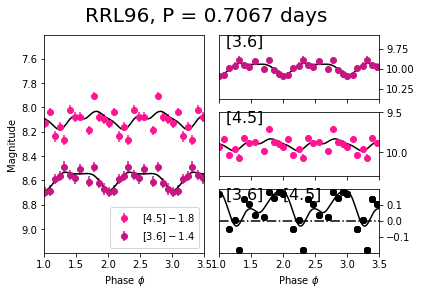

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 15.795    std dev = 0.026     amplitude = 0.086
<[3.6] - [4.5]> = 0.088    std dev = 0.125     amplitude = 0.371


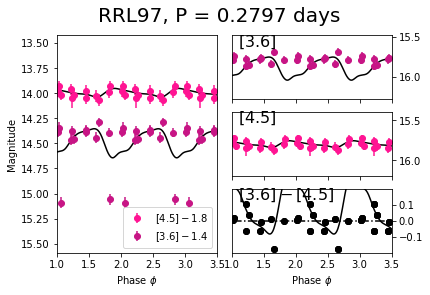

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 12.737    std dev = 0.066     amplitude = 0.225
<[4.5]> = 12.809    std dev = 0.036     amplitude = 0.105

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Channels don't have the same number of measurements, so colour curve couldn't be plotted


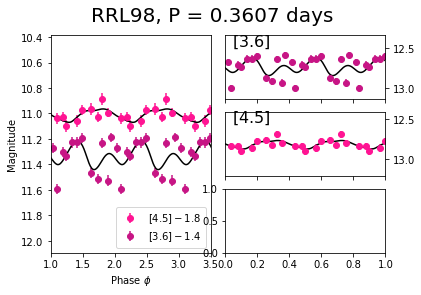

[0.004847262934903451, 0.02205767930696941, 0.028319874287772044, 0.00806652142730894, 0.022566225564902176, 0.016354688284023523, 0.021307906023734446, 0.04178438451200088, 0.0196692504600741, 0.006515890110432743, 0.014595259382162329, 0.014451822395278757, 0.0014061721388597033, 0.009799137513023748, 0.005033996998902761, 0.02016614829715957, 0.016990364836735085, 0.013631998508266019, 0.015935665113477143, 0.02773086380982311, 0.012358852875342366, 0.010256040424446352, 0.01684938417110719, 0.007415836084004941, 0.009366173836899076, nan, 0.02541749839552902, 0.019855329762522207, 0.004184395482730825, 0.01819808922893218, 0.005592642297243285, 0.01246905584316623, nan, 0.02764399924573106, 0.01871798176793126, 0.022957344928941747, 0.018725618383013416, nan, 0.020445225143792545, 0.11225689556413791, nan, 0.0051184619149164945, nan, nan, 0.01997602667697092, 0.017381312301694745, 0.008871178682373268, 0.03083994437805023, 0.07725181623327833, 0.007891469496489556, 0.02632970473896

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_photerr_amp_ch2  mean_photerr_mon_ch1  \
0       V  RR0       0  ...              0.007280              0.014298   
1       V  RR0       1  ...              0.017552              0.015702   
2       V  RR0       2  ...              0.024977              0.011315   
3       V  RR0       3  ...              0.003264              0.015367   
4       V  RR0       4  ...              0.015208              0.049497   
..    ...  ...     ...  ...                   ...                   ...   
93      V  RR0      93  ...              0.017109              0.010201   
94      V  RR2      94  ...              0.010328                   NaN   
95      V  RR0      95  ...              0.012425              0.012765   
96      V  RR2      96  ...              0.007163              0.015068   
97      V  RR1      97  ...              0.010122              0.011297   

    mean_photerr_mon_ch2  mean_photerr_hen_ch1  mean_photerr_hen_ch2  \
0               0.015111              0.014535              0.015277   
1               0.017038              0.016066              0.017793   
2               0.012151              0.011382              0.012224   
3               0.016370              0.015819              0.016580   
4               0.051898              0.051343              0.060295   
..                   ...                   ...                   ...   
93              0.010257              0.010214              0.010279   
94              0.016311                   NaN              0.016480   
95              0.011060              0.012830              0.011171   
96              0.016629              0.015193              0.017971   
97              0.013874              0.011377              0.014047   

    period_PL  A_ch1  A_ch2   amp_ch1   amp_ch2  
0    0.609900  0.039  0.032  0.058167  0.087357  
1    0.493600  0.039  0.033  0.264692  0.201659  
2    0.483200  0.040  0.033  0.325371  0.273611  
3    0.623600  0.040  0.033  0.096798  0.039173  
4    0.556900  0.040  0.033  0.270795  0.182498  
..        ...    ...    ...       ...       ...  
93   0.611300  0.040  0.033  0.271808  0.205309  
94   0.381942  0.041  0.034       NaN  0.107336  
95   0.706700  0.039  0.033  0.147561  0.149104  
96   0.374708  0.039  0.033  0.289315  0.085953  
97   0.483221  0.040  0.033  0.224834  0.105195  

[98 rows x 27 columns]

In [9]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

#file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
file_CC = 'data/reference/CVSGC_'+cluster+'_reduced_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
photerr_amps_ch1 = []
photerr_amps_ch2 = []
photerr_mean_ch1_monson = []
photerr_mean_ch2_monson = []
photerr_mean_ch1_hendel = []
photerr_mean_ch2_hendel = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?':
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    '''if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)'''
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRd')
    elif df_CC['type'][star] == 'RR2':
        P = df_CC['period'][star]
        P_PL = P * 10**0.127
        print('RRe (lol)')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [1, 3, 6, 7]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
        
    '''if cluster == 'PAL13' and star == 1:
        print('hello')
        remove_pls = [2, 4, 5, 8, 9, 10, 11, 12]  # EPOCH number of bad point
        for j in remove_pls:
            mags_ch2[j-1] = 99
            print(mags_ch2)
        print(mags_ch2)'''
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)
    
    try:
        mean_ch1, amp_ch1, std_ch1, N_ch1, mean_ch2, amp_ch2, std_ch2, N_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
        #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    except ValueError:
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_amps_ch1.append(float('NaN'))
        photerr_amps_ch2.append(float('NaN'))
        photerr_mean_ch1_monson.append(float('NaN'))
        photerr_mean_ch2_monson.append(float('NaN'))
        photerr_mean_ch1_hendel.append(float('NaN'))
        photerr_mean_ch2_hendel.append(float('NaN'))
        amps_ch1.append(float('NaN'))
        amps_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        #periods.append(float('NaN'))
        #periods_PL.append(float('NaN'))
        #A_ch1.append(float('NaN'))
        #A_ch2.append(float('NaN'))
        
        continue
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    # Monson 2017 approach:
    ch1_temp = [(1. / e**2) for e in errs_ch1]
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)
    
    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    # Hendel 2018 approach:
    ch1_temp_h = [e**2 for e in errs_ch1.compressed()]
    ch2_temp_h = [e**2 for e in errs_ch2.compressed()]
    
    if ch1_temp_h:
        photerr_ch1_hendel = np.sqrt(sum(ch1_temp_h) / len(errs_ch1.compressed())**2)
    else:
        photerr_ch1_hendel = float('NaN')
    if ch2_temp_h:
        photerr_ch2_hendel = np.sqrt(sum(ch2_temp_h) / len(errs_ch2.compressed())**2)
    else:
        photerr_ch2_hendel = float('NaN')
        
    photerr_mean_ch1_hendel.append(photerr_ch1_hendel)
    photerr_mean_ch2_hendel.append(photerr_ch2_hendel)
        

    # My initial approach:
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
        
    # Fit error amplitude approach (instead of std:        
    photerr_amp_ch1 = amp_ch1 / np.sqrt(12 * N_ch1)
    photerr_amp_ch2 = amp_ch2 / np.sqrt(12 * N_ch2)
    
    photerr_amps_ch1.append(photerr_amp_ch1)
    photerr_amps_ch2.append(photerr_amp_ch2)
    print(photerr_amps_ch1)
    
    print('new error ch1:', photerr_amp_ch1)
    print('new error ch2:', photerr_amp_ch2)
    
    
    print('\n\n')

print(periods)
print(len(periods))

df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['mean_photerr_amp_ch1'] = photerr_amps_ch1
df_CC['mean_photerr_amp_ch2'] = photerr_amps_ch2
df_CC['mean_photerr_mon_ch1'] = photerr_mean_ch1_monson
df_CC['mean_photerr_mon_ch2'] = photerr_mean_ch2_monson
df_CC['mean_photerr_hen_ch1'] = photerr_mean_ch1_hendel
df_CC['mean_photerr_hen_ch2'] = photerr_mean_ch2_hendel
#df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2
df_CC['amp_ch1'] = amps_ch1
df_CC['amp_ch2'] = amps_ch2

df_CC


In [7]:
df_CC

ID            RA           dec units  period  mean_mag_CC  amplitude  \
0     1  15h00m53.07s  -82d12m49.8s    R0  0.6099       17.612       0.74   
1     2  15h00m34.18s  -82d14m25.0s    R0  0.4936       17.670       1.21   
2     3  14h59m28.92s  -82d14m39.6s    R0  0.4832       17.697       1.21   
3     4  14h59m54.70s  -82d12m38.1s    R0  0.6236       17.676       0.80   
4     5  14h59m54.37s  -82d13m39.7s    R0  0.5569       17.656       1.11   
..  ...           ...           ...   ...     ...          ...        ...   
93  112  14h59m55.31s  -82d11m50.3s    R0  0.6113       17.717       0.44   
94  153  14h59m10.31s  -82d15m46.8s    R0  0.2851       17.678       0.31   
95  167  15h00m26.10s  -82d12m35.0s    R0  0.7067       17.524       0.56   
96  171  15h00m42.31s  -82d13m45.2s    R0  0.2797       17.666       0.22   
97  173  14h59m09.00s  -82d11m11.3s    R0  0.3607       14.200        NaN   

   colour type  id_new  ...  mean_std_ch1  mean_std_ch2  mean_photerr_ch1  \
0       V  RR0       0  ...      0.018730      0.027128          0.050154   
1       V  RR0       1  ...      0.086179      0.062413          0.055347   
2       V  RR0       2  ...      0.104319      0.096471          0.037696   
3       V  RR0       3  ...      0.029697      0.011534          0.054457   
4       V  RR0       4  ...      0.087480      0.060872          0.176149   
..    ...  ...     ...  ...           ...           ...               ...   
93      V  RR0      93  ...      0.090798      0.071966          0.035371   
94      V  RR2      94  ...           NaN      0.033087               NaN   
95      V  RR0      95  ...      0.050314      0.043510          0.044386   
96      V  RR2      96  ...      0.100226      0.025818          0.052523   
97      V  RR1      97  ...      0.066405      0.035750          0.039339   

    mean_photerr_ch2  mean_photerr_amp_ch1  mean_photerr_amp_ch2  \
0           0.052765              0.004847              0.007280   
1           0.058421              0.022058              0.017552   
2           0.038599              0.028320              0.024977   
3           0.057235              0.008067              0.003264   
4           0.202236              0.022566              0.015208   
..               ...                   ...                   ...   
93          0.035586              0.022651              0.017109   
94          0.049314                   NaN              0.010328   
95          0.038597              0.012297              0.012425   
96          0.060581              0.024110              0.007163   
97          0.042015              0.018736              0.010122   

    mean_photerr_mon_ch1  mean_photerr_mon_ch2  mean_photerr_hen_ch1  \
0               0.014298              0.015111              0.014535   
1               0.015702              0.017038              0.016066   
2               0.011315              0.012151              0.011382   
3               0.015367              0.016370              0.015819   
4               0.049497              0.051898              0.051343   
..                   ...                   ...                   ...   
93              0.010201              0.010257              0.010214   
94                   NaN              0.016311                   NaN   
95              0.012765              0.011060              0.012830   
96              0.015068              0.016629              0.015193   
97              0.011297              0.013874              0.011377   

    mean_photerr_hen_ch2  
0               0.015277  
1               0.017793  
2               0.012224  
3               0.016580  
4               0.060295  
..                   ...  
93              0.010279  
94              0.016480  
95              0.011171  
96              0.017971  
97              0.014047  

[98 rows x 22 columns]

### Plotting PL relation (unweighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

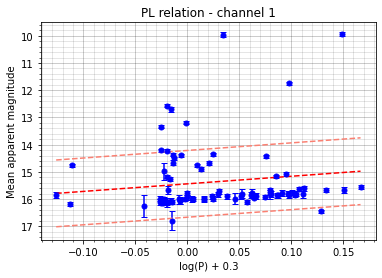

Intercept, a: 15.44
Error in a:    0.13
Std. dev.:     1.23

Distance modulus: 15.84 ± 0.14 (random) ± 0.12 (systematic)
Distance: 14.72 ± 0.93 (random) ± 0.80 (systematic) kpc




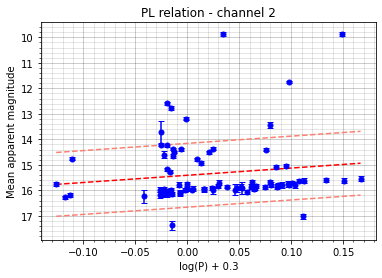

Intercept, a: 15.41
Error in a:    0.14
Std. dev.:     1.25

Distance modulus: 15.82 ± 0.14 (random) ± 0.12 (systematic)
Distance: 14.59 ± 0.94 (random) ± 0.81 (systematic) kpc


In [11]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(periods_PL, means_ch1.mask)
periods_ch2 = np.ma.masked_array(periods_PL, means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))


In [20]:
t_CC = Table.from_pandas(df_CC)
#t_CC.sort('mean_mag_ch1')

checkthese = []
for i in range(len(t_CC)):
    if t_CC['mean_mag_ch1'][i] < 15.4:
        checkthese.append(t_CC['id_new'][i])

print(checkthese)
t_CC.show_in_notebook()

[0, 3, 9, 12, 13, 14, 23, 28, 31, 41, 48, 53, 56, 65, 73, 74, 75, 78, 81, 83, 84, 88, 95, 97]


### Plotting PL relation (weighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

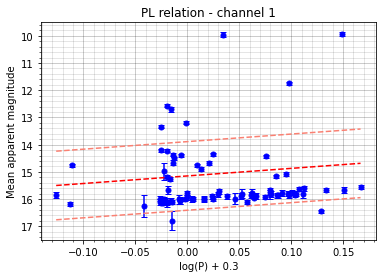

Intercept, a: 15.15
Error in a:    0.15
Std. dev.:     1.26

Distance modulus: 15.55 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.88 ± 0.90 (random) ± 0.70 (systematic) kpc




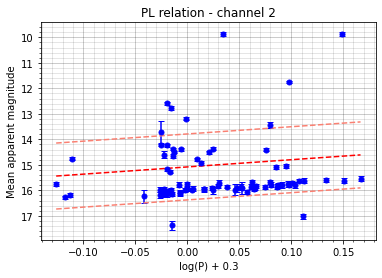

Intercept, a: 15.08
Error in a:    0.15
Std. dev.:     1.29

Distance modulus: 15.49 ± 0.15 (random) ± 0.12 (systematic)
Distance: 12.55 ± 0.88 (random) ± 0.70 (systematic) kpc


In [15]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(periods_PL, means_ch1.mask)
periods_ch2 = np.ma.masked_array(periods_PL, means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

#popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed(), sigma=err_mean_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

#popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed(), sigma=err_mean_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))


#### Trying to get matching to master list based on coordinates working (but it won't and i am sad):
These aren't used any more but I'm keeping them around in case I need them

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL2_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
        1 10.402177 34.836456 229.05098 -0.16560569
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1343.18787331), array(75.13551432))


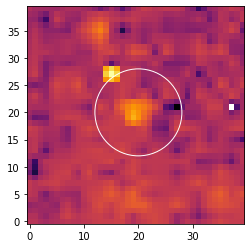

Mean: 55.818267822265625
Median: 53.148773193359375
Std dev: 21.55946159362793
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


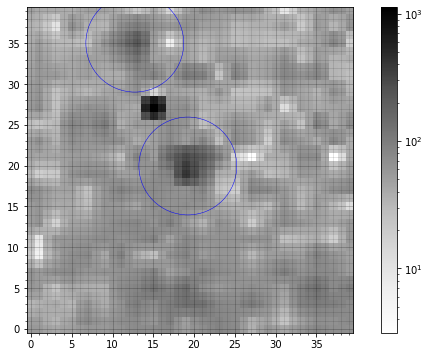

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.227897 19.956908 0.53458902 ... 357.69717 3.6291534  -1.3995133        1
  2 12.724014 35.022011 0.78328236 ... 218.59438 1.6044276 -0.51330033        2


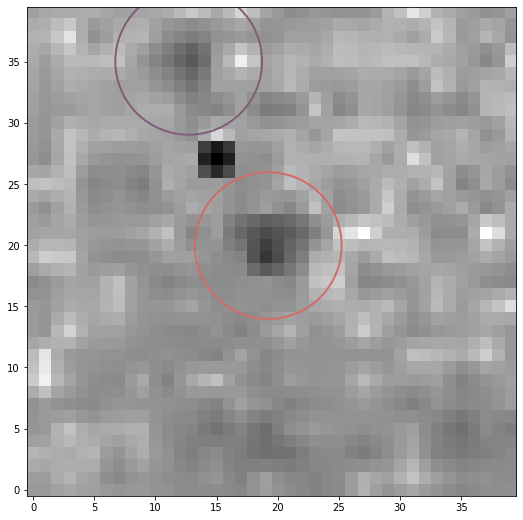

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.10932639999998628s
   x_0       y_0     flux_0   id ...   y_fit    flux_fit  flux_unc iter_detected
--------- --------- -------- --- ... --------- --------- --------- -------------
19.227897 19.956908 4822.526   1 ... 19.956908 4382.3119 123.23011             1
12.724014 35.022011 1350.585   2 ... 35.022011   1767.19 86.806252             1


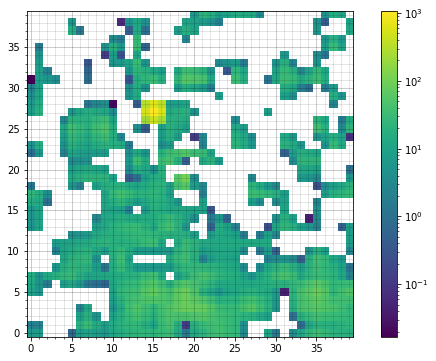

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.227897 19.956908    16.448818 0.042486303
  2        2             1 12.724014 35.022011    17.434868 0.060969787
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 19.227897 19.956908 16.448818 0.042486303
  2 12.724014 35.022011 17.434868 0.060969787
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05319478, -0.16745755), (229.0508948 , -0.16597776)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
       

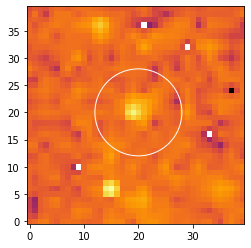

Mean: 48.83451843261719
Median: 46.608665466308594
Std dev: 19.045347213745117
yay all conditions check out
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


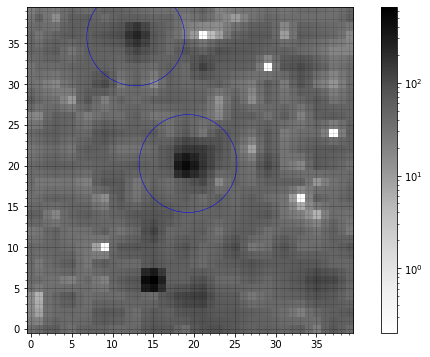

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.255515 20.258677 0.91022835 ... 500.10239 4.4391054  -1.6182387        1
  2 12.842023  35.79453 0.85214092 ... 237.62831 1.9954593 -0.75010718        2


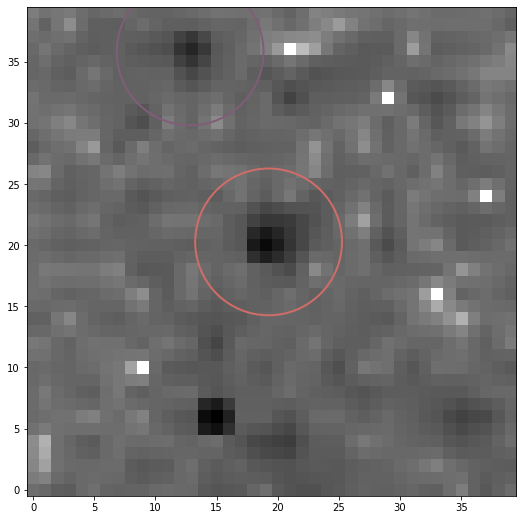

Time taken to fit PSF model: 0.029739500000005137s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.255515 20.258677 4008.3319   1 ... 4498.2229 119.32239             1
12.842023  35.79453  1651.618   2 ...  1964.124 73.524306             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


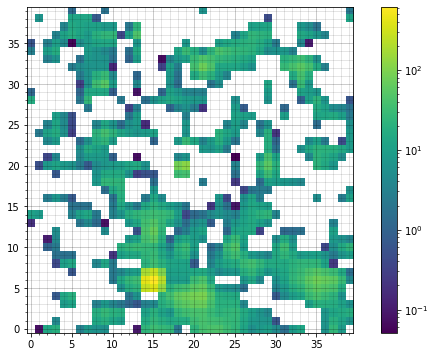

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.255515 20.258677    16.420101 0.041260712
  2        2             1 12.842023  35.79453    17.319781 0.050247543
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 19.255515 20.258677 16.420101 0.041260712
  2 12.842023  35.79453 17.319781 0.050247543
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05314435, -0.16745388), (229.05076385, -0.16597719)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0  17.5

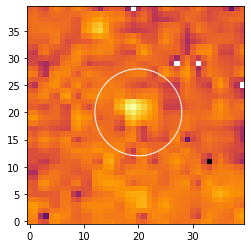

Mean: 47.087528228759766
Median: 44.870487213134766
Std dev: 20.56047248840332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


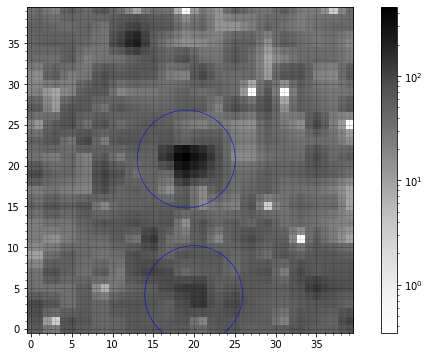

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.938693 4.1834707 0.36345366 ... 118.67358  1.122307 -0.12527918        1
  2 19.050473   20.8107 0.79079518 ... 463.30774 4.1436501  -1.5434577        2


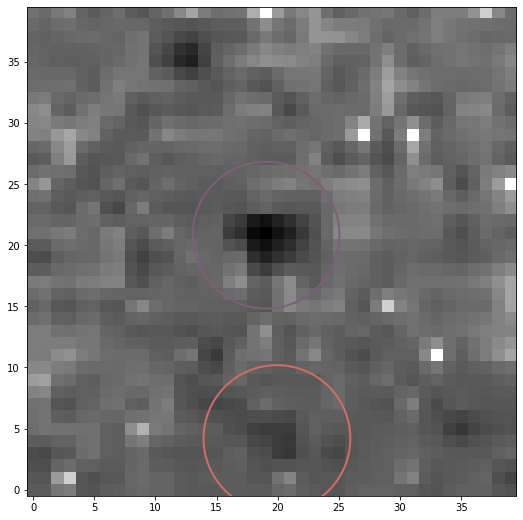

Time taken to fit PSF model: 0.03251090000003387s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.938693 4.1834707 2811.1269   1 ...  1525.146 114.99214             1
19.050473   20.8107 4252.8996   2 ... 4768.3704 126.55147             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


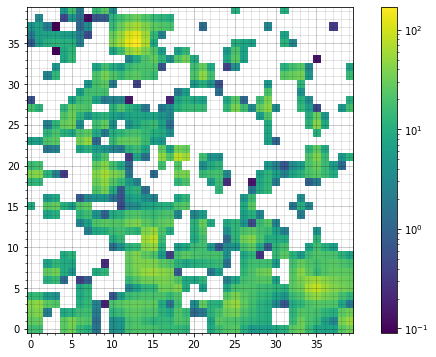

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.938693 4.1834707     17.59489 0.087030485
  2        2             1 19.050473   20.8107    16.357244 0.041270727
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 19.938693 4.1834707  17.59489 0.087030485
  2 19.050473   20.8107 16.357244 0.041270727
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05576938, -0.16800199), (229.05305908, -0.16740521)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
comp @ idx:
[0 0]
id_master   x_0     y_0       RA    ...    err_e1     mag_e2     err_e2  
--------- -------- ------ --------- ... ----------- --------- -----------
        0 17.55

IndexError: index -99 is out of bounds for axis 0 with size 2

In [9]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        star = 2
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')                
                
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            print(cat_match)
            print(cat_m)

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)
            idx2, d2d2, d3d2 = match_coordinates_sky(cat_match, cat_m)
            
            print(idx, d2d, d3d)
            print(idx2, d2d2, d3d2)
            
            print('comp @ idx:')
            print(idx)
            print(comp_table[idx])

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

            print(ind, match_index)

            print('\n\n')
            print_table_nicely(match_table)
            print_table_nicely(comp_table)
            print('\n\n')

            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            
            print(match_table)
            print(comp_table)
            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            match_table = match_table[ind]
            comp_table = comp_table[match_index][ind]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        '''save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()'''


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946
        1  23.78174 2.2946799 228.99106 -0.11590368
        2 19.035947 17.895987 228.98862 -0.11470356
        3 28.339118 3.5178503 228.99074 -0.11662042
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1094.44146707), array(511.14364631))


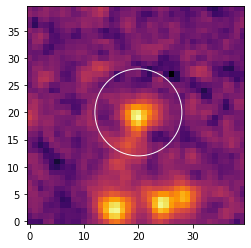

Mean: 51.14960861206055
Median: 45.8643913269043
Std dev: 20.52968978881836
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.575564766899848 ...  3.229357000877366 -1.2727901457891397
  2 24.468016488625913 ... 2.6370181380326754 -1.0527827924589486
  3 19.840980613332604 ... 3.0119700744567304 -1.1971266315018754
Number of PSF stars: 3


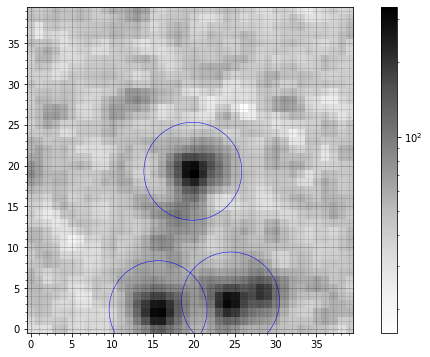

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.575565 2.3412497  0.5500007 ... 313.79651  3.229357 -1.2727901        1
  2 24.468016 3.4122953 0.66038248 ... 308.46622 2.6370181 -1.0527828        1
  3 19.840981 19.312539 0.66081841 ... 335.77524 3.0119701 -1.1971266        2


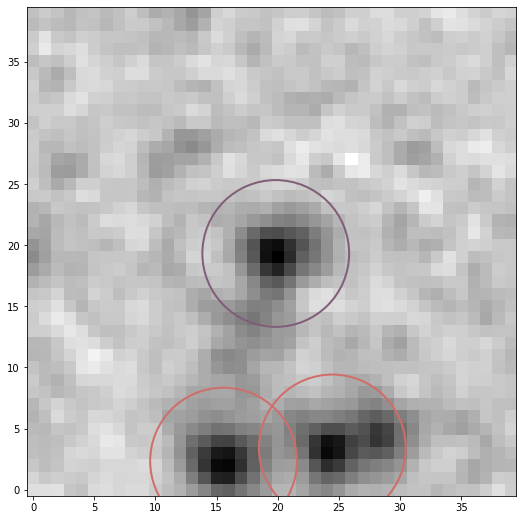

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13006529999984195s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.575565 2.3412497  5234.599   1 ... 4282.3508 158.62785             1
24.468016 3.4122953 6343.6234   2 ... 4203.3857 159.67692             1
19.840981 19.312539 5035.5648   3 ... 4349.1952 97.013214             1
28.818834 4.6227482 1987.8664   4 ... 1950.2446 69.134211             2


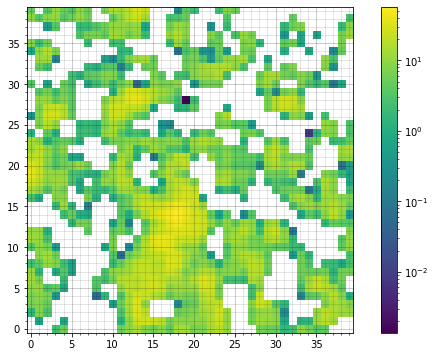

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.575565 2.3412497    16.481396 0.049904437
  2        1             1 24.468016 3.4122953    16.501604 0.050735348
  3        2             1 19.840981 19.312539     16.46458 0.038203282
  4        1             2 28.818834 4.6227482    17.335379 0.048521165
 id  xcenter   ycenter    mag_e1     err_e1   id_master
--- --------- --------- --------- ----------- ---------
  1 15.575565 2.3412497 16.481396 0.049904437         0
  2 24.468016 3.4122953 16.501604 0.050735348         1
  3 19.840981 19.312539  16.46458 0.038203282         2
  4 28.818834 4.6227482 17.335379 0.048521165         3
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946 16.481396 0.049904437
        1 

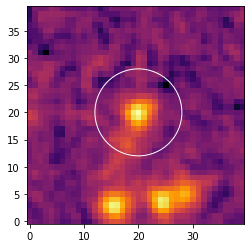

Mean: 45.08599090576172
Median: 39.76604461669922
Std dev: 21.78135871887207
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.529851137079332 ... 2.8684341330745937 -1.1441122044230256
  2 24.588323791199468 ...  2.521756212073415 -1.0042577483475987
  3 19.895611595859556 ... 3.2725228838763614 -1.2872067303461203
Number of PSF stars: 3


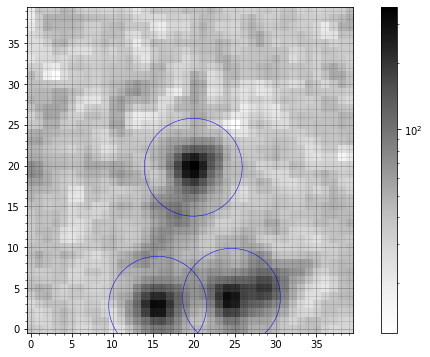

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.529851 2.8852351  0.6115023 ...  317.5033 2.8684341 -1.1441122        1
  2 24.588324 3.8501471 0.64750822 ... 305.72614 2.5217562 -1.0042577        1
  3 19.895612  19.80354 0.63817235 ... 359.59317 3.2725229 -1.2872067        2


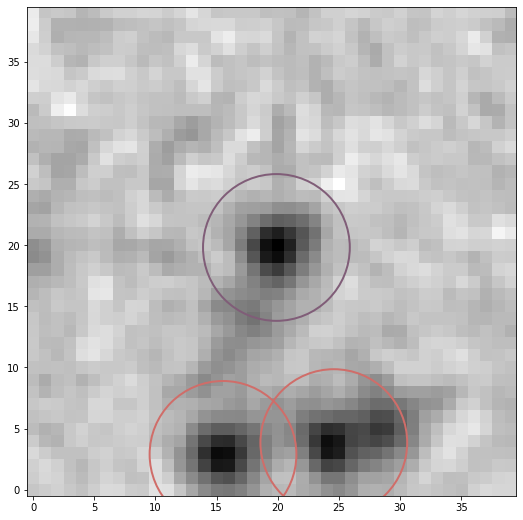

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05155899999954272s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.529851 2.8852351 4907.8212   1 ...  3888.027 149.42427             1
24.588324 3.8501471 6495.5983   2 ... 4029.7415 151.86088             1
19.895612  19.80354 5290.4631   3 ...  4546.161 96.792641             1
28.991484 5.2863925 2094.5302   4 ...  2008.288 91.399826             2


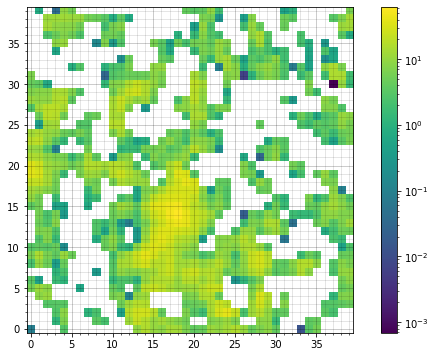

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.529851 2.8852351    16.585697 0.051128195
  2        1             1 24.588324 3.8501471    16.546827  0.05046856
  3        2             1 19.895612  19.80354    16.415908 0.037514391
  4        1             2 28.991484 5.2863925    17.302955 0.057572822
 id  xcenter   ycenter    mag_e2     err_e2   id_master
--- --------- --------- --------- ----------- ---------
  1 15.529851 2.8852351 16.585697 0.051128195         0
  2 24.588324 3.8501471 16.546827  0.05046856         1
  3 19.895612  19.80354 16.415908 0.037514391         2
  4 28.991484 5.2863925 17.302955 0.057572822         3
id_master    x_0       y_0        RA    ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049904437 16.585697 0.05112819

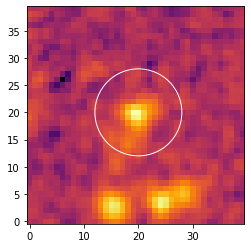

Mean: 43.298133850097656
Median: 38.060081481933594
Std dev: 21.694374084472656
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.324348926937843 ...  2.740425138283709  -1.094544856766432
  2 24.356835138718903 ...  2.714869883759798 -1.0843725497115577
  3  19.62447740837231 ... 3.2168555396751186 -1.2685788958587219
Number of PSF stars: 3


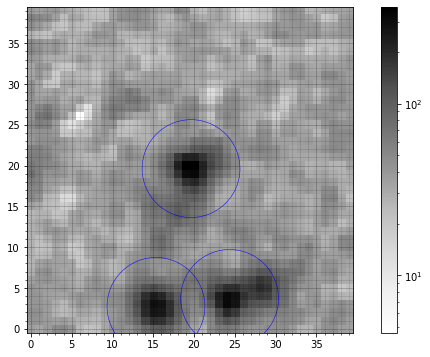

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.324349 2.7371235  0.5340575 ... 289.66589 2.7404251 -1.0945449        1
  2 24.356835 3.7104366 0.65278165 ... 315.94113 2.7148699 -1.0843725        1
  3 19.624477  19.63687  0.6275326 ... 355.89859 3.2168555 -1.2685789        2


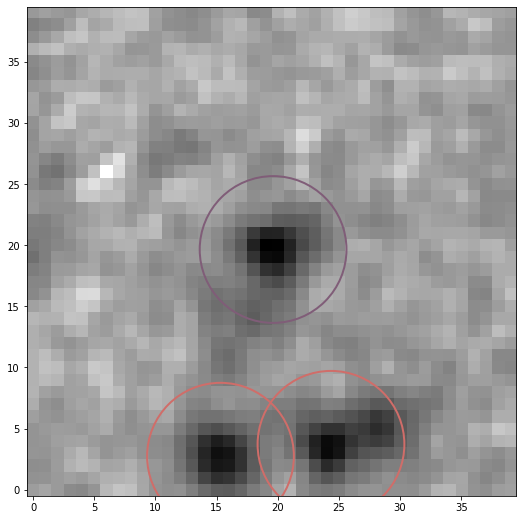

Time taken to fit PSF model: 0.05036079999990761s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.324349 2.7371235 4992.7411   1 ... 4055.7058 150.07603             1
24.356835 3.7104366  6316.759   2 ... 4313.4969 150.60356             1
19.624477  19.63687 5878.2963   3 ... 4946.7007 89.934214             1
28.912678 5.2484861 2236.2822   4 ... 2001.7659 81.189482             2


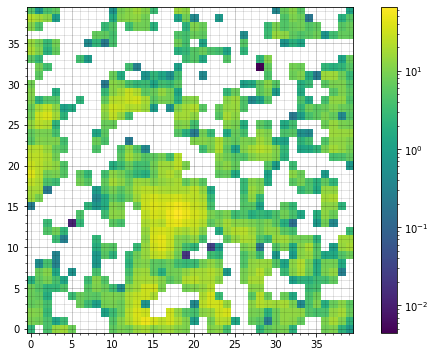

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.324349 2.7371235    16.540501 0.049870705
  2        1             1 24.356835 3.7104366    16.473594 0.048062134
  3        2             1 19.624477  19.63687    16.324878 0.035533096
  4        1             2 28.912678 5.2484861    17.307134 0.053029737
 id  xcenter   ycenter    mag_e3     err_e3   id_master
--- --------- --------- --------- ----------- ---------
  1 15.324349 2.7371235 16.540501 0.049870705         0
  2 24.356835 3.7104366 16.473594 0.048062134         1
  3 19.624477  19.63687 16.324878 0.035533096         2
  4 28.912678 5.2484861 17.307134 0.053029737         3
id_master    x_0       y_0        RA    ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.051128195 16.540501 0.04987070

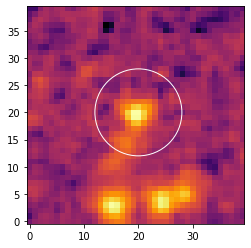

Mean: 41.48185729980469
Median: 36.60084533691406
Std dev: 21.256439208984375
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.402103064215103 ...  2.940967477508381 -1.1712255547930523
  2 24.441040130497164 ... 2.5445886987166184 -1.0140439850382048
  3 19.584984056330125 ...  3.317834368858013 -1.3021367540351565
Number of PSF stars: 3


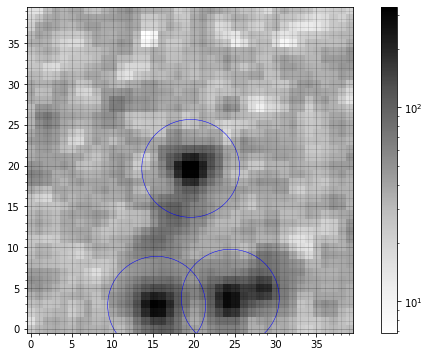

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.402103 2.8725598 0.62275623 ... 325.81424 2.9409675 -1.1712256        1
  2  24.44104 3.7414083 0.61550877 ... 291.70139 2.5445887  -1.014044        1
  3 19.584984 19.661793 0.57186691 ... 331.10718 3.3178344 -1.3021368        2


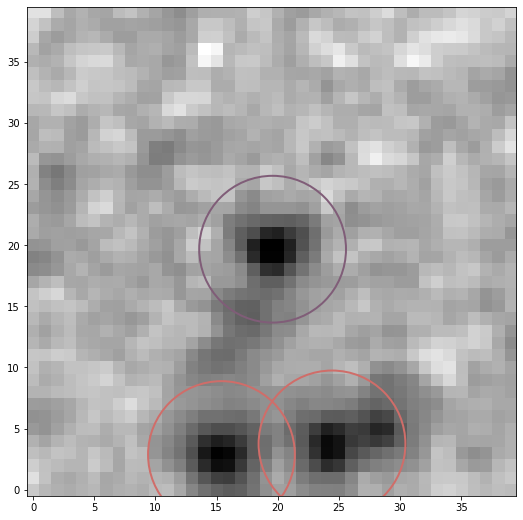

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13611569999920903s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.402103 2.8725598 5329.7702   1 ... 4051.8584 141.20479             1
 24.44104 3.7414083 6082.0895   2 ... 4012.1419 146.73186             1
19.584984 19.661793 5237.4321   3 ... 4606.1036 84.637918             1
28.863052 5.1782517 1945.5198   4 ... 1840.7738  83.87635             2


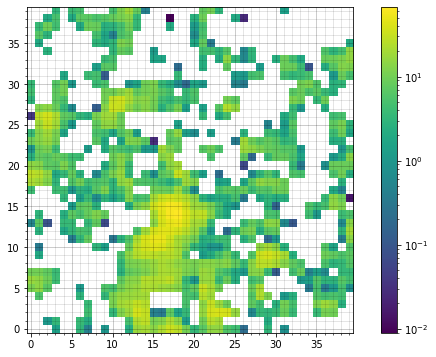

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.402103 2.8725598    16.541081 0.048006401
  2        1             1  24.44104 3.7414083    16.551776 0.049493862
  3        2             1 19.584984 19.661793    16.401882 0.035650853
  4        1             2 28.863052 5.1782517    17.397715 0.057623613
 id  xcenter   ycenter    mag_e4     err_e4   id_master
--- --------- --------- --------- ----------- ---------
  1 15.402103 2.8725598 16.541081 0.048006401         0
  2  24.44104 3.7414083 16.551776 0.049493862         1
  3 19.584984 19.661793 16.401882 0.035650853         2
  4 28.863052 5.1782517 17.397715 0.057623613         3
id_master    x_0       y_0        RA    ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049870705 16.541081 0.04800640

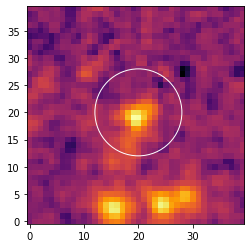

Mean: 41.5771484375
Median: 36.40973663330078
Std dev: 20.748353958129883
 id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 15.41594560840494 ... 3.177380045210075  -1.2551729093265562
  2 24.46245075408594 ... 2.722809928717321   -1.087543313972069
  3 28.03162586417031 ... 1.344736198500567 -0.32159273915026876
  4 19.64046228737398 ... 3.441693502329084  -1.3419304797856226
Number of PSF stars: 4


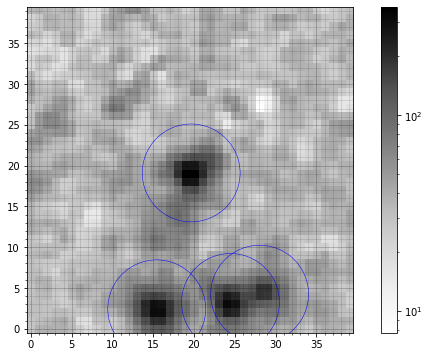

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.415946 2.4431413 0.54827609 ...  302.9071   3.17738  -1.2551729        1
  2 24.462451 3.2251417 0.69369881 ... 313.86978 2.7228099  -1.0875433        1
  3 28.031626 4.2359861 0.67056078 ... 186.96165 1.3447362 -0.32159274        1
  4 19.640462 19.105593  0.6297486 ... 353.34238 3.4416935  -1.3419305        2


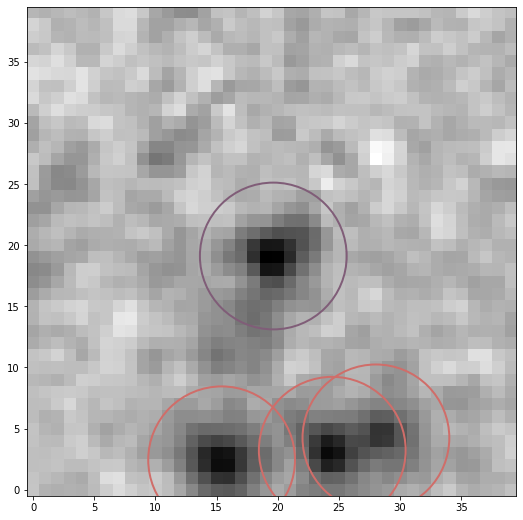

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04051690000051167s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.415946 2.4431413 5087.0391   1 ... 4361.4582 93.197894             1
24.462451 3.2251417 6117.9363   2 ... 3480.1308 89.643748             1
28.031626 4.2359861 5933.2528   3 ... 1937.2708 95.931724             1
19.640462 19.105593 5364.6779   4 ... 4337.1694 89.390413             1


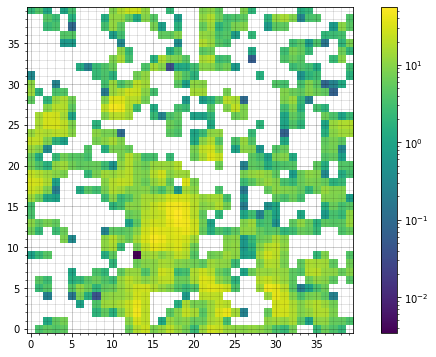

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.415946 2.4431413    16.461172 0.037566263
  2        1             1 24.462451 3.2251417    16.706262 0.040683178
  3        1             1 28.031626 4.2359861    17.342275 0.061348083
  4        2             1 19.640462 19.105593    16.467235 0.037063511
 id  xcenter   ycenter    mag_e5     err_e5   id_master
--- --------- --------- --------- ----------- ---------
  1 15.415946 2.4431413 16.461172 0.037566263         0
  2 24.462451 3.2251417 16.706262 0.040683178         1
  3 28.031626 4.2359861 17.342275 0.061348083         2
  4 19.640462 19.105593 16.467235 0.037063511         3
id_master    x_0       y_0        RA    ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.048006401 16.461172 0.03756626

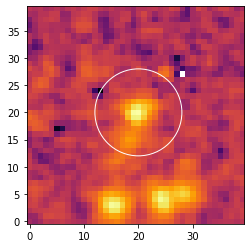

Mean: 34.465213775634766
Median: 28.9788818359375
Std dev: 21.482254028320312
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.434755562019973 ...  2.738553859224638 -1.0938032165799807
  2 24.534598456523725 ... 2.4849501718563496 -0.9882942117430025
  3  19.74102929173598 ... 3.1529990801217895 -1.2468096101094626
Number of PSF stars: 3


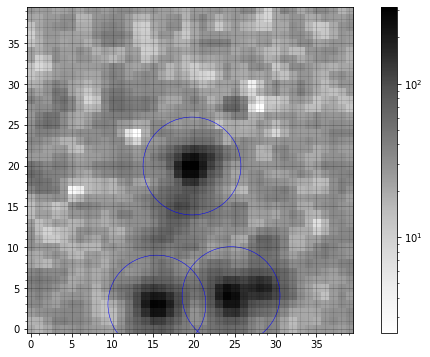

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.434756 3.0174515 0.61955722 ... 295.59125 2.7385539  -1.0938032        1
  2 24.534598 4.0607341 0.64556602 ... 289.43369 2.4849502 -0.98829421        1
  3 19.741029 19.956366 0.59445665 ... 317.62701 3.1529991  -1.2468096        2


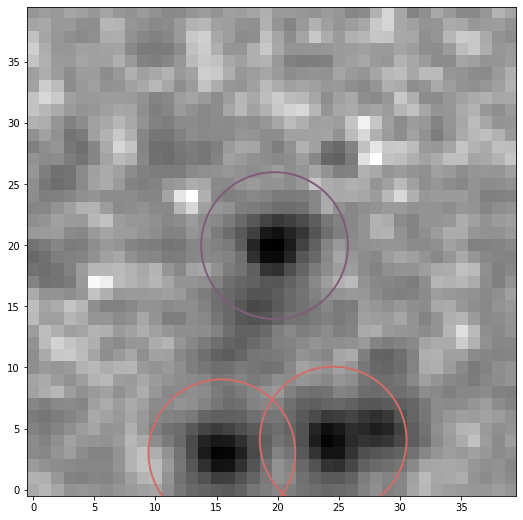

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.053249399999913294s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.434756 3.0174515 4753.6891   1 ... 3652.2488 138.09474             1
24.534598 4.0607341 6293.5869   2 ... 3843.2674 138.94848             1
19.741029 19.956366 5310.5515   3 ... 4089.3208 104.98822             1
28.973933 5.1364362 2135.1223   4 ...  1802.625 89.064865             2


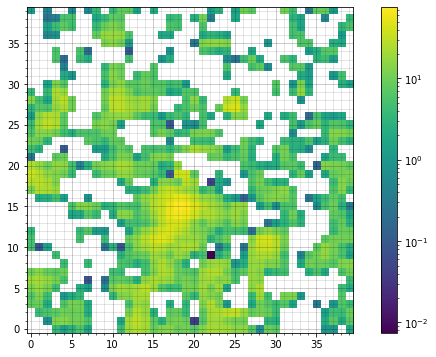

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.434756 3.0174515    16.653923 0.050579411
  2        1             1 24.534598 4.0607341    16.598573 0.049130323
  3        2             1 19.741029 19.956366    16.531196  0.04061981
  4        1             2 28.973933 5.1364362    17.420561 0.061242892
 id  xcenter   ycenter    mag_e6     err_e6   id_master
--- --------- --------- --------- ----------- ---------
  1 15.434756 3.0174515 16.653923 0.050579411         0
  2 24.534598 4.0607341 16.598573 0.049130323         1
  3 19.741029 19.956366 16.531196  0.04061981         2
  4 28.973933 5.1364362 17.420561 0.061242892         3
id_master    x_0       y_0        RA    ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.037566263 16.653923 0.05057941

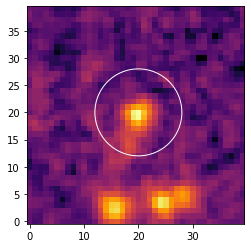

Mean: 44.564720153808594
Median: 39.59773254394531
Std dev: 20.280550003051758
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.564749020605866 ... 2.9685813322824215 -1.1813723802308034
  2 24.521924645846568 ...  2.701261719771453 -1.0789166603446532
  3    19.834005774293 ...  3.475327996429202 -1.3524894973636068
Number of PSF stars: 3


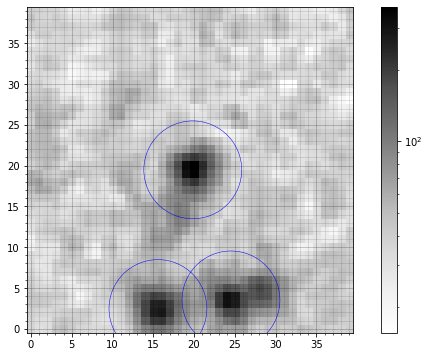

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.564749 2.4744354  0.5221548 ... 280.71216 2.9685813 -1.1813724        1
  2 24.521925 3.5346052 0.66508775 ... 305.35577 2.7012617 -1.0789167        1
  3 19.834006 19.485999 0.67392894 ... 367.90244  3.475328 -1.3524895        2


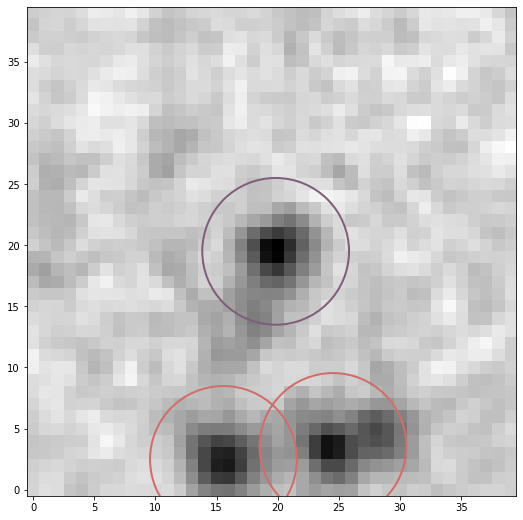

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.11658429999806685s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.564749 2.4744354 4970.8549   1 ... 4167.3416 152.34688             1
24.521925 3.5346052 6218.9892   2 ... 4314.5054 151.11573             1
19.834006 19.485999 5261.3001   3 ... 4973.3311  114.0385             1
28.882514  4.655196 1819.9378   4 ... 1733.0658 75.841961             2


KeyboardInterrupt: 

In [145]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')

        print_table_nicely(master_table)

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi=1.)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                    
                print(sources_PSF)
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                for i, group in enumerate(star_groups.groups):
                    pos_group = np.transpose([group['x_0'], group['y_0']])
                    ap_group = CircularAperture(pos_group, r_ap)
                    ap_group.plot(color=cmap.colors[i], lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                match_table['id_master'] = master_table['id_master']

                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###


            # This approach relies on the same stars being detected in the same order in each epoch, which isn't ideal:
            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)


            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close() 


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###